## Module Imports

In [1]:
import importMat as im
import experimentList as el
import angleDataframeCreation as adc
import plottingFunctions as pf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import spectrogram
from scipy.signal import hilbert, butter, filtfilt, firls, savgol_filter, lfilter, decimate
import scipy.stats as stats
import emd
import constants as const
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels

Loading DLC 2.3.6...


## Recreate dataframe (if new data has been added): Do not touch unless recreating dataframe!

In [2]:
df = adc.createDataFrame()

2025_01_09_E8 added to Dataframe.
2025_01_09_E9 added to Dataframe.
2025_01_16_E1 added to Dataframe.
2025_01_16_E2 added to Dataframe.
2025_01_16_E3 added to Dataframe.
2025_01_16_E4 added to Dataframe.
2025_01_28_E1 added to Dataframe.
2025_01_28_E2 added to Dataframe.
2025_01_28_E3 added to Dataframe.
2025_01_28_E4 added to Dataframe.
2025_01_30_E1 added to Dataframe.
2025_01_30_E2 added to Dataframe.
2025_01_30_E3 added to Dataframe.
2025_01_31_E1 added to Dataframe.
2025_01_31_E2 added to Dataframe.
2025_01_31_E3 added to Dataframe.
2025_01_31_E4 added to Dataframe.
2025_01_07_E5 added to Dataframe.
2025_01_09_E1 added to Dataframe.
2025_01_09_E2 added to Dataframe.
2025_01_09_E3 added to Dataframe.
2025_01_09_E4 added to Dataframe.
2025_01_09_E5 added to Dataframe.
2025_01_09_E6 added to Dataframe.
2025_01_09_E7 added to Dataframe.
2025_01_13_E7 added to Dataframe.
2025_01_13_E8 added to Dataframe.
2025_02_27_E1 added to Dataframe.
2025_02_27_E2 added to Dataframe.
2025_02_27_E3 

## Load dataframe and create conditional average subDataFrames

In [2]:
df = pf.loadDataFrame(cameraView='dorsal')
# Generates Left Right Conditional Averages : DO NOT DELETE
lra_df = df.reset_index()

for datatype in ['L_antenna','R_antenna']:
    fnf = ['_Flight_', '_noFlight_']
    flightNames = [stim + fnf[0] + datatype for stim in const.stimNames]
    noflightNames = [stim + fnf[1] + datatype for stim in const.stimNames]
    for idx, name in enumerate(flightNames):
        lra_df[name] = pd.Series(dtype='object')
        lra_df[noflightNames[idx]] = pd.Series(dtype='object')
    for i in lra_df.index:
        traces = lra_df[datatype][i]
        avgs = np.zeros((len(const.stimNames),np.shape(traces)[1]))
        stimType = const.stimSeqNames[const.stimSeqNumbers.index(lra_df[const.seq_order_name][i][0])]
        stimSeq = const.stimSeqs[stimType]
        pufferSignal = lra_df[const.puffer_signal_name][i]
        flyingBool = np.zeros(np.shape(avgs))
        flightBool = lra_df['flightBool'][i]
        not_flyingBool = np.zeros(np.shape(avgs))
        for j, stim in enumerate(stimSeq):
            stim_save_idx = const.stimNames.index(stim)
            avgStart = const.stimStart[j] + const.avgStartAndLen[j][0]
            avgEnd = avgStart + const.avgStartAndLen[j][1]
            avgs[stim_save_idx, :] = np.mean(traces[avgStart*const.fps:avgEnd*const.fps], axis=0)
            if np.all(flightBool[avgStart*const.fs:avgEnd*const.fs]):
                flyingBool[stim_save_idx,:] = True
            elif np.all(flightBool[avgStart*const.fs:avgEnd*const.fs] == False):
                not_flyingBool[stim_save_idx,:] = True
            if np.any(pufferSignal[avgStart*const.fs:avgEnd*const.fs] > const.puffer_cutoff_value):
                flyingBool[stim_save_idx,:] = False
                not_flyingBool[stim_save_idx,:] = False
            flyingArray = avgs * flyingBool
            flyingArray[flyingArray == 0] = np.nan
            not_flyingArray = avgs * not_flyingBool
            not_flyingArray[not_flyingArray == 0] = np.nan
        for k in range(len(flyingArray)):
            lra_df[flightNames[k]][i] = flyingArray[k,:]
            lra_df[noflightNames[k]][i] = not_flyingArray[k,:]
            
# Generates Flight Data Conditional Avgs: DO NOT DELETE
fl_df = df.reset_index()
#fl_df['wba'] = fl_df['wba'].apply(lambda x: x * -1) 
for datatype in ['wbf', 'wba']:
    
    flightNames = [stim + '_Flight_' + datatype for stim in const.stimNames]
    for idx, name in enumerate(flightNames):
        fl_df[name] = pd.Series(dtype='object')
    for i in fl_df.index:
        traces = fl_df[datatype][i]
        avgs = np.zeros((len(const.stimNames),1))
        stimType = const.stimSeqNames[const.stimSeqNumbers.index(fl_df[const.seq_order_name][i][0])]
        stimSeq = const.stimSeqs[stimType]
        pufferSignal = fl_df[const.puffer_signal_name][i]
        flyingBool = np.zeros(np.shape(avgs))
        flightBool = fl_df['flightBool'][i]
        for j, stim in enumerate(stimSeq):
            stim_save_idx = const.stimNames.index(stim)
            avgStart = const.stimStart[j] + const.avgStartAndLen[j][0]
            avgEnd = avgStart + const.avgStartAndLen[j][1]
            avgs[stim_save_idx, :] = np.mean(traces[avgStart*const.fs:avgEnd*const.fs], axis=0)
            if np.all(flightBool[avgStart*const.fs:avgEnd*const.fs]):
                flyingBool[stim_save_idx,:] = True
            if np.any(pufferSignal[avgStart*const.fs:avgEnd*const.fs] > const.puffer_cutoff_value):
                flyingBool[stim_save_idx,:] = False
            flyingArray = avgs * flyingBool
            flyingArray[flyingArray == 0] = np.nan
        for k in range(len(flyingArray)):
            fl_df[flightNames[k]][i] = flyingArray[k,:]
    #flightNames.insert(0,'fly')
    #mindf = fl_df.loc[:,flightNames]
    #min_values = [np.nanmin(np.array([mindf.query('fly==@i').to_numpy() for i in range(el.num_experiments)])[i,:,1:])for i in range(el.num_experiments)]
    #for col_name in flightNames[1:]:
    #    by_fly[(fl_df.query('fly==@i')[col_name]) for i in range(el.num_experiments)]

## Counts in each condition for flight and non-flight

In [3]:
pf.countStats(df)

Condition: silenced
0_Flight: N= 14 n= 43
50_Flight: N= 13 n= 37
100_Flight: N= 12 n= 30
150_Flight: N= 12 n= 20
200_Flight: N= 8 n= 11
250_Flight: N= 10 n= 13
300_Flight: N= 10 n= 18

Number of flies for condition: 14

Condition: silencedCS
0_Flight: N= 15 n= 45
50_Flight: N= 15 n= 50
100_Flight: N= 14 n= 42
150_Flight: N= 11 n= 25
200_Flight: N= 7 n= 17
250_Flight: N= 6 n= 15
300_Flight: N= 8 n= 27

Number of flies for condition: 15

Condition: silencedCS_glued
0_Flight: N= 12 n= 49
50_Flight: N= 12 n= 50
100_Flight: N= 12 n= 45
150_Flight: N= 12 n= 32
200_Flight: N= 10 n= 28
250_Flight: N= 8 n= 20
300_Flight: N= 8 n= 23

Number of flies for condition: 12

Condition: silenced
0_noFlight: N= 17 n= 121
50_noFlight: N= 17 n= 127
100_noFlight: N= 17 n= 135
150_noFlight: N= 17 n= 149
200_noFlight: N= 17 n= 153
250_noFlight: N= 17 n= 150
300_noFlight: N= 17 n= 141

Number of flies for condition: 17

Condition: silencedCS
0_noFlight: N= 15 n= 99
50_noFlight: N= 15 n= 95
100_noFlight: N= 15 

## Kolmogorov–Smirnov test across conditions to confirm normality

In [4]:
flight_cols = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
no_flight_cols = ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
all_cols = [flight_cols, no_flight_cols]
dead_num = 0
for col_list in all_cols:
    for condition in df['condition'].unique():
        print('Condition: ' + condition)
        N_list = []
        n_list = []
        dead_num += 1
        for col in col_list:
            nanBool = ~np.isnan(np.nanmean(pf.extractConditionalAvgs(col,df[df['condition'] == condition]),axis=2))
            N = np.sum(np.count_nonzero(nanBool, axis=1) > 0)
            n = np.sum(np.count_nonzero(nanBool, axis=1))
            print(col + ': ' + 'N= ' + str(N) + ' ' + 'n= ' + str(n))
            N_list.append(N)
            n_list.append(n)
            if dead_num != 2: 
                data = np.nanmean(pf.extractConditionalAvgs(col,df[df['condition'] == condition]),axis=1)
                act_seg = data[:,1][~np.isnan(data[:,1])]
                pas_seg = data[:,0][~np.isnan(data[:,0])]
                active_seg_normality = stats.kstest(act_seg,'norm',args=(np.mean(act_seg),np.std(act_seg,ddof=1)))
                passive_seg_normality = stats.kstest(pas_seg,'norm',args=(np.mean(pas_seg),np.std(pas_seg,ddof=1)))
                print('2nd segment normality test:')
                print(active_seg_normality)
                print()
                print('3rd segment normality test:')
                print(passive_seg_normality)
                print()
            
                                       
        print()
        print('Number of flies for condition: ' + str(np.max(N_list)))
        print()

Condition: silenced
0_Flight: N= 14 n= 43
2nd segment normality test:
KstestResult(statistic=0.14174205806450435, pvalue=0.9041087622828503, statistic_location=104.32500000000002, statistic_sign=-1)

3rd segment normality test:
KstestResult(statistic=0.12272974001761663, pvalue=0.9671930082908353, statistic_location=84.64944444444444, statistic_sign=-1)

50_Flight: N= 13 n= 37
2nd segment normality test:
KstestResult(statistic=0.13103834273269832, pvalue=0.9577002005143017, statistic_location=98.3438888888889, statistic_sign=-1)

3rd segment normality test:
KstestResult(statistic=0.279290305748164, pvalue=0.21749098755186957, statistic_location=99.07305555555556, statistic_sign=-1)

100_Flight: N= 12 n= 30
2nd segment normality test:
KstestResult(statistic=0.1608740551555683, pvalue=0.8675235840919197, statistic_location=105.29133333333334, statistic_sign=-1)

3rd segment normality test:
KstestResult(statistic=0.1899179684669998, pvalue=0.7128581119352149, statistic_location=103.131851

## Fig 4B

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Intercept                                        143.285747
state[T.flight]                                  -24.190637
condition[T.silenced]                             -9.046574
condition[T.silencedCS_glued]                     -4.424875
state[T.flight]:condition[T.silenced]             -9.255929
state[T.flight]:condition[T.silencedCS_glued]     -2.058398
Group Var                                          6.102721
Group x state[T.flight] Cov                        1.217764
state[T.flight] Var                                0.352324
dtype: float64
Intercept                                        2.773932
state[T.flight]                                  1.596364
condition[T.silenced]                            3.805803
condition[T.silencedCS_glued]                    3.922932
state[T.flight]:condition[T.silenced]            2.298622
state[T.flight]:condition[T.silencedCS_glued]    2.429041
Group Var                                             NaN
Group x state[T.flight] Cov            

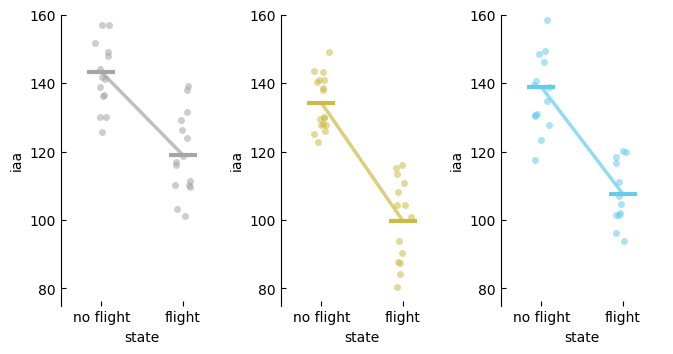

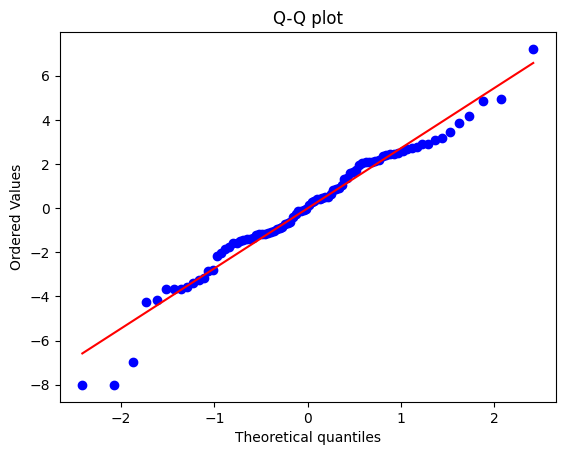

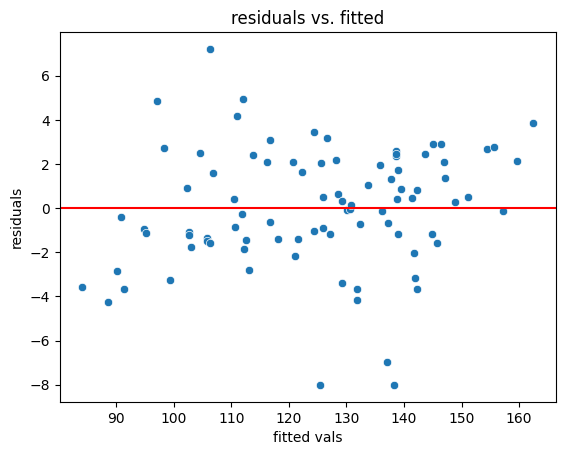

In [5]:
catg_names = ['0', '50', '100', '150', '200', '250', '300']
conditions = ['silencedCS', 'silenced','silencedCS_glued']
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(6.75,3.5),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
for j, condition in enumerate(conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd_flight = pd.DataFrame()
    line_df_2nd_noFlight = pd.DataFrame()
    col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd_flight[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col_list_flight[i], df_condition), axis=1)[:,1]
        line_df_2nd_noFlight[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1]
        
    df_flight =pd.melt(line_df_2nd_flight, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_noFlight =pd.melt(line_df_2nd_noFlight, var_name='windspeed',value_name='iaa',ignore_index=False)
    
    df_flight['state'] = 'flight'
    df_noFlight['state'] = 'no flight'
    df_flight['index'] = df_flight.index
    df_noFlight['index'] = df_noFlight.index
    
    df_plot = pd.concat([df_noFlight,df_flight])
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
df_final = df_final[df_final['windspeed'] == '0']

bcyan = np.array([102,204,238])/255
byellow = np.array([204,187,68])/255
vgrey = np.array([165,165,165])/255
palette = [byellow, vgrey]

p = sns.stripplot(x='state',y='iaa',data=df_final[df_final['condition'] == 'silencedCS'], ax=ax1,dodge=True,alpha=.55,color=vgrey)
p2 = sns.pointplot(x='state',y='iaa',data=df_final[df_final['condition'] == 'silencedCS'],ax=ax1,errorbar=None,marker="_",linestyle="none",markersize=20,markeredgewidth=3,color=vgrey)
p3 = sns.pointplot(x='state',y='iaa',data=df_final[df_final['condition'] == 'silencedCS'], ax=ax1,lw=2.5,markers='none',alpha=0.7,errorbar=None,color=vgrey)

p = sns.stripplot(x='state',y='iaa',data=df_final[df_final['condition'] == 'silenced'], ax=ax2,dodge=True,alpha=.55,color=byellow)
p2 = sns.pointplot(x='state',y='iaa',data=df_final[df_final['condition'] == 'silenced'],ax=ax2,errorbar=None,marker="_",linestyle="none",markersize=20,markeredgewidth=3,color=byellow)
p3 = sns.pointplot(x='state',y='iaa',data=df_final[df_final['condition'] == 'silenced'], ax=ax2,lw=2.5,markers='none',alpha=0.7,errorbar=None,color=byellow)

p = sns.stripplot(x='state',y='iaa',data=df_final[df_final['condition'] == 'silencedCS_glued'], ax=ax3,dodge=True,alpha=.55,color=bcyan)
p2 = sns.pointplot(x='state',y='iaa',data=df_final[df_final['condition'] == 'silencedCS_glued'],ax=ax3,errorbar=None,marker="_",linestyle="none",markersize=20,markeredgewidth=3,color=bcyan)
p3 = sns.pointplot(x='state',y='iaa',data=df_final[df_final['condition'] == 'silencedCS_glued'], ax=ax3,lw=2.5,markers='none',alpha=0.7,errorbar=None,color=bcyan)

ax1.legend().set_visible(False)
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([75,160])
ax1.set_yticks([80,100,120,140,160])
ax1.tick_params(direction="in")

ax2.legend().set_visible(False)
ax2.spines[['right', 'top','bottom']].set_visible(False)
ax2.set_ylim([75,160])
ax2.set_yticks([80,100,120,140,160])
ax2.tick_params(direction="in")

ax3.legend().set_visible(False)
ax3.spines[['right', 'top','bottom']].set_visible(False)
ax3.set_ylim([75,160])
ax3.set_yticks([80,100,120,140,160])
ax3.tick_params(direction="in")

df_final = df_final.dropna()
df_final['subject_uid'] = df_final['index'].astype(str) + "_" + df_final['condition'].astype(str)
df_final['state'] = pd.Categorical(
    df_final['state'],
    categories = ['no flight', 'flight'],
    ordered=True
)
df_final['condition'] = pd.Categorical(
    df_final['condition'],
    categories = ['silencedCS', 'silenced', 'silencedCS_glued'],
    ordered=True
)
model = smf.mixedlm("iaa ~ state * condition",
                    df_final,
                    groups=df_final["subject_uid"],
                    re_formula="~state")

result = model.fit()
print(result.params)
print(result.bse)
print(result.tvalues)
print(result.pvalues)
print(result.summary())

params = result.params
cov = result.cov_params()
residuals = result.resid
fig_qq, ax_qq = plt.subplots()
stats.probplot(residuals, dist="norm",plot=ax_qq)
ax_qq.set_title('Q-Q plot')
fig_qq.savefig('qq_noFlight_4B.pdf')
fitted = result.fittedvalues
fig_rvf, ax_rvf = plt.subplots()
sns.scatterplot(x=fitted,y=residuals,ax=ax_rvf)
ax_rvf.axhline(0,color='r')
ax_rvf.set_xlabel('fitted vals')
ax_rvf.set_ylabel('residuals')
ax_rvf.set_title('residuals vs. fitted')
fig_rvf.savefig('rvf_noFlight_4B.pdf')

"""
windspeeds = np.array([0, 50, 100, 150, 200, 250, 300])

comparisons = []

for cond in ['silenced', 'silencedCS_glued']:
    for ws in windspeeds:
        # Get contrast: difference in estimated means vs control
        delta = params[f'condition[T.{cond}]'] + ws * params[f'windspeed:condition[T.{cond}]']
        
        # Compute SE via delta method
        var = (
            cov.loc[f'condition[T.{cond}]', f'condition[T.{cond}]'] +
            ws**2 * cov.loc[f'windspeed:condition[T.{cond}]', f'windspeed:condition[T.{cond}]'] +
            2 * ws * cov.loc[f'condition[T.{cond}]', f'windspeed:condition[T.{cond}]']
        )
        se = np.sqrt(var)
        
        z = delta / se
        p = 2 * (1 - stats.norm.cdf(abs(z)))
        
        comparisons.append({
            'condition_vs_control': cond,
            'windspeed': ws,
            'contrast': delta,
            'SE': se,
            'z': z,
            'p': p
        })

results_df = pd.DataFrame(comparisons)
results_df['p_corr'] = statsmodels.stats.multitest.multipletests(results_df['p'], method='holm')[1]
print(results_df.round(4))
"""
"""
model = ols(
    'iaa ~ C(state) + C(condition) +\
    C(state):C(condition)', data=df_final).fit()
result = sm.stats.anova_lm(model,type=2)
print(result)

df_final_clean = df_final.filter(items=['iaa','condition','state']).dropna()


silencedCS_f = df_final_clean[(df_final_clean['condition'] == 'silencedCS') & (df_final_clean['state'] == 'flight')]
silencedCS_f_mean = np.nanmean(silencedCS_f['iaa'])
silencedCS_nf = df_final_clean[(df_final_clean['condition'] == 'silencedCS') & (df_final_clean['state'] == 'no flight')]
silencedCS_nf_mean = np.nanmean(silencedCS_nf['iaa'])
silenced_f = df_final_clean[(df_final_clean['condition'] == 'silenced') & (df_final_clean['state'] == 'flight')]
silenced_f_mean = np.nanmean(silenced_f['iaa'])
silenced_nf = df_final_clean[(df_final_clean['condition'] == 'silenced') & (df_final_clean['state'] == 'no flight')]
silenced_nf_mean = np.nanmean(silenced_nf['iaa'])
silencedCS_glued_f = df_final_clean[(df_final_clean['condition'] == 'silencedCS_glued') & (df_final_clean['state'] == 'flight')]
silencedCS_glued_f_mean = np.nanmean(silencedCS_glued_f['iaa'])
silencedCS_glued_nf = df_final_clean[(df_final_clean['condition'] == 'silencedCS_glued') & (df_final_clean['state'] == 'no flight')]
silencedCS_glued_nf_mean = np.nanmean(silencedCS_glued_nf['iaa'])

print('control mean diff: ' + str(silencedCS_nf_mean - silencedCS_f_mean))
print('silenced mean diff: ' + str(silenced_nf_mean - silenced_f_mean))
print('glued mean diff: ' + str(silencedCS_glued_nf_mean - silencedCS_glued_f_mean))
print('glued vs control flight mean diff: ' + str(silencedCS_glued_f_mean - silencedCS_f_mean))

print(stats.tukey_hsd(silencedCS_nf['iaa'], silencedCS_f['iaa'], silenced_nf['iaa'], silenced_f['iaa'],silencedCS_glued_nf['iaa'],silencedCS_glued_f['iaa']))


control_state_t, control_state_p = stats.ttest_ind(silencedCS_f['iaa'],silencedCS_nf['iaa'],nan_policy='omit')
silenced_state_t, silenced_state_p = stats.ttest_ind(silenced_f['iaa'],silenced_nf['iaa'],nan_policy='omit')
f_t, f_p = stats.ttest_ind(silenced_f['iaa'],silencedCS_f['iaa'],nan_policy='omit')
nf_t, nf_p = stats.ttest_ind(silenced_nf['iaa'],silencedCS_nf['iaa'],nan_policy='omit')

num_tests = 4
p_values = [control_state_p, silenced_state_p, f_p, nf_p]
corrected_p_values = [control_state_p, silenced_state_p, f_p, nf_p] * num_tests

print('Control: t=' + str(control_state_t) + ' p=' + str(p_values[0]))
print('silenced: t=' + str(control_state_t) + ' p=' + str(p_values[1]))
print('flight: t=' + str(control_state_t) + ' p=' + str(p_values[2]))
print('nf: t=' + str(control_state_t) + ' p=' + str(p_values[3]))
"""
###########################

fig.savefig(const.savedFigureDirectory+'png/'+'4B'+'.png',format='png')
fig.savefig(const.savedFigureDirectory+'4B'+'.pdf',format='pdf')

## Glued vs control comparison

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                             df       sum_sq      mean_sq          F  \
C(windspeed)                1.0  4062.910946  4062.910946  47.081943   
C(condition)                1.0  2249.055633  2249.055633  26.062572   
C(windspeed):C(condition)   1.0  2446.426691  2446.426691  28.349753   
Residual                   58.0  5005.078855    86.294463        NaN   

                                 PR(>F)  
C(windspeed)               5.003509e-09  
C(condition)               3.834510e-06  
C(windspeed):C(condition)  1.715134e-06  
Residual                            NaN  
control mean diff: 29.16543853615515
glued mean diff: 4.025956404320969
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    -29.165     0.000   -38.138   -20.193
 (0 - 2)     -0.518     0.999    -9.349     8.313
 (0 - 3)     -4.544     0.529   -13.375     4.287
 (1 - 0)     29.165     0.000    20.193    38.138
 (1 - 2)     28.648     0.000    19.817

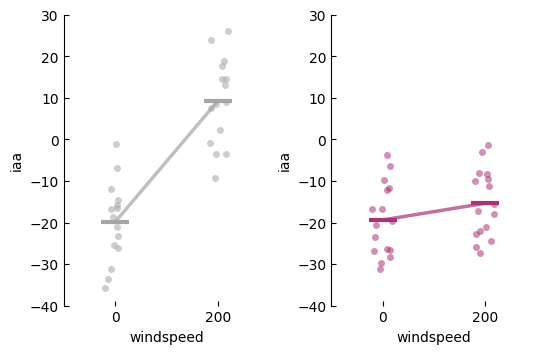

In [7]:
catg_names = ['0', '200']
conditions = ['silencedCS', 'silencedCS_glued']
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(5.5,3.5),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
for j, condition in enumerate(conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd_flight = pd.DataFrame()
    line_df_2nd_noFlight = pd.DataFrame()
    col_list_noFlight =  ['0_noFlight','200_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd_noFlight[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1]
        
    df_flight =pd.melt(line_df_2nd_flight, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_noFlight =pd.melt(line_df_2nd_noFlight, var_name='windspeed',value_name='iaa',ignore_index=False)
    
    df_flight['state'] = 'flight'
    df_noFlight['state'] = 'no flight'
    
    df_plot = pd.concat([df_noFlight,df_flight])
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()

bpurp = np.array([170,51,119])/255
byellow = np.array([204,187,68])/255
vgrey = np.array([165,165,165])/255
palette = [bpurp, vgrey]

p = sns.stripplot(x='windspeed',y='iaa',data=df_final[df_final['condition'] == 'silencedCS'], ax=ax1,dodge=True,alpha=.55,color=vgrey)
p2 = sns.pointplot(x='windspeed',y='iaa',data=df_final[df_final['condition'] == 'silencedCS'],ax=ax1,errorbar=None,marker="_",linestyle="none",markersize=20,markeredgewidth=3,color=vgrey)
p3 = sns.pointplot(x='windspeed',y='iaa',data=df_final[df_final['condition'] == 'silencedCS'], ax=ax1,lw=2.5,markers='none',alpha=0.7,errorbar=None,color=vgrey)

p = sns.stripplot(x='windspeed',y='iaa',data=df_final[df_final['condition'] == 'silencedCS_glued'], ax=ax2,dodge=True,alpha=.55,color=bpurp)
p2 = sns.pointplot(x='windspeed',y='iaa',data=df_final[df_final['condition'] == 'silencedCS_glued'],ax=ax2,errorbar=None,marker="_",linestyle="none",markersize=20,markeredgewidth=3,color=bpurp)
p3 = sns.pointplot(x='windspeed',y='iaa',data=df_final[df_final['condition'] == 'silencedCS_glued'], ax=ax2,lw=2.5,markers='none',alpha=0.7,errorbar=None,color=bpurp)

ax1.legend().set_visible(False)
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([-40,30])
#ax1.set_yticks([80,100,120,140,160])
ax1.tick_params(direction="in")

ax2.legend().set_visible(False)
ax2.spines[['right', 'top','bottom']].set_visible(False)
ax2.set_ylim([-40,30])
#ax2.set_yticks([80,100,120,140,160])
ax2.tick_params(direction="in")



model = ols(
    'iaa ~ C(windspeed) + C(condition) +\
    C(windspeed):C(condition)', data=df_final).fit()
result = sm.stats.anova_lm(model,type=2)
print(result)

df_final_clean = df_final.filter(items=['iaa','condition','windspeed']).dropna()

silencedCS_0 = df_final_clean[(df_final_clean['condition'] == 'silencedCS') & (df_final_clean['windspeed'] == '0')]
silencedCS_0_mean = np.nanmean(silencedCS_0['iaa'])
silencedCS_200 = df_final_clean[(df_final_clean['condition'] == 'silencedCS') & (df_final_clean['windspeed'] == '200')]
silencedCS_200_mean = np.nanmean(silencedCS_200['iaa'])
glued_0 = df_final_clean[(df_final_clean['condition'] == 'silencedCS_glued') & (df_final_clean['windspeed'] == '0')]
glued_0_mean = np.nanmean(glued_0['iaa'])
glued_200 = df_final_clean[(df_final_clean['condition'] == 'silencedCS_glued') & (df_final_clean['windspeed'] == '200')]
glued_200_mean = np.nanmean(glued_200['iaa'])

print('control mean diff: ' + str(silencedCS_200_mean - silencedCS_0_mean))
print('glued mean diff: ' + str(glued_200_mean - glued_0_mean))

result = stats.tukey_hsd(silencedCS_0['iaa'], silencedCS_200['iaa'], glued_0['iaa'], glued_200['iaa'])
print(result)
print(result.pvalue)

fig.savefig(const.savedFigureDirectory+'png/'+'antennalGluingMethodFig'+'.png',format='png')
fig.savefig(const.savedFigureDirectory+'antennalGluingMethodFig'+'.pdf',format='pdf')

## Fig 4C and 4D

Intercept                                  142.365677
condition[T.silenced]                       -9.365453
condition[T.silencedCS_glued]               -3.662570
windspeed                                    0.008800
windspeed:condition[T.silenced]              0.024278
windspeed:condition[T.silencedCS_glued]      0.019671
Group Var                                   14.386864
dtype: float64
Intercept                                  2.772752
condition[T.silenced]                      3.804185
condition[T.silencedCS_glued]              3.921264
windspeed                                  0.002719
windspeed:condition[T.silenced]            0.003731
windspeed:condition[T.silencedCS_glued]    0.003846
Group Var                                  3.332694
dtype: float64
Intercept                                  51.344536
condition[T.silenced]                      -2.461882
condition[T.silencedCS_glued]              -0.934028
windspeed                                   3.235916
windspeed:condit

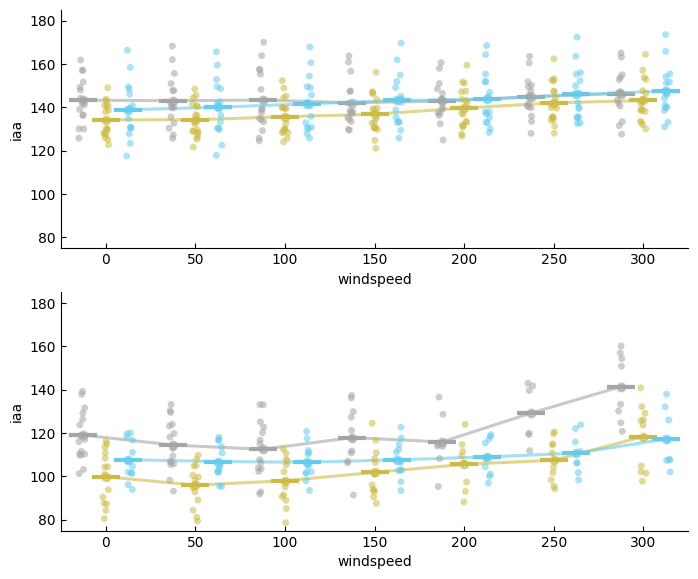

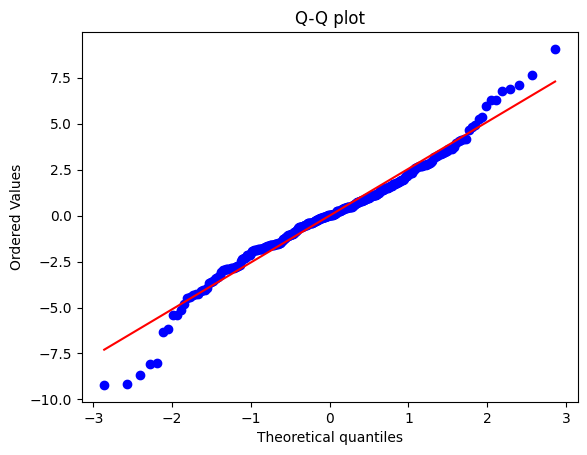

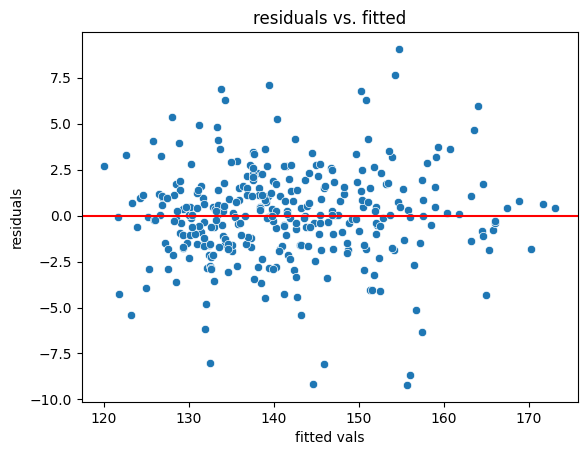

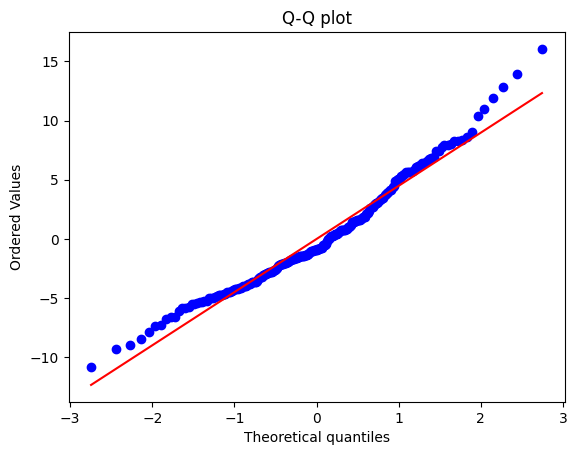

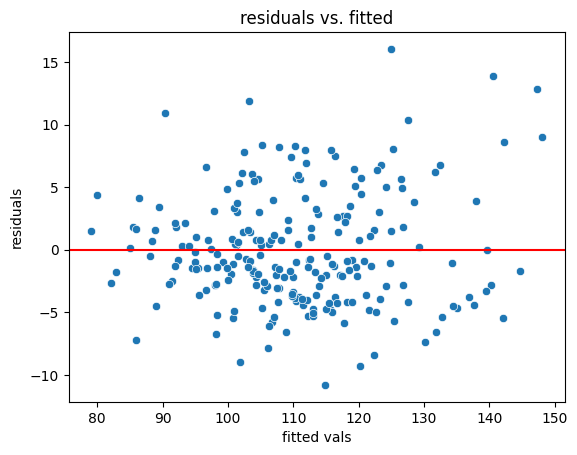

In [6]:
catg_names = ['0', '50', '100', '150', '200', '250', '300']
flight_conditions = ['silencedCS', 'silenced','silencedCS_glued']
noFlight_conditions = ['silencedCS', 'silenced','silencedCS_glued']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7,5.8),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
for j, condition in enumerate(noFlight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    #col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] #- np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
bcyan = np.array([102,204,238])/255
byellow = np.array([204,187,68])/255
vgrey = np.array([165,165,165])/255
palette = [vgrey, byellow,bcyan]
#palette = [np.array([0,0,0]), np.array([1,1,1])]
#palette = [np.array([0,0,0]), np.array([1,1,1])]
#p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,legend=False,linewidth=1,alpha=0.9)
#p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=[np.array([0,0,0]),np.array([0,0,0])],dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,legend=False,alpha=.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.5,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p3 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.5,lw=2.2,alpha=0.6,errorbar=None)
ax1.legend().set_visible(False)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_ylim([75,185])
ax1.set_yticks([80,100,120,140,160,180])
ax1.tick_params(direction="in")
#ax1.xaxis.set_visible(False)


df_final = df_final.dropna()
df_final['subject_uid'] = df_final['index'].astype(str) + "_" + df_final['condition'].astype(str)
df_final['windspeed'] = df_final['windspeed'].astype(int)
df_final['condition'] = pd.Categorical(
    df_final['condition'],
    categories = ['silencedCS', 'silenced', 'silencedCS_glued'],
    ordered=True
)
model = smf.mixedlm("iaa ~ windspeed * condition",
                    df_final,
                    groups=df_final["subject_uid"])
                    #re_formula="~windspeed_num")

result = model.fit()
print(result.params)
print(result.bse)
print(result.tvalues)
print(result.pvalues)
print(result.summary())

params = result.params
cov = result.cov_params()
residuals = result.resid
fig_qq, ax_qq = plt.subplots()
stats.probplot(residuals, dist="norm",plot=ax_qq)
ax_qq.set_title('Q-Q plot')
fig_qq.savefig('qq_noFlight_silencing.pdf')
fitted = result.fittedvalues
fig_rvf, ax_rvf = plt.subplots()
sns.scatterplot(x=fitted,y=residuals,ax=ax_rvf)
ax_rvf.axhline(0,color='r')
ax_rvf.set_xlabel('fitted vals')
ax_rvf.set_ylabel('residuals')
ax_rvf.set_title('residuals vs. fitted')
fig_rvf.savefig('rvf_noFlight_silencing.pdf')

windspeeds = np.array([0, 50, 100, 150, 200, 250, 300])

comparisons = []

for cond in ['silenced', 'silencedCS_glued']:
    for ws in windspeeds:
        # Get contrast: difference in estimated means vs control
        delta = params[f'condition[T.{cond}]'] + ws * params[f'windspeed:condition[T.{cond}]']
        
        # Compute SE via delta method
        var = (
            cov.loc[f'condition[T.{cond}]', f'condition[T.{cond}]'] +
            ws**2 * cov.loc[f'windspeed:condition[T.{cond}]', f'windspeed:condition[T.{cond}]'] +
            2 * ws * cov.loc[f'condition[T.{cond}]', f'windspeed:condition[T.{cond}]']
        )
        se = np.sqrt(var)
        
        z = delta / se
        p = 2 * (1 - stats.norm.cdf(abs(z)))
        
        comparisons.append({
            'condition_vs_control': cond,
            'windspeed': ws,
            'contrast': delta,
            'SE': se,
            'z': z,
            'p': p
        })

results_df = pd.DataFrame(comparisons)
results_df['p_corr'] = statsmodels.stats.multitest.multipletests(results_df['p'], method='holm')[1]
print(results_df.round(4))

"""
model = ols(
    'iaa ~ C(condition) + C(windspeed) +\
    C(condition):C(windspeed)', data=df_final).fit()
result = sm.stats.anova_lm(model,type=2)
print(result)
print()

ts = np.zeros((3,7))
ps = np.zeros((3,7))
for i, windspeed in enumerate(catg_names):
    num_tests = len(catg_names)
    ws_df = df_final.loc[(df_final['windspeed'] == windspeed)]
    ws_df_clean = ws_df.filter(items=['iaa','condition']).dropna()
    silencedCS_glued = ws_df_clean[ws_df_clean['condition'] == 'silencedCS_glued']
    silencedCS = ws_df_clean[ws_df_clean['condition'] == 'silencedCS']
    silenced = ws_df_clean[ws_df_clean['condition'] == 'silenced']
    ans_control_opto = stats.ttest_ind(silencedCS['iaa'],silenced['iaa'])
    ans_control_glued = stats.ttest_ind(silencedCS['iaa'],silencedCS_glued['iaa'])
    ans_opto_glued = stats.ttest_ind(silenced['iaa'],silencedCS_glued['iaa'])
    ts[0,i] = ans_control_opto[0]
    ps[0,i] = ans_control_opto[1]
    ts[1,i] = ans_control_glued[0]
    ps[1,i] = ans_control_glued[1]
    ts[2,i] = ans_opto_glued[0]
    ps[2,i] = ans_opto_glued[1]

flattened_ps = ps.flatten()
#results = statsmodels.stats.multitest.multipletests(ps,alpha=0.05,method='fdr_bh')
flattened_new_ps = stats.false_discovery_control(flattened_ps)
new_ps = flattened_new_ps.reshape([3,7])
for i, windspeed in enumerate(catg_names):                                
    print('windspeed = '+ windspeed)
    print('control x opto')
    print('t='+str(ts[0,i]) + ' q=' + str(new_ps[0,i]))
    print('------')
    print('control x glued')
    print('t='+str(ts[1,i]) + ' q=' + str(new_ps[1,i]))
    print('------')
    print('opto x glued')
    print('t='+str(ts[2,i]) + ' q=' + str(new_ps[2,i])+'\n')
    
"""

###########################
df_plots = []
for j, condition in enumerate(flight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    #col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_flight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] #- np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    #df_plot=df_plot[df_plot['index']!=9]
    df_plots.append(df_plot)
df_final = pd.concat(df_plots).reset_index()
k = np.array([0,0,0])/255
w = np.array([255,255,255])/255
#palette = [np.array([0,0,0]), np.array([1,1,1])]
#p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,legend=False,linewidth=1,alpha=0.9)
#p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=[np.array([0,0,0]),np.array([0,0,0])],dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,legend=False,alpha=0.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.5,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p3 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.5,lw=2.2,alpha=0.6,errorbar=None)
ax2.legend().set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_ylim([75,185])
ax2.set_yticks([80,100,120,140,160,180])
ax2.tick_params(direction="in")

df_final = df_final.dropna()
df_final['subject_uid'] = df_final['index'].astype(str) + "_" + df_final['condition'].astype(str)
df_final['windspeed'] = df_final['windspeed'].astype(int)
df_final['condition'] = pd.Categorical(
    df_final['condition'],
    categories = ['silencedCS', 'silenced', 'silencedCS_glued'],
    ordered=True
)
model = smf.mixedlm("iaa ~ windspeed * condition",
                    df_final,
                    groups=df_final["subject_uid"])
                    #re_formula="~windspeed_num")

result = model.fit()
print(result.params)
print(result.bse)
print(result.tvalues)
print(result.pvalues)
print(result.summary())

params = result.params
cov = result.cov_params()
residuals = result.resid
fig_qq, ax_qq = plt.subplots()
stats.probplot(residuals, dist="norm",plot=ax_qq)
ax_qq.set_title('Q-Q plot')
fig_qq.savefig('qq_flight_silencing.pdf')
fitted = result.fittedvalues
fig_rvf, ax_rvf = plt.subplots()
sns.scatterplot(x=fitted,y=residuals,ax=ax_rvf)
ax_rvf.axhline(0,color='r')
ax_rvf.set_xlabel('fitted vals')
ax_rvf.set_ylabel('residuals')
ax_rvf.set_title('residuals vs. fitted')
fig_rvf.savefig('rvf_flight_silencing.pdf')


windspeeds = np.array([0, 50, 100, 150, 200, 250, 300])

comparisons = []

for cond in ['silenced', 'silencedCS_glued']:
    for ws in windspeeds:
        # Get contrast: difference in estimated means vs control
        delta = params[f'condition[T.{cond}]'] + ws * params[f'windspeed:condition[T.{cond}]']
        
        # Compute SE via delta method
        var = (
            cov.loc[f'condition[T.{cond}]', f'condition[T.{cond}]'] +
            ws**2 * cov.loc[f'windspeed:condition[T.{cond}]', f'windspeed:condition[T.{cond}]'] +
            2 * ws * cov.loc[f'condition[T.{cond}]', f'windspeed:condition[T.{cond}]']
        )
        se = np.sqrt(var)
        
        z = delta / se
        p = 2 * (1 - stats.norm.cdf(abs(z)))
        
        comparisons.append({
            'condition_vs_control': cond,
            'windspeed': ws,
            'contrast': delta,
            'SE': se,
            'z': z,
            'p': p
        })

results_df = pd.DataFrame(comparisons)
results_df['p_corr'] = statsmodels.stats.multitest.multipletests(results_df['p'], method='holm')[1]
print(results_df.round(4))
"""
model = ols(
    'iaa ~ C(condition) + C(windspeed) +\
    C(condition):C(windspeed)', data=df_final).fit()
result = sm.stats.anova_lm(model,type=2)
print(result)
print()

ts = np.zeros((3,7))
ps = np.zeros((3,7))
for i, windspeed in enumerate(catg_names):

    num_tests = len(catg_names)
    ws_df = df_final.loc[(df_final['windspeed'] == windspeed)]
    ws_df_clean = ws_df.filter(items=['iaa','condition']).dropna()
    silencedCS_glued = ws_df_clean[ws_df_clean['condition'] == 'silencedCS_glued']
    silencedCS = ws_df_clean[ws_df_clean['condition'] == 'silencedCS']
    silenced = ws_df_clean[ws_df_clean['condition'] == 'silenced']
    ans_control_opto = stats.ttest_ind(silencedCS['iaa'],silenced['iaa'])
    ans_control_glued = stats.ttest_ind(silencedCS['iaa'],silencedCS_glued['iaa'])
    ans_opto_glued = stats.ttest_ind(silenced['iaa'],silencedCS_glued['iaa'])
    ts[0,i] = ans_control_opto[0]
    ps[0,i] = ans_control_opto[1]
    ts[1,i] = ans_control_glued[0]
    ps[1,i] = ans_control_glued[1]
    ts[2,i] = ans_opto_glued[0]
    ps[2,i] = ans_opto_glued[1]

flattened_ps = ps.flatten()
#results = statsmodels.stats.multitest.multipletests(ps,alpha=0.05,method='fdr_bh')
flattened_new_ps = stats.false_discovery_control(flattened_ps)
new_ps = flattened_new_ps.reshape([3,7])
for i, windspeed in enumerate(catg_names):                                
    print('windspeed = '+ windspeed)
    print('control x opto')
    print('t='+str(ts[0,i]) + ' q=' + str(new_ps[0,i]))
    print('------')
    print('control x glued')
    print('t='+str(ts[1,i]) + ' q=' + str(new_ps[1,i]))
    print('------')
    print('opto x glued')
    print('t='+str(ts[2,i]) + ' q=' + str(new_ps[2,i])+'\n')
"""
fig.savefig(const.savedFigureDirectory+'png/'+'4CD'+'.png',format='png')
fig.savefig(const.savedFigureDirectory+'4CD'+'.pdf',format='pdf')

## Fig 4E and 4F

WBF
---------------------------------------
Intercept                                  218.293443
condition[T.silenced]                      -13.312441
condition[T.silencedCS_glued]                3.184432
windspeed                                   -0.033523
windspeed:condition[T.silenced]              0.052513
windspeed:condition[T.silencedCS_glued]      0.105124
Group Var                                    0.508066
dtype: float64
Intercept                                  2.408878
condition[T.silenced]                      3.473516
condition[T.silencedCS_glued]              3.592906
windspeed                                  0.011435
windspeed:condition[T.silenced]            0.015753
windspeed:condition[T.silencedCS_glued]    0.016119
Group Var                                  0.177679
dtype: float64
Intercept                                  90.620378
condition[T.silenced]                      -3.832555
condition[T.silencedCS_glued]               0.886311
windspeed                

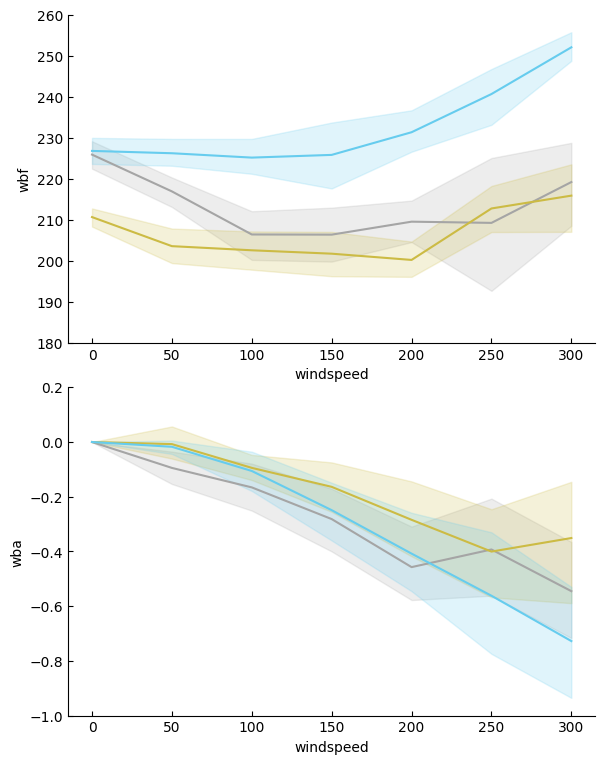

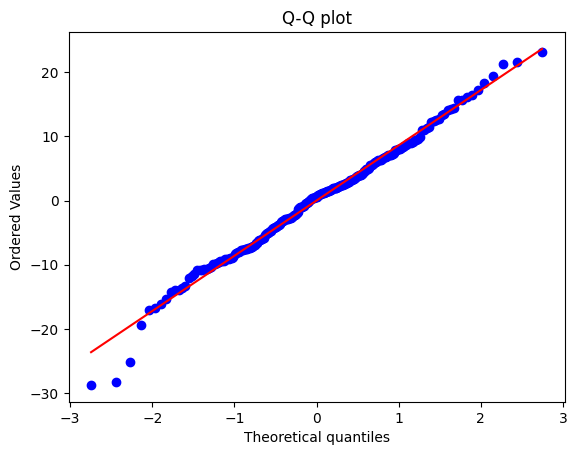

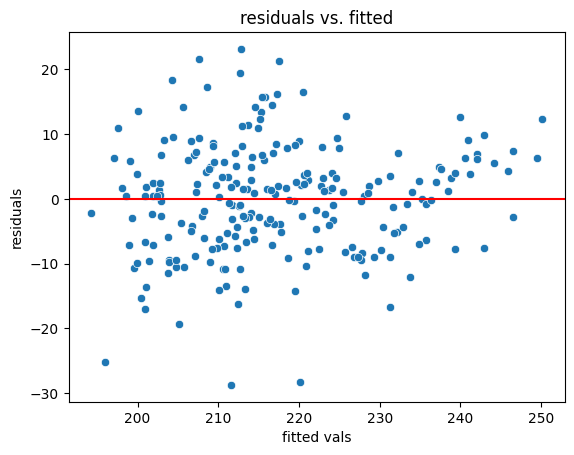

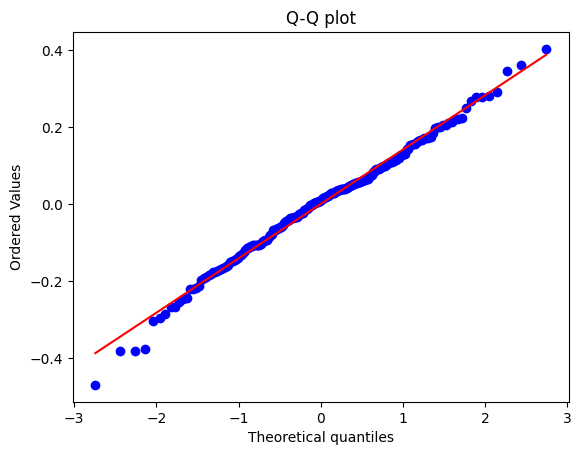

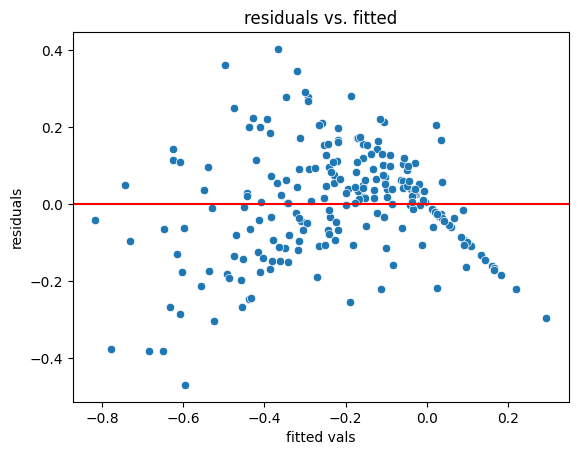

In [7]:
bcyan = np.array([102,204,238])/255
byellow = np.array([204,187,68])/255
vgrey = np.array([165,165,165])/255
palette = [vgrey, byellow,bcyan]
catg_names = ['0', '50', '100', '150', '200', '250', '300']
conditions = ['silencedCS','silenced','silencedCS_glued']
fig1, (ax1,ax2) = plt.subplots(2,1,figsize=(6,7.6),gridspec_kw={})
#fig2, ax2 = plt.subplots(1,1,figsize=(5.5,4.5),gridspec_kw={})
fig1.tight_layout()
#fig2.tight_layout()
absolute=False
df_wba_plots = []
df_wbf_plots = []
for j, condition in enumerate(conditions):
    fl_df_condition = fl_df[fl_df['condition'] == condition]
    col_list_wba = [stim + '_Flight_' + 'wba' for stim in const.stimNames]
    col_list_wbf = [stim + '_Flight_' + 'wbf' for stim in const.stimNames]
    catg_names = ['0','50','100','150','200','250','300']
    wba_df = pd.DataFrame()
    wbf_df = pd.DataFrame()
    for i in range(len(const.stimNames)):
        wba_df[catg_names[i]] = np.squeeze(np.nanmean(pf.extractConditionalAvgs(col_list_wba[i],fl_df_condition),axis=1) - np.nanmean(pf.extractConditionalAvgs(col_list_wba[0], fl_df_condition), axis=1))
        wbf_df[catg_names[i]] = np.squeeze(np.nanmean(pf.extractConditionalAvgs(col_list_wbf[i],fl_df_condition),axis=1))
    max_values = np.array([np.nanmax(row[1]) for row in wba_df.iterrows()])
    min_values = np.array([np.nanmin(row[1]) for row in wba_df.iterrows()])
    for col in catg_names:
        #wba_df[col] = 1 - ((wba_df[col] - min_values)/(max_values-min_values))
        wba_df[col] = wba_df[col] * -1
        
    df_wba =pd.melt(wba_df, var_name='windspeed',value_name='wba',ignore_index=False)
    df_wbf =pd.melt(wbf_df, var_name='windspeed',value_name='wbf',ignore_index=False)
    df_wba
    df_wba['index'] = df_wba.index
    df_wbf['index'] = df_wbf.index
    df_wba['condition'] = condition
    df_wbf['condition'] = condition
    df_wba = df_wba.reset_index(drop=True)
    df_wbf = df_wbf.reset_index(drop=True)
    df_wbf_plots.append(df_wbf)
    df_wba_plots.append(df_wba)

df_wbf_final = pd.concat(df_wbf_plots).reset_index()

#df_wbf_final = df_wbf_final[df_wbf_final['index'] != 7] 
#df_wba_final = df_wba_final[df_wba_final['index'] != 7]

df_wba_final = pd.concat(df_wba_plots).reset_index()
p_wbf = sns.lineplot(x='windspeed',y='wbf', hue='condition',palette=palette,data=df_wbf_final, ax=ax1)
p_wba = sns.lineplot(x='windspeed',y='wba', hue='condition',palette=palette,data=df_wba_final, ax=ax2)
#ax2.axhline(0,ls='--',lw=2,c='k',alpha=0.8)
#p = sns.lineplot(data=df_final, x='windspeed',y='iaa',hue='condition',ax=ax1,palette=palette,lw=2,errorbar=('se',2))

ax1.legend().set_visible(False)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_ylim([180, 260])
ax1.tick_params(direction="in")

ax2.legend().set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_ylim([-1,0.2])
ax2.set_yticks([-1,-0.8,-0.6,-0.4,-0.2,0,0.2])
ax2.tick_params(direction="in")
#################################
print('WBF')
print('---------------------------------------')
df_wbf_final = df_wbf_final.dropna()
df_wbf_final['subject_uid'] = df_wbf_final['index'].astype(str) + "_" + df_wbf_final['condition'].astype(str)
df_wbf_final['windspeed'] = df_wbf_final['windspeed'].astype(int)
df_wbf_final['condition'] = pd.Categorical(
    df_wbf_final['condition'],
    categories = ['silencedCS', 'silenced', 'silencedCS_glued'],
    ordered=True
)
model = smf.mixedlm("wbf ~ windspeed * condition",
                    df_wbf_final,
                    groups=df_wbf_final["subject_uid"])
                    #re_formula="~windspeed_num")

result = model.fit()
print(result.params)
print(result.bse)
print(result.tvalues)
print(result.pvalues)
print(result.summary())

params = result.params
cov = result.cov_params()
residuals = result.resid
fig_qq, ax_qq = plt.subplots()
stats.probplot(residuals, dist="norm",plot=ax_qq)
ax_qq.set_title('Q-Q plot')
fig_qq.savefig('qq_wbf_silencing.pdf')
fitted = result.fittedvalues
fig_rvf, ax_rvf = plt.subplots()
sns.scatterplot(x=fitted,y=residuals,ax=ax_rvf)
ax_rvf.axhline(0,color='r')
ax_rvf.set_xlabel('fitted vals')
ax_rvf.set_ylabel('residuals')
ax_rvf.set_title('residuals vs. fitted')
fig_rvf.savefig('rvf_wbf_silencing.pdf')


windspeeds = np.array([0, 50, 100, 150, 200, 250, 300])

comparisons = []

for cond in ['silenced', 'silencedCS_glued']:
    for ws in windspeeds:
        # Get contrast: difference in estimated means vs control
        delta = params[f'condition[T.{cond}]'] + ws * params[f'windspeed:condition[T.{cond}]']
        
        # Compute SE via delta method
        var = (
            cov.loc[f'condition[T.{cond}]', f'condition[T.{cond}]'] +
            ws**2 * cov.loc[f'windspeed:condition[T.{cond}]', f'windspeed:condition[T.{cond}]'] +
            2 * ws * cov.loc[f'condition[T.{cond}]', f'windspeed:condition[T.{cond}]']
        )
        se = np.sqrt(var)
        
        z = delta / se
        p = 2 * (1 - stats.norm.cdf(abs(z)))
        
        comparisons.append({
            'condition_vs_control': cond,
            'windspeed': ws,
            'contrast': delta,
            'SE': se,
            'z': z,
            'p': p
        })

results_df = pd.DataFrame(comparisons)
results_df['p_corr'] = statsmodels.stats.multitest.multipletests(results_df['p'], method='holm')[1]
print(results_df.round(4))
"""
model = ols(
    'wbf ~ C(condition) + C(windspeed) +\
    C(condition):C(windspeed)', data=df_wbf_final).fit()

print('wbf')
print('-------------------------------')
result = sm.stats.anova_lm(model,type=2)
print(result)
print()

ts = np.zeros((3,7))
ps = np.zeros((3,7))
for i, windspeed in enumerate(catg_names):

    num_tests = len(catg_names)
    ws_df = df_wbf_final.loc[(df_wbf_final['windspeed'] == windspeed)]
    ws_df_clean = ws_df.filter(items=['wbf','condition']).dropna()
    silencedCS_glued = ws_df_clean[ws_df_clean['condition'] == 'silencedCS_glued']
    silencedCS = ws_df_clean[ws_df_clean['condition'] == 'silencedCS']
    silenced = ws_df_clean[ws_df_clean['condition'] == 'silenced']
    ans_control_opto = stats.ttest_ind(silencedCS['wbf'],silenced['wbf'])
    ans_control_glued = stats.ttest_ind(silencedCS['wbf'],silencedCS_glued['wbf'])
    ans_opto_glued = stats.ttest_ind(silenced['wbf'],silencedCS_glued['wbf'])
    ts[0,i] = ans_control_opto[0]
    ps[0,i] = ans_control_opto[1]
    ts[1,i] = ans_control_glued[0]
    ps[1,i] = ans_control_glued[1]
    ts[2,i] = ans_opto_glued[0]
    ps[2,i] = ans_opto_glued[1]

flattened_ps = ps.flatten()
#results = statsmodels.stats.multitest.multipletests(ps,alpha=0.05,method='fdr_bh')
flattened_new_ps = stats.false_discovery_control(flattened_ps)
new_ps = flattened_new_ps.reshape([3,7])
for i, windspeed in enumerate(catg_names):                                
    print('windspeed = '+ windspeed)
    print('control x opto')
    print('t='+str(ts[0,i]) + ' q=' + str(new_ps[0,i]))
    print('------')
    print('control x glued')
    print('t='+str(ts[1,i]) + ' q=' + str(new_ps[1,i]))
    print('------')
    print('opto x glued')
    print('t='+str(ts[2,i]) + ' q=' + str(new_ps[2,i])+'\n')

print("\nSimple effects of windspeed at each level of condition:")
for condition in df_wbf_final['condition'].unique():
    subset = df_wbf_final[df_wbf_final['condition'] == condition]
    model_simple = ols('wbf ~ windspeed', data=subset).fit()
    anova_simple = sm.stats.anova_lm(model_simple, typ=2)
    print(f"Level condition = {condition}:")
    print(anova_simple)

print("\nSimple effects of condition at each level of windspeed:")
for windspeed in df_wbf_final['windspeed'].unique():
    subset = df_wbf_final[df_wbf_final['windspeed'] == windspeed]
    model_simple = ols('wbf ~ condition', data=subset).fit()
    anova_simple = sm.stats.anova_lm(model_simple, typ=2)
    print(f"Level windspeed = {windspeed}:")
    print(anova_simple)
    
print()
"""
####################################
print('WBA')
print('---------------------------------------')
df_wba_final = df_wba_final.dropna()
df_wba_final['subject_uid'] = df_wba_final['index'].astype(str) + "_" + df_wba_final['condition'].astype(str)
df_wba_final['windspeed'] = df_wba_final['windspeed'].astype(int)
df_wba_final['condition'] = pd.Categorical(
    df_wba_final['condition'],
    categories = ['silencedCS', 'silenced', 'silencedCS_glued'],
    ordered=True
)
model = smf.mixedlm("wba ~ windspeed * condition",
                    df_wba_final,
                    groups=df_wba_final["subject_uid"])
                    #re_formula="~windspeed_num")

result = model.fit()
print(result.summary())
print(result.params)
print(result.bse)
print(result.tvalues)
print(result.pvalues)
params = result.params
cov = result.cov_params()
residuals = result.resid
fig_qq, ax_qq = plt.subplots()
stats.probplot(residuals, dist="norm",plot=ax_qq)
ax_qq.set_title('Q-Q plot')
fig_qq.savefig('qq_wba_silencing.pdf')
fitted = result.fittedvalues
fig_rvf, ax_rvf = plt.subplots()
sns.scatterplot(x=fitted,y=residuals,ax=ax_rvf)
ax_rvf.axhline(0,color='r')
ax_rvf.set_xlabel('fitted vals')
ax_rvf.set_ylabel('residuals')
ax_rvf.set_title('residuals vs. fitted')
fig_rvf.savefig('rvf_wba_silencing.pdf')


windspeeds = np.array([0, 50, 100, 150, 200, 250, 300])

comparisons = []

for cond in ['silenced', 'silencedCS_glued']:
    for ws in windspeeds:
        # Get contrast: difference in estimated means vs control
        delta = params[f'condition[T.{cond}]'] + ws * params[f'windspeed:condition[T.{cond}]']
        
        # Compute SE via delta method
        var = (
            cov.loc[f'condition[T.{cond}]', f'condition[T.{cond}]'] +
            ws**2 * cov.loc[f'windspeed:condition[T.{cond}]', f'windspeed:condition[T.{cond}]'] +
            2 * ws * cov.loc[f'condition[T.{cond}]', f'windspeed:condition[T.{cond}]']
        )
        se = np.sqrt(var)
        
        z = delta / se
        p = 2 * (1 - stats.norm.cdf(abs(z)))
        
        comparisons.append({
            'condition_vs_control': cond,
            'windspeed': ws,
            'contrast': delta,
            'SE': se,
            'z': z,
            'p': p
        })

results_df = pd.DataFrame(comparisons)
results_df = results_df[results_df['windspeed'] != 0]
results_df['p_corr'] = statsmodels.stats.multitest.multipletests(results_df['p'], method='holm')[1]
print(results_df.round(4))

"""
model = ols(
    'wba ~ C(condition) + C(windspeed) +\
    C(condition):C(windspeed)', data=df_wba_final).fit()

print('wba')
print('-------------------------------')
result = sm.stats.anova_lm(model,type=2)
print(result)
print()

ts = np.zeros((3,6))
ps = np.zeros((3,6))
for i, windspeed in enumerate(catg_names[1:]):

    num_tests = len(catg_names[1:])
    ws_df = df_wba_final.loc[(df_wba_final['windspeed'] == windspeed)]
    ws_df_clean = ws_df.filter(items=['wba','condition']).dropna()
    silencedCS_glued = ws_df_clean[ws_df_clean['condition'] == 'silencedCS_glued']
    silencedCS = ws_df_clean[ws_df_clean['condition'] == 'silencedCS']
    silenced = ws_df_clean[ws_df_clean['condition'] == 'silenced']
    ans_control_opto = stats.ttest_ind(silencedCS['wba'],silenced['wba'])
    ans_control_glued = stats.ttest_ind(silencedCS['wba'],silencedCS_glued['wba'])
    ans_opto_glued = stats.ttest_ind(silenced['wba'],silencedCS_glued['wba'])
    ts[0,i] = ans_control_opto[0]
    ps[0,i] = ans_control_opto[1]
    ts[1,i] = ans_control_glued[0]
    ps[1,i] = ans_control_glued[1]
    ts[2,i] = ans_opto_glued[0]
    ps[2,i] = ans_opto_glued[1]

flattened_ps = ps.flatten()
#results = statsmodels.stats.multitest.multipletests(ps,alpha=0.05,method='fdr_bh')
flattened_new_ps = stats.false_discovery_control(flattened_ps)
new_ps = flattened_new_ps.reshape([3,6])
for i, windspeed in enumerate(catg_names[1:]):                                
    print('windspeed = '+ windspeed)
    print('control x opto')
    print('t='+str(ts[0,i]) + ' q=' + str(new_ps[0,i]))
    print('------')
    print('control x glued')
    print('t='+str(ts[1,i]) + ' q=' + str(new_ps[1,i]))
    print('------')
    print('opto x glued')
    print('t='+str(ts[2,i]) + ' q=' + str(new_ps[2,i])+'\n')

"""
###########################
fig1.savefig(const.savedFigureDirectory+'4EF'+'.pdf',format='pdf')
#fig2.savefig(const.savedFigureDirectory+'wba_silenced'+'.pdf',format='pdf')

## Miscellaneous

no flight
------------------------
                              df        sum_sq      mean_sq           F  \
C(condition)                 1.0      0.952709     0.952709    0.105846   
C(windspeed)                 5.0  11421.395973  2284.279195  253.783503   
C(condition):C(windspeed)    5.0      8.080905     1.616181    0.179558   
Residual                   162.0   1458.145331     9.000897         NaN   

                                 PR(>F)  
C(condition)               7.453437e-01  
C(windspeed)               1.090783e-74  
C(condition):C(windspeed)  9.699629e-01  
Residual                            NaN  
50
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.465     0.606    -1.361     2.291
 (1 - 0)     -0.465     0.606    -2.291     1.361

100
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.876     0.482    -1

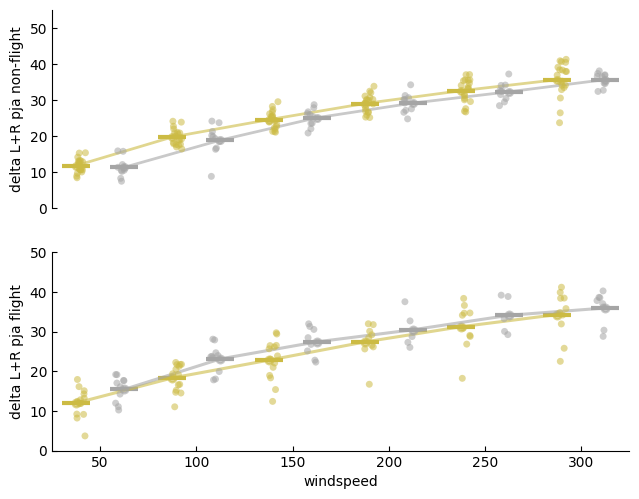

In [6]:
catg_names = ['0', '50', '100', '150', '200', '250', '300']
flight_conditions = ['silenced','silencedCS']
noFlight_conditions = ['silenced','silencedCS']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6.5,5),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
print('no flight')
print('------------------------')
for j, condition in enumerate(noFlight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    #col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,1]
        line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    df_3rd['Antennal Segment'] = '3rd Segment'
    df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_3rd['iaa'] - df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
df_final = df_final[df_final['windspeed'] != '0']
df_final = df_final[df_final['index'] != 14]
byellow = np.array([204,187,68])/255
vgrey = np.array([165,165,165])/255
palette = [byellow,vgrey]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,alpha=0.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.5,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p3 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.5,lw=2,alpha=0.6,errorbar=None)
#ax1.xaxis.set_visible(False)
ax1.tick_params(direction="in")
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([0,55])
ax1.set_ylabel('delta L+R pja non-flight')
ax1.legend().set_visible(False)
ax1.xaxis.set_visible(False)
ax1.set_yticks([0,10,20,30,40,50])

model = ols(
    'iaa ~ C(condition) + C(windspeed) +\
    C(condition):C(windspeed)', data=df_final).fit()
result = sm.stats.anova_lm(model,type=2)
print(result)

for windspeed in catg_names[1:]:
    ws_df = df_final.loc[(df_final['windspeed'] == windspeed)]
    ws_df_clean = ws_df.filter(items=['iaa','condition']).dropna()
    silenced = ws_df_clean[ws_df_clean['condition'] == 'silenced']
    silencedCS = ws_df_clean[ws_df_clean['condition'] == 'silencedCS']
    
    ans1 = stats.tukey_hsd(silenced['iaa'],silencedCS['iaa'])
    print(windspeed)
    print(ans1)
    
df_plots = []
print('\n\n')
print('flight')
print('-----------------------------')
for j, condition in enumerate(flight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    #col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_flight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,1]
        line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    df_3rd['Antennal Segment'] = '3rd Segment'
    df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_3rd['iaa'] - df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
df_final = df_final[df_final['windspeed'] != '0']
df_final = df_final[df_final['index'] != 14]
#df_final = df_final[df_final['index'] != 15] 
#df_final = df_final[df_final['index'] != 16] 
#df_final = df_final[df_final['index'] != 13] 
byellow = np.array([204,187,68])/255
vgrey = np.array([165,165,165])/255
palette = [byellow,vgrey]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,alpha=0.55)
#p = sns.violinplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,split=True,gap=.3,inner="point")
#p2 = sns.boxplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.5,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p3 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.5,lw=2.2,alpha=0.6,errorbar=None)
#ax2.set_ylim([0,55])
ax2.set_ylabel('delta L+R pja flight')
ax2.tick_params(direction="in")
ax2.spines[['right', 'top']].set_visible(False)
ax2.legend().set_visible(False)
ax2.set_yticks([0,10,20,30,40,50])

model = ols(
    'iaa ~ C(condition) + C(windspeed) +\
    C(condition):C(windspeed)', data=df_final).fit()
result = sm.stats.anova_lm(model,type=2)
print(result)

for windspeed in catg_names[1:]:
    ws_df = df_final.loc[(df_final['windspeed'] == windspeed)]
    ws_df_clean = ws_df.filter(items=['iaa','condition']).dropna()
    silenced = ws_df_clean[ws_df_clean['condition'] == 'silenced']
    silencedCS = ws_df_clean[ws_df_clean['condition'] == 'silencedCS']
    
    ans1 = stats.tukey_hsd(silenced['iaa'],silencedCS['iaa'])
    print(windspeed)
    print(ans1)
    
savename = 'passiveJointSilenced'
fig.savefig(const.savedFigureDirectory+'png/'+savename+'.png',format='png')
fig.savefig(const.savedFigureDirectory+savename+'.pdf',format='pdf')

-1.660115532257189 0.10805124296671156
-2.911520981166333 0.0074606298834144


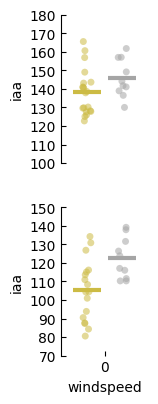

In [10]:
catg_names = ['0']
flight_conditions = ['silenced', 'silencedCS']
noFlight_conditions = ['silenced', 'silencedCS']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(1.6,4),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
for j, condition in enumerate(noFlight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    #col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
byellow = np.array([204,187,68])/255
vgrey = np.array([165,165,165])/255
palette = [byellow,vgrey]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,legend=False,alpha=.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
ax1.legend().set_visible(False)
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([100, 180])
ax1.set_yticks([100,110,120,130,140,150,160,170,180])
ax1.tick_params(direction="in")
ax1.xaxis.set_visible(False)

dark =df_final.loc[(df_final['condition']=='silenced')]
static =df_final.loc[(df_final['condition']=='silencedCS')]
    
ans = stats.ttest_ind(dark['iaa'],static['iaa'],nan_policy='omit')
print(str(ans[0]) + ' ' + str(ans[1]))

###########################
df_plots = []
for j, condition in enumerate(flight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    col_list_flight = ['0_Flight']
    #col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_flight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
k = np.array([0,0,0])/255
byellow = np.array([204,187,68])/255
vgrey = np.array([165,165,165])/255
palette = [byellow,vgrey]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,legend=False,alpha=.55)
#p = sns.violinplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,split=True,gap=.3,inner="point")
#p2 = sns.boxplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
ax2.legend().set_visible(False)
ax2.spines[['right', 'top','bottom']].set_visible(False)
ax2.set_ylim([70, 150])
ax2.set_yticks([70,80,90,100,110,120,130,140,150])
ax2.tick_params(direction="in")

dark =df_final.loc[(df_final['condition']=='silenced')]
static =df_final.loc[(df_final['condition']=='silencedCS')]
    
ans = stats.ttest_ind(dark['iaa'],static['iaa'],nan_policy='omit')
print(str(ans[0]) + ' ' + str(ans[1]))


fig.savefig(const.savedFigureDirectory+'png/'+'2ndSegSilenced_zero'+'.png',format='png')
fig.savefig(const.savedFigureDirectory+'2ndSegSilenced_zero'+'.pdf',format='pdf')

50 -3.250845330837519 0.001966751453252703
100 -6.062830673470074 1.2733589816126498e-07
150 -7.052625906772967 3.0928353711515095e-09
200 -7.5631455990578145 4.5089601352831975e-10
250 -7.412220918869484 7.964665424223594e-10
300 -6.7012501938077875 1.163186752776858e-08
50 -1.530088915142641 0.13331889785964474
100 -2.563032311590856 0.014143314338309834
150 -3.59116140174383 0.0009749374691116224
200 -3.3285930368448797 0.0021545734362910076
250 -4.223429399815737 0.00020595075668225347
300 -5.498848749484546 2.5696740784031436e-06


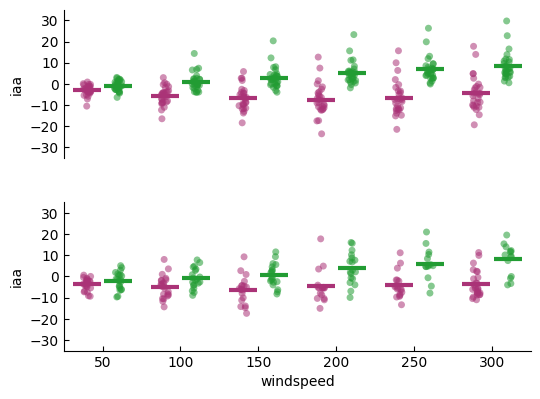

In [5]:
catg_names = ['0', '50', '100', '150', '200', '250', '300']
flight_conditions = ['static', 'silenced']
noFlight_conditions = ['static', 'silenced']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(5.4,4),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
for j, condition in enumerate(noFlight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    #col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot[df_plot['windspeed'] != '0']
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
bpurp = np.array([170,51,119])/255
palette = [bgreen, byellow]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,legend=False,alpha=.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
ax1.legend().set_visible(False)
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([-35, 35])
ax1.set_yticks([-30, -20,-10,0,10,20,30])
ax1.tick_params(direction="in")
ax1.xaxis.set_visible(False)

for windspeed in catg_names[1:]:
    dark =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='dark')]
    static =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='static')]
    
    ans = stats.ttest_ind(dark['iaa'],static['iaa'],nan_policy='omit')
    print(windspeed + ' ' + str(ans[0]) + ' ' + str(ans[1]))
    

###########################
df_plots = []
for j, condition in enumerate(flight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    #col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_flight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot[df_plot['windspeed'] != '0']
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
bpurp = np.array([170,51,119])/255
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
k = np.array([0,0,0])/255
w = np.array([255,255,255])/255
palette = [bgreen, byellow]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,legend=False,alpha=0.55)
#p = sns.violinplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,split=True,gap=.3,inner="point")
#p2 = sns.boxplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
ax2.legend().set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_ylim([-35, 35])
ax2.set_yticks([-30, -20,-10,0,10,20,30])
ax2.tick_params(direction="in")


for windspeed in catg_names[1:]:
    static =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='static')]
    silenced =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='silenced')]
    
    ans = stats.ttest_ind(dark['iaa'],static['iaa'],nan_policy='omit')
    print(windspeed + ' ' + str(ans[0]) + ' ' + str(ans[1]))
    

fig.savefig(const.savedFigureDirectory+'png/'+'2ndSegStaticVSilenced'+'.png',format='png')
fig.savefig(const.savedFigureDirectory+'2ndSegStaticVSilenced'+'.pdf',format='pdf')

50 4.55449406072379 0.0013770615199642493
100 3.9625202546340037 0.0032916909508404115
150 3.3921623498660445 0.007971729748068888
200 3.6503071284132167 0.005314988845733138
250 3.9900553090023814 0.003157468072353367
300 5.2385015792294745 0.0005358286793081733


4.984499999999997

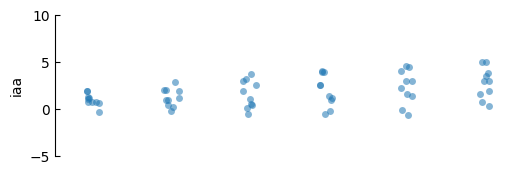

In [4]:
catg_names = ['0', '50', '100', '150', '200', '250', '300']
noFlight_conditions = ['dead']
fig, ax1 = plt.subplots(figsize=(5.4,2))
fig.tight_layout()
absolute=False
df_plots = []
for j, condition in enumerate(noFlight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    #col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot[df_plot['windspeed'] != '0']
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
bpurp = np.array([170,51,119])/255
palette = [bpurp, bgreen]
p = sns.stripplot(x='windspeed',y='iaa',data=df_final, ax=ax1,dodge=True,alpha=.55)
#p2 = sns.pointplot(x='windspeed',y='iaa',data=df_final, ax=ax1,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([-5, 10])
ax1.tick_params(direction="in")
ax1.xaxis.set_visible(False)

for windspeed in catg_names[1:]:
    dead =df_final.loc[(df_final['windspeed'] == windspeed)]
    
    ans = stats.ttest_1samp(dead['iaa'],0,nan_policy='omit')
    print(windspeed + ' ' + str(ans[0]) + ' ' + str(ans[1]))
    
fig.savefig(const.savedFigureDirectory+'png/'+'2ndSegdead'+'.png',format='png')
fig.savefig(const.savedFigureDirectory+'2ndSegdead'+'.pdf',format='pdf')

np.nanmax(df_final[df_final['windspeed'] == '300']['iaa'])

-7.526564287192544 5.754782957467424e-10
-7.631728303179749 7.966071519272071e-10


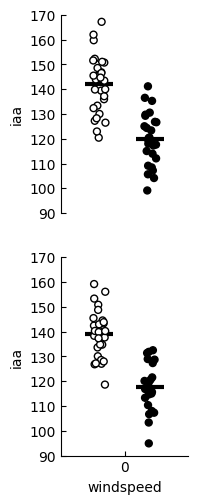

In [6]:
catg_names = ['0']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(2,5),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
states = ['noFlight', 'flight']
for j, state in enumerate(states):
    df_condition = df[df['condition'] == 'dark']
    line_df_2nd = pd.DataFrame()
    col_list_flight = ['0_Flight']
    col_list_noFlight =  ['0_noFlight']
    col_list = [col_list_noFlight, col_list_flight]
    for i, col in enumerate(col_list[j]):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] # - np.nanmean(pf.extractConditionalAvgs(col_list[j][0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = state
    #df_plot = df_plot[df_plot['windspeed'] != '0']
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
bpurp = np.array([170,51,119])/255
palette = [np.array([1,1,1]), np.array([0,0,0])]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,legend=False,linewidth=1)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=[np.array([0,0,0]),np.array([0,0,0])],dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
ax1.legend().set_visible(False)
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([90, 170])
ax1.set_yticks([90, 100,110,120,130,140,150,160,170])
ax1.tick_params(direction="in")
ax1.xaxis.set_visible(False)

dark =df_final.loc[(df_final['condition']=='flight')]
static =df_final.loc[(df_final['condition']=='noFlight')]
    
ans = stats.ttest_ind(dark['iaa'],static['iaa'],nan_policy='omit')
print(str(ans[0]) + ' ' + str(ans[1]))

###########################
df_plots = []
states = ['noFlight', 'flight']
for j, state in enumerate(states):
    df_condition = df[df['condition'] == 'static']
    line_df_2nd = pd.DataFrame()
    col_list_flight = ['0_Flight']
    col_list_noFlight =  ['0_noFlight']
    col_list = [col_list_noFlight, col_list_flight]
    for i, col in enumerate(col_list[j]):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] #- np.nanmean(pf.extractConditionalAvgs(col_list[j][0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = state
    # df_plot = df_plot[df_plot['windspeed'] != '0']
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
bpurp = np.array([170,51,119])/255
palette = [np.array([1,1,1]), np.array([0,0,0])]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,linewidth=1)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=[np.array([0,0,0]),np.array([0,0,0])],dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
ax2.legend().set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_ylim([90, 170])
ax2.set_yticks([90, 100,110,120,130,140,150,160,170])
ax2.tick_params(direction="in")

dark =df_final.loc[(df_final['condition']=='flight')]
static =df_final.loc[(df_final['condition']=='noFlight')]
    
ans = stats.ttest_ind(dark['iaa'],static['iaa'],nan_policy='omit')
print(str(ans[0]) + ' ' + str(ans[1]))

fig.savefig(const.savedFigureDirectory+'png/'+'f_nf_zero'+'.png',format='png')
fig.savefig(const.savedFigureDirectory+'f_nf_zero'+'.pdf',format='pdf')

50 1.0786625238921368 0.2859145107704582
100 -0.5518399738660588 0.5835661784070941
150 -0.11478999847703898 0.9091222503800382
200 -1.20150597149949 0.23613097697142058
250 -1.088890119333598 0.28213058337043423
300 -0.3282577302797286 0.744010180154513
50 1.3315267302760692 0.1893048891952485
100 1.5708606443371258 0.12292359863507443
150 1.6231726964583422 0.11138677923277295
200 0.8128226356959174 0.42059938752623727
250 0.4425763756876141 0.6603983372427489
300 0.12922077624940867 0.8978148061934934


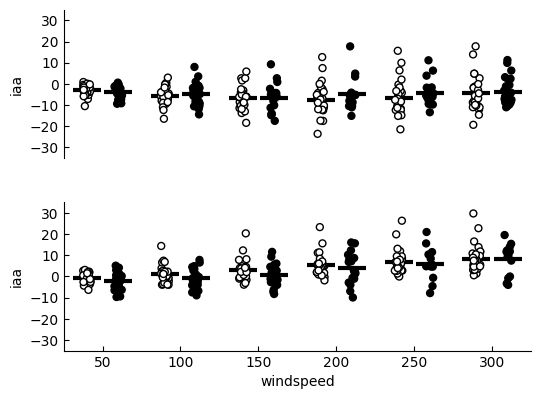

In [7]:
catg_names = ['0', '50', '100', '150', '200', '250', '300']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(5.4,4),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
states = ['noFlight', 'flight']
for j, state in enumerate(states):
    df_condition = df[df['condition'] == 'dark']
    line_df_2nd = pd.DataFrame()
    col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    col_list = [col_list_noFlight, col_list_flight]
    for i, col in enumerate(col_list[j]):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list[j][0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = state
    df_plot = df_plot[df_plot['windspeed'] != '0']
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
bpurp = np.array([170,51,119])/255
palette = [np.array([1,1,1]), np.array([0,0,0])]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,legend=False,linewidth=1)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=[np.array([0,0,0]),np.array([0,0,0])],dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
ax1.legend().set_visible(False)
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([-35, 35])
ax1.set_yticks([-30, -20,-10,0,10,20,30])
ax1.tick_params(direction="in")
ax1.xaxis.set_visible(False)

for windspeed in catg_names[1:]:
    dark =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='noFlight')]
    static =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='flight')]
    
    ans = stats.ttest_ind(dark['iaa'],static['iaa'],nan_policy='omit')
    print(windspeed + ' ' + str(ans[0]) + ' ' + str(ans[1])) 

###########################
df_plots = []
states = ['noFlight', 'flight']
for j, state in enumerate(states):
    df_condition = df[df['condition'] == 'static']
    line_df_2nd = pd.DataFrame()
    col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    col_list = [col_list_noFlight, col_list_flight]
    for i, col in enumerate(col_list[j]):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list[j][0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = state
    df_plot = df_plot[df_plot['windspeed'] != '0']
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
bpurp = np.array([170,51,119])/255
palette = [np.array([1,1,1]), np.array([0,0,0])]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,linewidth=1)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=[np.array([0,0,0]),np.array([0,0,0])],dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
ax2.legend().set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_ylim([-35, 35])
ax2.set_yticks([-30, -20,-10,0,10,20,30])
ax2.tick_params(direction="in")

for windspeed in catg_names[1:]:
    dark =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='noFlight')]
    static =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='flight')]
    
    ans = stats.ttest_ind(dark['iaa'],static['iaa'],nan_policy='omit')
    print(windspeed + ' ' + str(ans[0]) + ' ' + str(ans[1]))

fig.savefig(const.savedFigureDirectory+'png/'+'f_nf'+'.png',format='png')
fig.savefig(const.savedFigureDirectory+'f_nf'+'.pdf',format='pdf')

no flight
------------------------
                              df        sum_sq      mean_sq          F  \
C(condition)                 2.0    922.945519   461.472760  19.291458   
C(windspeed)                 5.0  11567.839200  2313.567840  96.716646   
C(condition):C(windspeed)   10.0    941.171582    94.117158   3.934484   
Residual                   146.0   3492.479499    23.921092        NaN   

                                 PR(>F)  
C(condition)               3.679414e-08  
C(windspeed)               1.513780e-44  
C(condition):C(windspeed)  9.232131e-05  
Residual                            NaN  
50
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      2.552     0.021     0.349     4.754
 (0 - 2)      1.770     0.089    -0.228     3.769
 (1 - 0)     -2.552     0.021    -4.754    -0.349
 (1 - 2)     -0.781     0.654    -2.984     1.421
 (2 - 0)     -1.770     0.089    -3.769     0.228
 (2 - 1)     

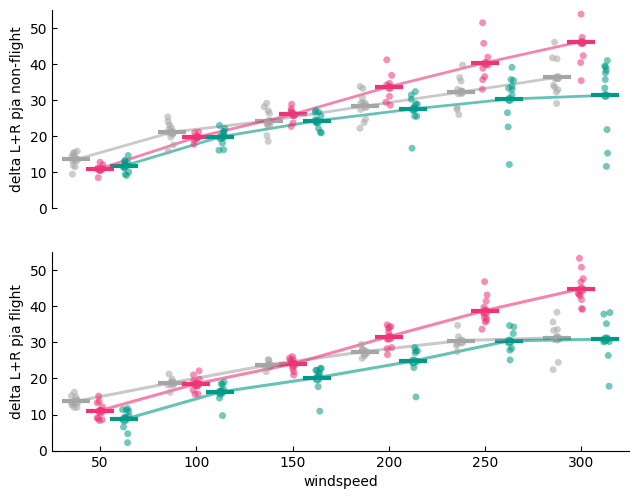

In [16]:
catg_names = ['0', '50', '100', '150', '200', '250', '300']
flight_conditions = ['ChrimCS','18D07', '74C10']
noFlight_conditions = ['ChrimCS','18D07', '74C10']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6.5,5),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
print('no flight')
print('------------------------')
for j, condition in enumerate(noFlight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    #col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,1]
        line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    df_3rd['Antennal Segment'] = '3rd Segment'
    df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_3rd['iaa'] - df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
df_final = df_final[df_final['windspeed'] != '0'] 
vteal = np.array([0,153,136])/255
vmagenta = np.array([238,51,119])/255
vgrey = np.array([165,165,165])/255
palette = [vgrey,vmagenta,vteal]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,alpha=0.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.5,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p3 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.5,lw=2,alpha=0.6,errorbar=None)
#ax1.xaxis.set_visible(False)
ax1.tick_params(direction="in")
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([0,55])
ax1.set_ylabel('delta L+R pja non-flight')
ax1.legend().set_visible(False)
ax1.xaxis.set_visible(False)
ax1.set_yticks([0,10,20,30,40,50])

model = ols(
    'iaa ~ C(condition) + C(windspeed) +\
    C(condition):C(windspeed)', data=df_final).fit()
result = sm.stats.anova_lm(model,type=2)
print(result)

for windspeed in catg_names[1:]:
    ws_df = df_final.loc[(df_final['windspeed'] == windspeed)]
    ws_df_clean = ws_df.filter(items=['iaa','condition']).dropna()
    ChrimCS = ws_df_clean[ws_df_clean['condition'] == 'ChrimCS']
    g18D07 = ws_df_clean[ws_df_clean['condition'] == '18D07']
    g74C10 = ws_df_clean[ws_df_clean['condition'] == '74C10']
    
    ans1 = stats.tukey_hsd(ChrimCS['iaa'],g18D07['iaa'],g74C10['iaa'])
    print(windspeed)
    print(ans1)
    
df_plots = []
print('\n\n')
print('flight')
print('-----------------------------')
for j, condition in enumerate(flight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    #col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_flight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,1]
        line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    df_3rd['Antennal Segment'] = '3rd Segment'
    df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_3rd['iaa'] - df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
df_final = df_final[df_final['windspeed'] != '0'] 
vteal = np.array([0,153,136])/255
vmagenta = np.array([238,51,119])/255
vgrey = np.array([165,165,165])/255
palette = [vgrey,vmagenta,vteal]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,alpha=0.55)
#p = sns.violinplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,split=True,gap=.3,inner="point")
#p2 = sns.boxplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.5,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p3 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.5,lw=2.2,alpha=0.6,errorbar=None)
ax2.set_ylim([0,55])
ax2.set_ylabel('delta L+R pja flight')
ax2.tick_params(direction="in")
ax2.spines[['right', 'top']].set_visible(False)
ax2.legend().set_visible(False)
ax2.set_yticks([0,10,20,30,40,50])

model = ols(
    'iaa ~ C(condition) + C(windspeed) +\
    C(condition):C(windspeed)', data=df_final).fit()
result = sm.stats.anova_lm(model,type=2)
print(result)

for windspeed in catg_names[1:]:
    ws_df = df_final.loc[(df_final['windspeed'] == windspeed)]
    ws_df_clean = ws_df.filter(items=['iaa','condition']).dropna()
    ChrimCS = ws_df_clean[ws_df_clean['condition'] == 'ChrimCS']
    g18D07 = ws_df_clean[ws_df_clean['condition'] == '18D07']
    g74C10 = ws_df_clean[ws_df_clean['condition'] == '74C10']
    
    ans1 = stats.tukey_hsd(ChrimCS['iaa'],g18D07['iaa'],g74C10['iaa'])
    print(windspeed)
    print(ans1)
    
savename = 'passiveJoint18D07vs74C10'
fig.savefig(const.savedFigureDirectory+'png/'+savename+'.png',format='png')
fig.savefig(const.savedFigureDirectory+savename+'.pdf',format='pdf')

In [39]:
np.nanmean(pf.extractConditionalAvgs('0_vdist_Flight', df[df['condition'] == 'ChrimCS']),axis=1)
np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[1], df[df['condition'] == 'ChrimCS']),axis=1)
np.nanmean(pf.extractConditionalAvgs(col, df_condition),axis=1).tolist()
line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition),axis=1).tolist() #- np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition),axis=1)

no flight
------------------------
Controlx18D07, 50: t=-0.5222027212995354 p=0.6091553514237447
Controlx74C10, 50: t=0.6199379034697002 p=0.5430677644907065
18D07x74C10, 50: t=0.8180329903036977 p=0.4261427979783904

Controlx18D07, 100: t=0.09481639257616517 p=0.9257156993373186
Controlx74C10, 100: t=-0.3137982209510276 p=0.7572817801845798
18D07x74C10, 100: t=-0.4058529279680209 p=0.6905810981355441

Controlx18D07, 150: t=2.3037296105853997 p=0.03596405626416728
Controlx74C10, 150: t=1.8215880856399547 p=0.08517935807914613
18D07x74C10, 150: t=-0.4252547548613529 p=0.676688783564295

Controlx18D07, 200: t=2.4479799475379425 p=0.02714888163059204
Controlx74C10, 200: t=1.394488103219251 p=0.1801442894730573
18D07x74C10, 200: t=-0.496391249816944 p=0.6268135067210916

Controlx18D07, 250: t=2.8501600826731597 p=0.01157714077433473
Controlx74C10, 250: t=0.6747283742515349 p=0.5084228580708852
18D07x74C10, 250: t=-1.5939186251447135 p=0.13051494304857705

Controlx18D07, 300: t=1.2483310882

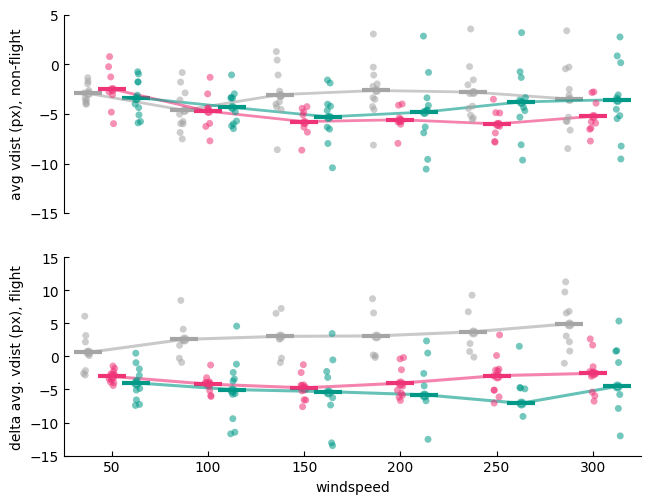

In [66]:
catg_names = ['0', '50', '100', '150', '200', '250', '300']
flight_conditions = ['ChrimCS','18D07', '74C10']
noFlight_conditions = ['ChrimCS','18D07', '74C10']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6.5,5),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
print('no flight')
print('------------------------')
for j, condition in enumerate(noFlight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    #col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_vdist_noFlight','50_vdist_noFlight','100_vdist_noFlight','150_vdist_noFlight','200_vdist_noFlight','250_vdist_noFlight','300_vdist_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd[catg_names[i]] = (np.nanmean(pf.extractConditionalAvgs(col, df_condition),axis=1) - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition),axis=1)).tolist()
        line_df_2nd[catg_names[i]] = line_df_2nd[catg_names[i]].apply(lambda x: x[0])
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]
    
    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='vdist',ignore_index=False)
    #df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    #df_3rd['Antennal Segment'] = '3rd Segment'
    #df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['vdist'] = df_2nd['vdist']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
df_final = df_final[df_final['windspeed'] != '0'] 
vteal = np.array([0,153,136])/255
vmagenta = np.array([238,51,119])/255
vgrey = np.array([165,165,165])/255
palette = [vgrey,vmagenta,vteal]
p = sns.stripplot(x='windspeed',y='vdist',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,alpha=0.55)
p2 = sns.pointplot(x='windspeed',y='vdist',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.5,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p3 = sns.pointplot(x='windspeed',y='vdist',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.5,lw=2,alpha=0.6,errorbar=None)
#ax1.xaxis.set_visible(False)
ax1.tick_params(direction="in")
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([-15,5])
ax1.set_ylabel('avg vdist (px), non-flight')
ax1.legend().set_visible(False)
ax1.xaxis.set_visible(False)
#ax1.set_yticks([0,10,20,30,40,50])
for windspeed in catg_names[1:]:
    g18D07 =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='18D07')]
    g74C10 =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='74C10')]
    ChrimCS =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='ChrimCS')]
    
    ans1 = stats.ttest_ind(ChrimCS['vdist'],g18D07['vdist'],nan_policy='omit')
    ans2 = stats.ttest_ind(ChrimCS['vdist'],g74C10['vdist'],nan_policy='omit')
    ans3 = stats.ttest_ind(g18D07['vdist'],g74C10['vdist'],nan_policy='omit')
    
    print('Controlx18D07, '+ windspeed + ': ' + 't='+str(ans1[0]) + ' p=' + str(ans1[1]))
    print('Controlx74C10, '+ windspeed + ': ' + 't='+str(ans2[0]) + ' p=' + str(ans2[1]))
    print('18D07x74C10, '+ windspeed + ': ' + 't='+str(ans3[0]) + ' p=' + str(ans3[1]))
    print()

df_plots = []
print('\n\n')
print('flight')
print('-----------------------------')
for j, condition in enumerate(flight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    col_list_flight = ['0_vdist_Flight','50_vdist_Flight','100_vdist_Flight','150_vdist_Flight','200_vdist_Flight','250_vdist_Flight','300_vdist_Flight']
    #col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_flight):
        line_df_2nd[catg_names[i]] = (np.nanmean(pf.extractConditionalAvgs(col, df_condition),axis=1) - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition),axis=1)).tolist()
        line_df_2nd[catg_names[i]] = line_df_2nd[catg_names[i]].apply(lambda x: x[0])
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='vdist',ignore_index=False)
    #df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    #df_3rd['Antennal Segment'] = '3rd Segment'
    #df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['vdist'] = df_2nd['vdist']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
df_final = df_final[df_final['windspeed'] != '0'] 
vteal = np.array([0,153,136])/255
vmagenta = np.array([238,51,119])/255
vgrey = np.array([165,165,165])/255
palette = [vgrey,vmagenta,vteal]
p = sns.stripplot(x='windspeed',y='vdist',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,alpha=0.55)
p2 = sns.pointplot(x='windspeed',y='vdist',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.5,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p3 = sns.pointplot(x='windspeed',y='vdist',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.5,lw=2.2,alpha=0.6,errorbar=None)
ax2.set_ylim([-15,15])
ax2.set_ylabel('delta avg. vdist (px), flight')
ax2.tick_params(direction="in")
ax2.spines[['right', 'top']].set_visible(False)
ax2.legend().set_visible(False)
#ax2.set_yticks([0,10,20,30,40,50])

for windspeed in catg_names[1:]:
    g18D07 =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='18D07')]
    g74C10 =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='74C10')]
    ChrimCS =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='ChrimCS')]
    
    ans1 = stats.ttest_ind(ChrimCS['vdist'],g18D07['vdist'],nan_policy='omit')
    ans2 = stats.ttest_ind(ChrimCS['vdist'],g74C10['vdist'],nan_policy='omit')
    ans3 = stats.ttest_ind(g18D07['vdist'],g74C10['vdist'],nan_policy='omit')
    
    print('Controlx18D07, '+ windspeed + ': ' + 't='+str(ans1[0]) + ' p=' + str(ans1[1]))
    print('Controlx74C10, '+ windspeed + ': ' + 't='+str(ans2[0]) + ' p=' + str(ans2[1]))
    print('18D07x74C10, '+ windspeed + ': ' + 't='+str(ans3[0]) + ' p=' + str(ans3[1]))
    print()

savename = 'vdist18D07vs74C10'
fig.savefig(const.savedFigureDirectory+'png/'+savename+'.png',format='png')
fig.savefig(const.savedFigureDirectory+savename+'.pdf',format='pdf')

no flight
------------------------
Controlx18D07, 50: t=-0.5222027212995354 p=0.6091553514237447
Controlx74C10, 50: t=0.6199379034697002 p=0.5430677644907065
18D07x74C10, 50: t=0.8180329903036977 p=0.4261427979783904

Controlx18D07, 100: t=0.09481639257616517 p=0.9257156993373186
Controlx74C10, 100: t=-0.3137982209510276 p=0.7572817801845798
18D07x74C10, 100: t=-0.4058529279680209 p=0.6905810981355441

Controlx18D07, 150: t=2.3037296105853997 p=0.03596405626416728
Controlx74C10, 150: t=1.8215880856399547 p=0.08517935807914613
18D07x74C10, 150: t=-0.4252547548613529 p=0.676688783564295

Controlx18D07, 200: t=2.4479799475379425 p=0.02714888163059204
Controlx74C10, 200: t=1.394488103219251 p=0.1801442894730573
18D07x74C10, 200: t=-0.496391249816944 p=0.6268135067210916

Controlx18D07, 250: t=2.8501600826731597 p=0.01157714077433473
Controlx74C10, 250: t=0.6747283742515349 p=0.5084228580708852
18D07x74C10, 250: t=-1.5939186251447135 p=0.13051494304857705

Controlx18D07, 300: t=1.2483310882

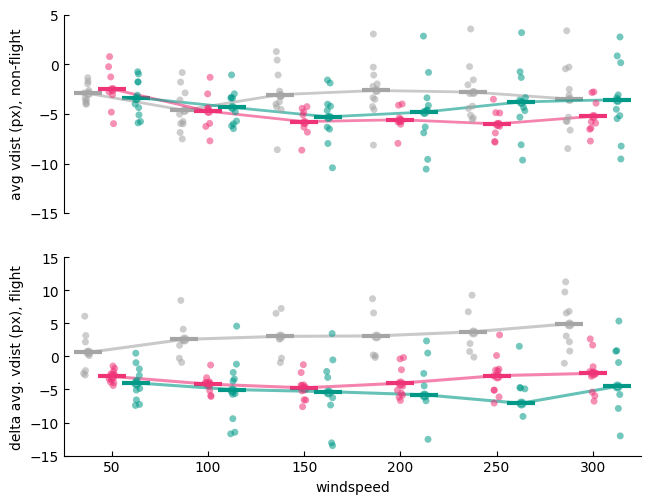

In [66]:
catg_names = ['0', '50', '100', '150', '200', '250', '300']
flight_conditions = ['ChrimCS','18D07', '74C10']
noFlight_conditions = ['ChrimCS','18D07', '74C10']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6.5,5),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
print('no flight')
print('------------------------')
for j, condition in enumerate(noFlight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    #col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_vdist_noFlight','50_vdist_noFlight','100_vdist_noFlight','150_vdist_noFlight','200_vdist_noFlight','250_vdist_noFlight','300_vdist_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd[catg_names[i]] = (np.nanmean(pf.extractConditionalAvgs(col, df_condition),axis=1) - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition),axis=1)).tolist()
        line_df_2nd[catg_names[i]] = line_df_2nd[catg_names[i]].apply(lambda x: x[0])
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]
    
    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='vdist',ignore_index=False)
    #df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    #df_3rd['Antennal Segment'] = '3rd Segment'
    #df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['vdist'] = df_2nd['vdist']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
df_final = df_final[df_final['windspeed'] != '0'] 
vteal = np.array([0,153,136])/255
vmagenta = np.array([238,51,119])/255
vgrey = np.array([165,165,165])/255
palette = [vgrey,vmagenta,vteal]
p = sns.stripplot(x='windspeed',y='vdist',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,alpha=0.55)
p2 = sns.pointplot(x='windspeed',y='vdist',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.5,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p3 = sns.pointplot(x='windspeed',y='vdist',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.5,lw=2,alpha=0.6,errorbar=None)
#ax1.xaxis.set_visible(False)
ax1.tick_params(direction="in")
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([-15,5])
ax1.set_ylabel('avg vdist (px), non-flight')
ax1.legend().set_visible(False)
ax1.xaxis.set_visible(False)
#ax1.set_yticks([0,10,20,30,40,50])
for windspeed in catg_names[1:]:
    g18D07 =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='18D07')]
    g74C10 =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='74C10')]
    ChrimCS =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='ChrimCS')]
    
    ans1 = stats.ttest_ind(ChrimCS['vdist'],g18D07['vdist'],nan_policy='omit')
    ans2 = stats.ttest_ind(ChrimCS['vdist'],g74C10['vdist'],nan_policy='omit')
    ans3 = stats.ttest_ind(g18D07['vdist'],g74C10['vdist'],nan_policy='omit')
    
    print('Controlx18D07, '+ windspeed + ': ' + 't='+str(ans1[0]) + ' p=' + str(ans1[1]))
    print('Controlx74C10, '+ windspeed + ': ' + 't='+str(ans2[0]) + ' p=' + str(ans2[1]))
    print('18D07x74C10, '+ windspeed + ': ' + 't='+str(ans3[0]) + ' p=' + str(ans3[1]))
    print()

df_plots = []
print('\n\n')
print('flight')
print('-----------------------------')
for j, condition in enumerate(flight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    col_list_flight = ['0_vdist_Flight','50_vdist_Flight','100_vdist_Flight','150_vdist_Flight','200_vdist_Flight','250_vdist_Flight','300_vdist_Flight']
    #col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_flight):
        line_df_2nd[catg_names[i]] = (np.nanmean(pf.extractConditionalAvgs(col, df_condition),axis=1) - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition),axis=1)).tolist()
        line_df_2nd[catg_names[i]] = line_df_2nd[catg_names[i]].apply(lambda x: x[0])
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='vdist',ignore_index=False)
    #df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    #df_3rd['Antennal Segment'] = '3rd Segment'
    #df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['vdist'] = df_2nd['vdist']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
df_final = df_final[df_final['windspeed'] != '0'] 
vteal = np.array([0,153,136])/255
vmagenta = np.array([238,51,119])/255
vgrey = np.array([165,165,165])/255
palette = [vgrey,vmagenta,vteal]
p = sns.stripplot(x='windspeed',y='vdist',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,alpha=0.55)
p2 = sns.pointplot(x='windspeed',y='vdist',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.5,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p3 = sns.pointplot(x='windspeed',y='vdist',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.5,lw=2.2,alpha=0.6,errorbar=None)
ax2.set_ylim([-15,15])
ax2.set_ylabel('delta avg. vdist (px), flight')
ax2.tick_params(direction="in")
ax2.spines[['right', 'top']].set_visible(False)
ax2.legend().set_visible(False)
#ax2.set_yticks([0,10,20,30,40,50])

for windspeed in catg_names[1:]:
    g18D07 =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='18D07')]
    g74C10 =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='74C10')]
    ChrimCS =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='ChrimCS')]
    
    ans1 = stats.ttest_ind(ChrimCS['vdist'],g18D07['vdist'],nan_policy='omit')
    ans2 = stats.ttest_ind(ChrimCS['vdist'],g74C10['vdist'],nan_policy='omit')
    ans3 = stats.ttest_ind(g18D07['vdist'],g74C10['vdist'],nan_policy='omit')
    
    print('Controlx18D07, '+ windspeed + ': ' + 't='+str(ans1[0]) + ' p=' + str(ans1[1]))
    print('Controlx74C10, '+ windspeed + ': ' + 't='+str(ans2[0]) + ' p=' + str(ans2[1]))
    print('18D07x74C10, '+ windspeed + ': ' + 't='+str(ans3[0]) + ' p=' + str(ans3[1]))
    print()

savename = 'vdist18D07vs74C10'
fig.savefig(const.savedFigureDirectory+'png/'+savename+'.png',format='png')
fig.savefig(const.savedFigureDirectory+savename+'.pdf',format='pdf')

no flight
------------------------
Controlx18D07, 0: t=-3.68773817515907 p=0.0019933229228174076
Controlx74C10, 0: t=-1.9032980337631829 p=0.07311852536744377
18D07x74C10, 0: t=1.1980945460872268 p=0.24832709383320964




flight
-----------------------------
Controlx18D07, 0: t=-5.784327752740706 p=2.79303439171511e-05
Controlx74C10, 0: t=-2.182636670347754 p=0.044311797337768175
18D07x74C10, 0: t=1.7616155969244367 p=0.09510993407114895



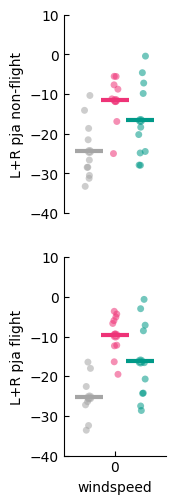

In [65]:
catg_names = ['0', '50', '100', '150', '200', '250', '300']
flight_conditions = ['ChrimCS','18D07', '74C10']
noFlight_conditions = ['ChrimCS','18D07', '74C10']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(1.75,5),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
print('no flight')
print('------------------------')
for j, condition in enumerate(noFlight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    #col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1]# - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,1]
        line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0]# - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    df_3rd['Antennal Segment'] = '3rd Segment'
    df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_3rd['iaa'] - df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
#df_final = df_final[df_final['windspeed'] != '0'] 
vteal = np.array([0,153,136])/255
vmagenta = np.array([238,51,119])/255
vgrey = np.array([165,165,165])/255
palette = [vgrey,vmagenta,vteal]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,alpha=0.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.5,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p3 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.5,lw=2,alpha=0.6,errorbar=None)
#ax1.xaxis.set_visible(False)
ax1.tick_params(direction="in")
ax1.spines[['right', 'top','bottom']].set_visible(False)
#ax1.set_ylim([0,55])
ax1.set_ylabel('L+R pja non-flight')
ax1.legend().set_visible(False)
ax1.xaxis.set_visible(False)
ax1.set_yticks([10,0,-10,-20,-30,-40])

windspeed = '0'
g18D07 =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='18D07')]
g74C10 =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='74C10')]
ChrimCS =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='ChrimCS')]
    
ans1 = stats.ttest_ind(ChrimCS['iaa'],g18D07['iaa'],nan_policy='omit')
ans2 = stats.ttest_ind(ChrimCS['iaa'],g74C10['iaa'],nan_policy='omit')
ans3 = stats.ttest_ind(g18D07['iaa'],g74C10['iaa'],nan_policy='omit')
    
print('Controlx18D07, '+ windspeed + ': ' + 't='+str(ans1[0]) + ' p=' + str(ans1[1]))
print('Controlx74C10, '+ windspeed + ': ' + 't='+str(ans2[0]) + ' p=' + str(ans2[1]))
print('18D07x74C10, '+ windspeed + ': ' + 't='+str(ans3[0]) + ' p=' + str(ans3[1]))
print()
    
df_plots = []
print('\n\n')
print('flight')
print('-----------------------------')
for j, condition in enumerate(flight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    col_list_flight = ['0_Flight']
    #col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_flight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] #- np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,1]
        line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] #- np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    df_3rd['Antennal Segment'] = '3rd Segment'
    df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_3rd['iaa'] - df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
#df_final = df_final[df_final['windspeed'] != '0'] 
vteal = np.array([0,153,136])/255
vmagenta = np.array([238,51,119])/255
vgrey = np.array([165,165,165])/255
palette = [vgrey,vmagenta,vteal]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,alpha=0.55)
#p = sns.violinplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,split=True,gap=.3,inner="point")
#p2 = sns.boxplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.5,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p3 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.5,lw=2.2,alpha=0.6,errorbar=None)
#ax2.set_ylim([0,55])
ax2.set_ylabel('L+R pja flight')
ax2.tick_params(direction="in")
ax2.spines[['right', 'top']].set_visible(False)
ax2.legend().set_visible(False)
ax2.set_yticks([0,10,-20,-30,-40,-10])

windspeed = '0'
g18D07 =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='18D07')]
g74C10 =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='74C10')]
ChrimCS =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='ChrimCS')]
    
ans1 = stats.ttest_ind(ChrimCS['iaa'],g18D07['iaa'],nan_policy='omit')
ans2 = stats.ttest_ind(ChrimCS['iaa'],g74C10['iaa'],nan_policy='omit')
ans3 = stats.ttest_ind(g18D07['iaa'],g74C10['iaa'],nan_policy='omit')
    
print('Controlx18D07, '+ windspeed + ': ' + 't='+str(ans1[0]) + ' p=' + str(ans1[1]))
print('Controlx74C10, '+ windspeed + ': ' + 't='+str(ans2[0]) + ' p=' + str(ans2[1]))
print('18D07x74C10, '+ windspeed + ': ' + 't='+str(ans3[0]) + ' p=' + str(ans3[1]))
print()

savename = 'passiveJointZeroGenetic'
fig.savefig(const.savedFigureDirectory+'png/'+savename+'.png',format='png')
fig.savefig(const.savedFigureDirectory+savename+'.pdf',format='pdf')

no flight
------------------------
Controlx18D07, 0: t=0.5753988682638491 p=0.5730255567449513
Controlx74C10, 0: t=6.427740067594486 p=4.7498597353131415e-06
18D07x74C10, 0: t=5.486649946319515 p=4.973752236158846e-05




flight
-----------------------------
Controlx18D07, 0: t=-1.1895860896908974 p=0.2515630847899316
Controlx74C10, 0: t=0.8367875055514011 p=0.4150358357824909
18D07x74C10, 0: t=1.8031438095626813 p=0.08813218638724957



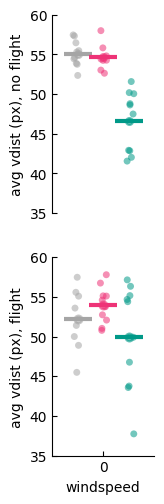

In [69]:
catg_names = ['0', '50', '100', '150', '200', '250', '300']
flight_conditions = ['ChrimCS','18D07', '74C10']
noFlight_conditions = ['ChrimCS','18D07', '74C10']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(1.75,5),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
print('no flight')
print('------------------------')
for j, condition in enumerate(noFlight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    #col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_vdist_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd[catg_names[i]] = (np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)).tolist()# - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,1]
        line_df_2nd[catg_names[i]] = line_df_2nd[catg_names[i]].apply(lambda x: x[0])

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='vdist',ignore_index=False)
    #df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    #df_3rd['Antennal Segment'] = '3rd Segment'
    #df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['vdist'] = df_2nd['vdist']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
#df_final = df_final[df_final['windspeed'] != '0'] 
vteal = np.array([0,153,136])/255
vmagenta = np.array([238,51,119])/255
vgrey = np.array([165,165,165])/255
palette = [vgrey,vmagenta,vteal]
p = sns.stripplot(x='windspeed',y='vdist',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,alpha=0.55)
p2 = sns.pointplot(x='windspeed',y='vdist',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.5,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p3 = sns.pointplot(x='windspeed',y='vdist',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.5,lw=2,alpha=0.6,errorbar=None)
#ax1.xaxis.set_visible(False)
ax1.tick_params(direction="in")
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([35,60])
ax1.set_ylabel('avg vdist (px), no flight')
ax1.legend().set_visible(False)
ax1.xaxis.set_visible(False)
#ax1.set_yticks([10,0,-10,-20,-30,-40])

windspeed = '0'
g18D07 =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='18D07')]
g74C10 =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='74C10')]
ChrimCS =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='ChrimCS')]
    
ans1 = stats.ttest_ind(ChrimCS['vdist'],g18D07['vdist'],nan_policy='omit')
ans2 = stats.ttest_ind(ChrimCS['vdist'],g74C10['vdist'],nan_policy='omit')
ans3 = stats.ttest_ind(g18D07['vdist'],g74C10['vdist'],nan_policy='omit')
    
print('Controlx18D07, '+ windspeed + ': ' + 't='+str(ans1[0]) + ' p=' + str(ans1[1]))
print('Controlx74C10, '+ windspeed + ': ' + 't='+str(ans2[0]) + ' p=' + str(ans2[1]))
print('18D07x74C10, '+ windspeed + ': ' + 't='+str(ans3[0]) + ' p=' + str(ans3[1]))
print()
    
df_plots = []
print('\n\n')
print('flight')
print('-----------------------------')
for j, condition in enumerate(flight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    col_list_flight = ['0_vdist_Flight']
    #col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_flight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1).tolist() #- np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,1]
        line_df_2nd[catg_names[i]] = line_df_2nd[catg_names[i]].apply(lambda x: x[0])    
    #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] #- np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='vdist',ignore_index=False)
    #df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='vdist',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    #df_3rd['Antennal Segment'] = '3rd Segment'
    #df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['vdist'] = df_2nd['vdist']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
#df_final = df_final[df_final['windspeed'] != '0'] 
vteal = np.array([0,153,136])/255
vmagenta = np.array([238,51,119])/255
vgrey = np.array([165,165,165])/255
palette = [vgrey,vmagenta,vteal]
p = sns.stripplot(x='windspeed',y='vdist',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,alpha=0.55)
#p = sns.violinplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,split=True,gap=.3,inner="point")
#p2 = sns.boxplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette)
p2 = sns.pointplot(x='windspeed',y='vdist',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.5,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p3 = sns.pointplot(x='windspeed',y='vdist',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.5,lw=2.2,alpha=0.6,errorbar=None)
ax2.set_ylim([35,60])
ax2.set_ylabel('avg vdist (px), flight')
ax2.tick_params(direction="in")
ax2.spines[['right', 'top']].set_visible(False)
ax2.legend().set_visible(False)
#ax2.set_yticks([0,10,-20,-30,-40,-10])

windspeed = '0'
g18D07 =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='18D07')]
g74C10 =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='74C10')]
ChrimCS =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='ChrimCS')]
    
ans1 = stats.ttest_ind(ChrimCS['vdist'],g18D07['vdist'],nan_policy='omit')
ans2 = stats.ttest_ind(ChrimCS['vdist'],g74C10['vdist'],nan_policy='omit')
ans3 = stats.ttest_ind(g18D07['vdist'],g74C10['vdist'],nan_policy='omit')
    
print('Controlx18D07, '+ windspeed + ': ' + 't='+str(ans1[0]) + ' p=' + str(ans1[1]))
print('Controlx74C10, '+ windspeed + ': ' + 't='+str(ans2[0]) + ' p=' + str(ans2[1]))
print('18D07x74C10, '+ windspeed + ': ' + 't='+str(ans3[0]) + ' p=' + str(ans3[1]))
print()

savename = 'vdistZeroGenetic'
fig.savefig(const.savedFigureDirectory+'png/'+savename+'.png',format='png')
fig.savefig(const.savedFigureDirectory+savename+'.pdf',format='pdf')

In [9]:
range(df['fly'].max()+1)

range(0, 10)

  windspeed         iaa Antennal Segment  index
0         0  106.307037      2nd Segment      0
1         0  109.313889      2nd Segment      1
2         0  105.199074      2nd Segment      2
3         0  105.171667      2nd Segment      3
4         0         NaN      2nd Segment      4
5         0  115.329722      2nd Segment      5
6         0   97.721667      2nd Segment      6
7         0  108.141825      2nd Segment      7
8         0         NaN      2nd Segment      8
9         0  126.973000      2nd Segment      9
[100.78888889  98.11666667  99.655       96.41944444          nan
  98.43083333  90.05805556  96.24492063          nan 101.97833333]
            0
0  100.788889
1   98.116667
2   99.655000
3   96.419444
4         NaN
5   98.430833
6   90.058056
7   96.244921
8         NaN
9  101.978333
  windspeed         iaa Antennal Segment  index
0         0  138.902847      2nd Segment      0
1         0  152.163704      2nd Segment      1
2         0  146.268333      2nd Segment 

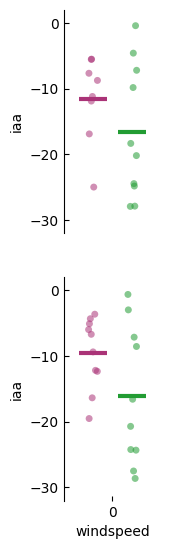

In [40]:
catg_names = ['0']
flight_conditions = ['18D07', '74C10']
noFlight_conditions = ['18D07', '74C10']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(1.7,5.5),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
for j, condition in enumerate(noFlight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    #col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,1]
        line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    df_3rd['Antennal Segment'] = '3rd Segment'
    df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    print(df_plot)
    print(df_3rd['iaa'].to_numpy())
    print(line_df_3rd)
    df_plot['iaa'] = df_3rd['iaa'].to_numpy() - df_2nd['iaa'].to_numpy()
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
bpurp = np.array([170,51,119])/255
palette = [bpurp, bgreen]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,legend=False,alpha=.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
ax1.legend().set_visible(False)
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([-32, 2])
ax1.set_yticks([-30, -20, -10, 0])
ax1.tick_params(direction="in")
ax1.xaxis.set_visible(False)

g18D07 =df_final.loc[(df_final['condition']=='18D07')]
g74C10 =df_final.loc[(df_final['condition']=='74C10')]
    
ans = stats.ttest_ind(g18D07['iaa'],g74C10['iaa'],nan_policy='omit')
print(str(ans[0]) + ' ' + str(ans[1]))

###########################
df_plots = []
for j, condition in enumerate(flight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    col_list_flight = ['0_Flight']
    #col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_flight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,1]
        line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)
    
    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    df_3rd['Antennal Segment'] = '3rd Segment'
    df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_3rd['iaa'] - df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
k = np.array([0,0,0])/255
bpurp = np.array([170,51,119])/255
palette = [bpurp, bgreen]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,legend=False,alpha=.55)
#p = sns.violinplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,split=True,gap=.3,inner="point")
#p2 = sns.boxplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
ax2.legend().set_visible(False)
ax2.spines[['right', 'top','bottom']].set_visible(False)
ax2.set_ylim([-32, 2])
ax2.set_yticks([-30, -20, -10, 0])
ax2.tick_params(direction="in")

g18D07 =df_final.loc[(df_final['condition']=='18D07')]
g74C10 =df_final.loc[(df_final['condition']=='74C10')]
    
ans = stats.ttest_ind(g18D07['iaa'],g74C10['iaa'],nan_policy='omit')
print(str(ans[0]) + ' ' + str(ans[1]))

fig.savefig(const.savedFigureDirectory+'png/'+'passiveJoint18D07vs74C10_zero'+'.png',format='png')
fig.savefig(const.savedFigureDirectory+'passiveJoint18D07vs74C10'+'.pdf',format='pdf')

50 1.0595720659984935 0.2962075755012882
100 1.9546184864922929 0.058215920384120774
150 2.820030613187463 0.007672218030169685
200 3.629922231543568 0.0008522987022665671
250 3.0263423277629693 0.004486905407069131
300 2.998159767884219 0.0048330836848575
50 1.4141301312199317 0.1687518752693639
100 1.4704213886962518 0.1534468840854508
150 3.089740681353285 0.00486207109056621
200 3.722772020499683 0.0011830504502234386
250 3.472910202619438 0.002547158543080499
300 3.3130121771237087 0.0034711224383607918


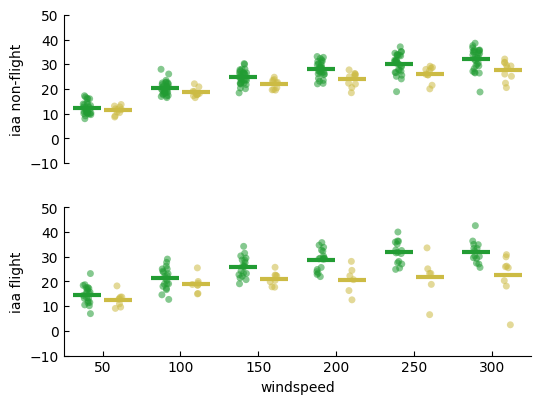

In [141]:
catg_names = ['0', '50', '100', '150', '200', '250', '300']
flight_conditions = ['static', 'silenced']
noFlight_conditions = ['static', 'silenced']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(5.4,4),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
for j, condition in enumerate(noFlight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    #col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,1]
        line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    df_3rd['Antennal Segment'] = '3rd Segment'
    df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_3rd['iaa'] - df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
df_final = df_final[df_final['windspeed'] != '0'] 
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
bpurp = np.array([170,51,119])/255
palette = [bgreen, byellow]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,legend=False,alpha=0.55)
#p = sns.violinplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,split=True,gap=.3,inner="point")
#p2 = sns.boxplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
#ax1.xaxis.set_visible(False)
ax1.tick_params(direction="in")
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([-10,50])
ax1.set_ylabel('iaa non-flight')
ax1.legend().set_visible(False)
ax1.xaxis.set_visible(False)
ax1.set_yticks([-10,0,10,20,30,40,50])

for windspeed in catg_names[1:]:
    static =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='static')]
    silenced =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='silenced')]
    
    ans = stats.ttest_ind(static['iaa'],silenced['iaa'],nan_policy='omit')
    print(windspeed + ' ' + str(ans[0]) + ' ' + str(ans[1]))
    
df_plots = []
for j, condition in enumerate(flight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    #col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_flight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,1]
        line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    df_3rd['Antennal Segment'] = '3rd Segment'
    df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_3rd['iaa'] - df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
df_final = df_final[df_final['windspeed'] != '0'] 
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
#bpurp = np.array([170,51,119])/255
palette = [bgreen, byellow]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,legend=False,alpha=0.55)
#p = sns.violinplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,split=True,gap=.3,inner="point")
#p2 = sns.boxplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)

ax2.set_ylim([-10,50])
ax2.set_ylabel('iaa flight')
ax2.tick_params(direction="in")
ax2.spines[['right', 'top']].set_visible(False)
ax2.legend().set_visible(False)
ax2.set_yticks([-10,0,10,20,30,40,50])

savename = 'passiveActiveStaticvsSilenced'
fig.savefig(const.savedFigureDirectory+'png/'+savename+'.png',format='png')
fig.savefig(const.savedFigureDirectory+savename+'.pdf',format='pdf')

for windspeed in catg_names[1:]:
    static =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='static')]
    silenced =df_final.loc[(df_final['windspeed'] == windspeed) & (df_final['condition']=='silenced')]
    
    ans = stats.ttest_ind(static['iaa'],silenced['iaa'],nan_policy='omit')
    print(windspeed + ' ' + str(ans[0]) + ' ' + str(ans[1]))

In [8]:
int(df['fly'].max()+1)

10

0    [[99.5, 130.9], [99.30000000000001, 131.4], [9...
Name: iaa, dtype: object
0    [[125.80000000000001, 164.3], [125.80000000000...
Name: iaa, dtype: object
0    [[97.4, 133.3], [119.1, 132.4], [125.8, 136.5]...
Name: iaa, dtype: object
0    [[126.0, 161.5], [145.0, 160.7], [144.60000000...
Name: iaa, dtype: object
[5]


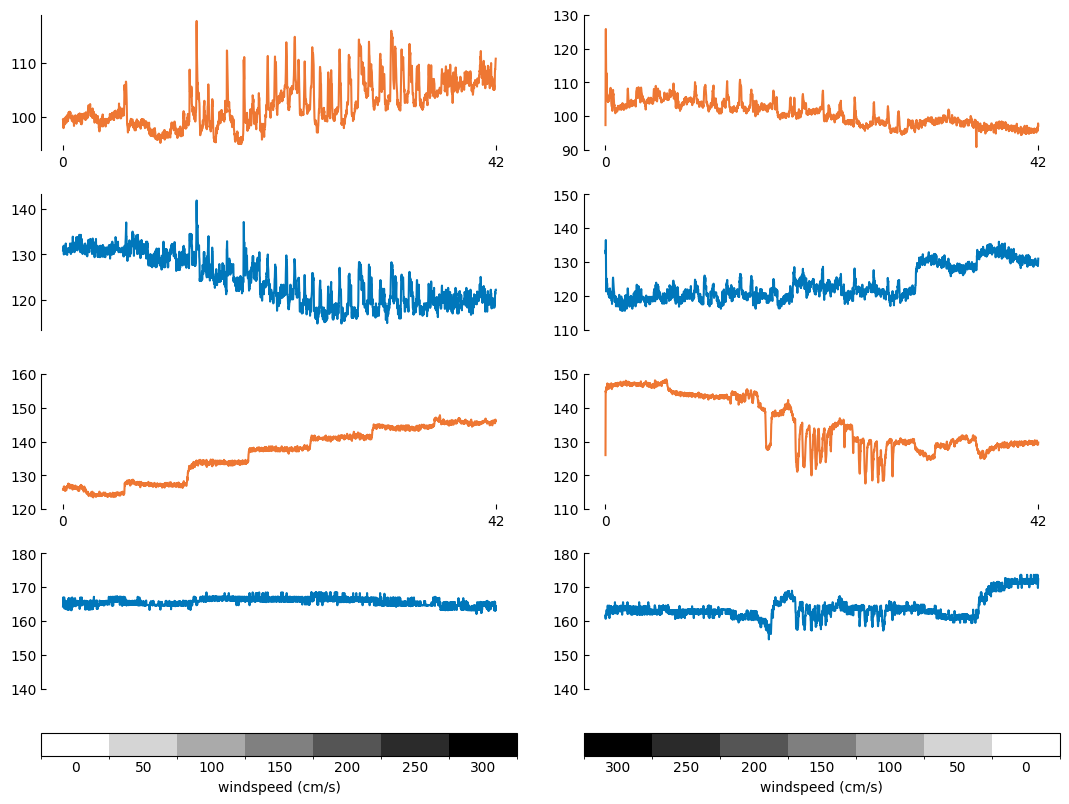

In [68]:
fig,axes = plt.subplots(5,2,figsize=(11,8),gridspec_kw={'height_ratios': [3,3,3,3,0.5]})
fig.tight_layout()
vblue = np.array([0,119,187])/255
vorange = np.array([238,119,51])/255

trial_choice_up = [(11,1),(9,2)]
trial_choice_down = [(11,6),(9,5)]

for i, idx in enumerate(trial_choice_up):
    df_a = df[(df['stimType'] == 1) & (df['condition'] == 'dark') & (df['fly'] == idx[0]) & (df['trial']==idx[1])].reset_index()
    print(df_a['iaa'])
    for row in df_a['iaa']:
        x = np.linspace(0,42,2520)
        axes[i*2+1,0].plot(x,row[:,1],c=vblue)
        axes[(i*2),0].plot(x,row[:,0],c=vorange)
        
        axes[i*2,0].tick_params(direction="in")
        axes[i*2,0].set_xticks([0,42])
        axes[i*2,0].spines[['right', 'top','bottom']].set_visible(False)

        axes[i*2+1,0].tick_params(direction="in")
        axes[i*2+1,0].spines[['right', 'top','bottom']].set_visible(False)
        axes[i*2+1,0].set_xticks([])
        #axes[0].set_yticks([120,130,140,150])

#axes[1,0].set_ylim([100,140])
#axes[0,0].set_ylim([90,130])
axes[3,0].set_ylim([140,180])
axes[2,0].set_ylim([120,160])

cmap = mpl.cm.gray_r
bounds = [0,50, 100, 150, 200, 250, 300,350]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = mpl.colorbar.ColorbarBase(axes[4,0], norm=norm,orientation='horizontal', 
                               cmap=cmap)

tick_labels=(['0','50','100', '150', '200', '250', '300'])
tick_texts = cb.ax.set_xticks([25,75,125,175,225,275,325])
tick_texts = cb.ax.set_xticklabels(tick_labels)
cb.ax.tick_params(length=0)
axes[4,0].set_xlabel('windspeed (cm/s)')

###############################
for i, idx in enumerate(trial_choice_down):
    df_a = df[(df['stimType'] == 2) & (df['condition'] == 'dark') & (df['fly'] == idx[0]) & (df['trial']==idx[1])].reset_index()
    print(df_a['iaa'])
    for row in df_a['iaa']:
        x = np.linspace(0,42,2520) # 0 to 42 seconds
        axes[i*2+1,1].plot(x,row[:,1],c=vblue)
        axes[(i*2),1].plot(x,row[:,0],c=vorange)
        
        axes[i*2,1].tick_params(direction="in")
        axes[i*2,1].set_xticks([0,42])
        axes[i*2,1].spines[['right', 'top','bottom']].set_visible(False)

        axes[i*2+1,1].tick_params(direction="in")
        axes[i*2+1,1].spines[['right', 'top','bottom']].set_visible(False)
        axes[i*2+1,1].set_xticks([])
        #axes[0].set_yticks([120,130,140,150])

axes[1,1].set_ylim([110,150])
axes[0,1].set_ylim([90,130])
axes[3,1].set_ylim([140,180])
axes[2,1].set_ylim([110,150])

cmap2 = mpl.cm.gray
bounds = [0,50, 100, 150, 200, 250, 300,350]
norm2 = mpl.colors.BoundaryNorm(bounds, cmap2.N)
cb2 = mpl.colorbar.ColorbarBase(axes[4,1], norm=norm2,orientation='horizontal', 
                               cmap=cmap2)

tick_labels=(['300','250','200', '150', '100', '50', '0'])
tick_texts = cb2.ax.set_xticks([25,75,125,175,225,275,325])
tick_texts = cb2.ax.set_xticklabels(tick_labels)
cb2.ax.tick_params(length=0)
axes[4,1].set_xlabel('windspeed (cm/s)')
for row in df_a['trial']:
    print(row)
fig.savefig('raw_traces.pdf')

0    [[115.1, 137.10000000000002], [115.30000000000...
Name: iaa, dtype: object
0    [[131.89999999999998, 146.39999999999998], [13...
Name: iaa, dtype: object
0    [[119.39999999999999, 142.5], [110.2, 115.4], ...
Name: iaa, dtype: object
0    [[126.69999999999999, 150.60000000000002], [17...
Name: iaa, dtype: object
[2]


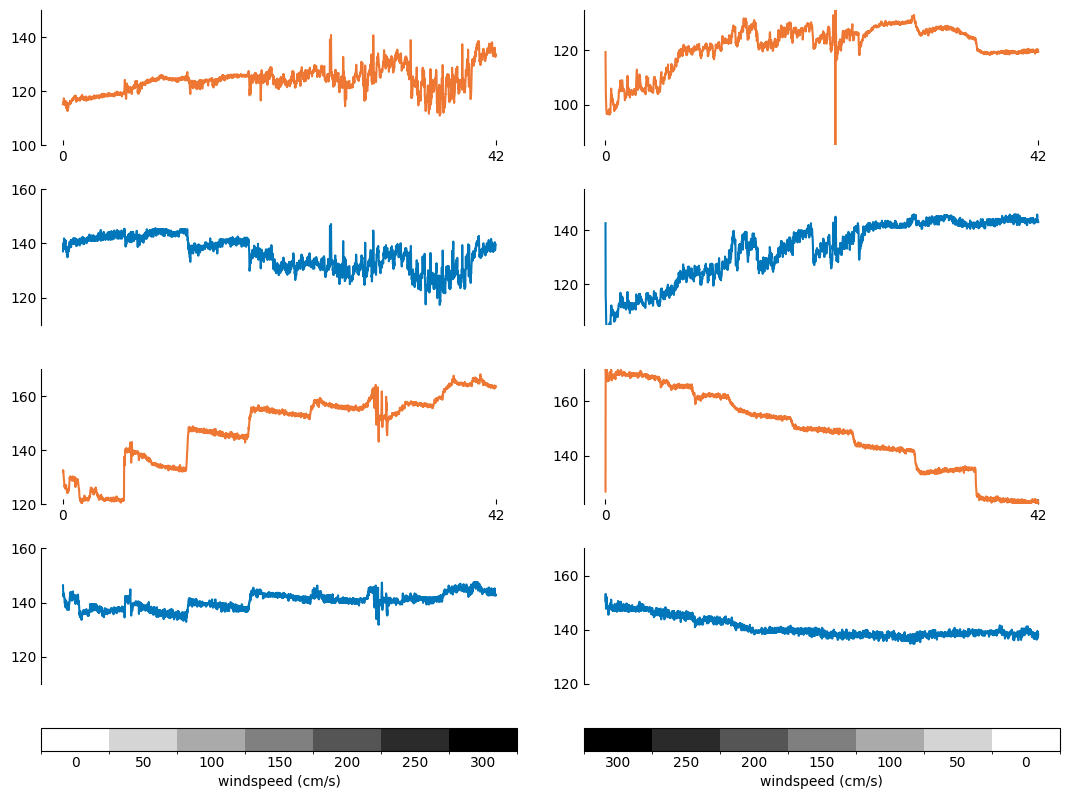

In [74]:
fig,axes = plt.subplots(5,2,figsize=(11,8),gridspec_kw={'height_ratios': [3,3,3,3,0.5]})
fig.tight_layout()
vblue = np.array([0,119,187])/255
vorange = np.array([238,119,51])/255

trial_choice_up = [(7,3),(5,6)]
trial_choice_down = [(7,2),(5,2)]

for i, idx in enumerate(trial_choice_up):
    if i == 0:
        con = 'dark'
    else:
        con = 'static'
    df_a = df[(df['stimType'] == 1) & (df['condition'] == con) & (df['fly'] == idx[0]) & (df['trial']==idx[1])].reset_index()
    print(df_a['iaa'])
    for row in df_a['iaa']:
        x = np.linspace(0,42,2520)
        axes[i*2+1,0].plot(x,row[:,1],c=vblue)
        axes[(i*2),0].plot(x,row[:,0],c=vorange)
        
        axes[i*2,0].tick_params(direction="in")
        axes[i*2,0].set_xticks([0,42])
        axes[i*2,0].spines[['right', 'top','bottom']].set_visible(False)

        axes[i*2+1,0].tick_params(direction="in")
        axes[i*2+1,0].spines[['right', 'top','bottom']].set_visible(False)
        axes[i*2+1,0].set_xticks([])
        #axes[0].set_yticks([120,130,140,150])

axes[1,0].set_ylim([110,160])
axes[0,0].set_ylim([100,150])
axes[3,0].set_ylim([110,160])
axes[2,0].set_ylim([120,170])

cmap = mpl.cm.gray_r
bounds = [0,50, 100, 150, 200, 250, 300,350]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = mpl.colorbar.ColorbarBase(axes[4,0], norm=norm,orientation='horizontal', 
                               cmap=cmap)

tick_labels=(['0','50','100', '150', '200', '250', '300'])
tick_texts = cb.ax.set_xticks([25,75,125,175,225,275,325])
tick_texts = cb.ax.set_xticklabels(tick_labels)
cb.ax.tick_params(length=0)
axes[4,0].set_xlabel('windspeed (cm/s)')

###############################
for i, idx in enumerate(trial_choice_down):
    if i == 0:
        con = 'dark'
    else:
        con = 'static'
    df_a = df[(df['stimType'] == 2) & (df['condition'] == con) & (df['fly'] == idx[0]) & (df['trial']==idx[1])].reset_index()
    print(df_a['iaa'])
    for row in df_a['iaa']:
        x = np.linspace(0,42,2520) # 0 to 42 seconds
        axes[i*2+1,1].plot(x,row[:,1],c=vblue)
        axes[(i*2),1].plot(x,row[:,0],c=vorange)
        
        axes[i*2,1].tick_params(direction="in")
        axes[i*2,1].set_xticks([0,42])
        axes[i*2,1].spines[['right', 'top','bottom']].set_visible(False)

        axes[i*2+1,1].tick_params(direction="in")
        axes[i*2+1,1].spines[['right', 'top','bottom']].set_visible(False)
        axes[i*2+1,1].set_xticks([])
        #axes[0].set_yticks([120,130,140,150])

axes[1,1].set_ylim([105,155])
axes[0,1].set_ylim([85,135])
axes[3,1].set_ylim([120,170])
axes[2,1].set_ylim([122,172])

cmap2 = mpl.cm.gray
bounds = [0,50, 100, 150, 200, 250, 300,350]
norm2 = mpl.colors.BoundaryNorm(bounds, cmap2.N)
cb2 = mpl.colorbar.ColorbarBase(axes[4,1], norm=norm2,orientation='horizontal', 
                               cmap=cmap2)

tick_labels=(['300','250','200', '150', '100', '50', '0'])
tick_texts = cb2.ax.set_xticks([25,75,125,175,225,275,325])
tick_texts = cb2.ax.set_xticklabels(tick_labels)
cb2.ax.tick_params(length=0)
axes[4,1].set_xlabel('windspeed (cm/s)')
for row in df_a['trial']:
    print(row)
fig.savefig('raw_traces_darkstatic_uponly.pdf')

[1]
[2]
[4]
[5]
[10]
[1]
[2]
[5]
[7]
[9]
[1]
[2]
[4]
[5]
[8]
[1]
[2]
[4]
[5]
[7]
[1]
[2]
[3]
[4]
[10]
[1]
[5]
[8]
[9]
[10]
[1]
[2]
[5]
[6]
[9]
[3]
[4]
[5]
[8]
[9]
[1]
[2]
[6]
[9]
[10]
[2]
[4]
[6]
[7]
[10]
[6]
[7]
[8]
[9]
[10]
[1]
[4]
[8]
[9]
[10]
[2]
[3]
[6]
[7]
[9]
[1]
[2]
[4]
[7]
[8]
[1]
[2]
[7]
[9]
[10]
[4]
[6]
[7]
[9]
[10]
[1]
[4]
[6]
[7]
[10]
[2]
[5]
[8]
[9]
[10]
[4]
[5]
[7]
[8]
[10]
[1]
[5]
[7]
[8]
[9]
[1]
[2]
[4]
[7]
[8]
[1]
[2]
[3]
[5]
[7]
[4]
[5]
[7]
[8]
[9]
[2]
[3]
[7]
[8]
[10]
[1]
[3]
[6]
[7]
[10]
[1]
[5]
[6]
[7]
[9]
[2]
[3]
[5]
[6]
[9]
[1]
[2]
[4]
[5]
[8]
[3]
[4]
[5]
[6]
[9]
[2]
[4]
[7]
[9]
[10]


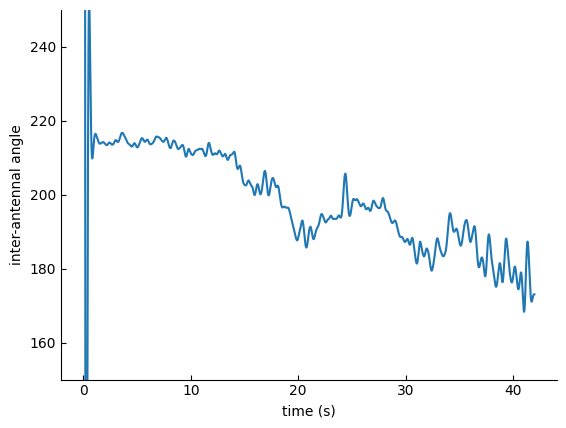

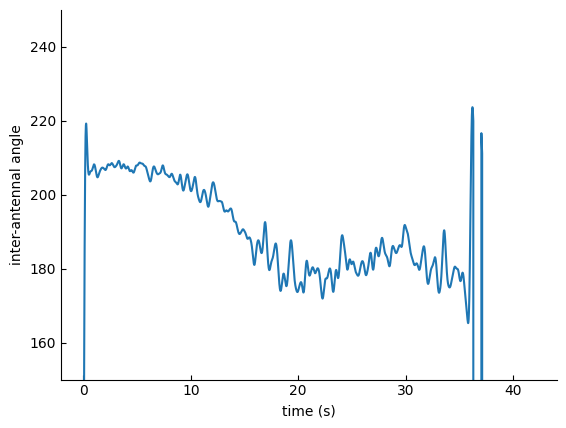

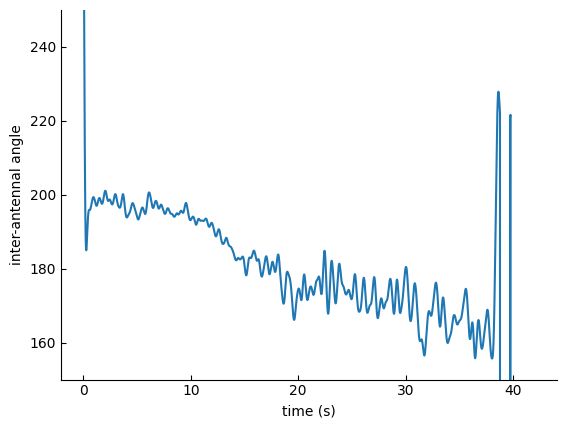

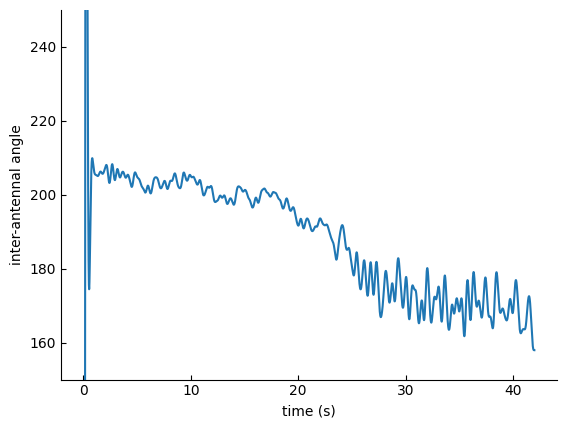

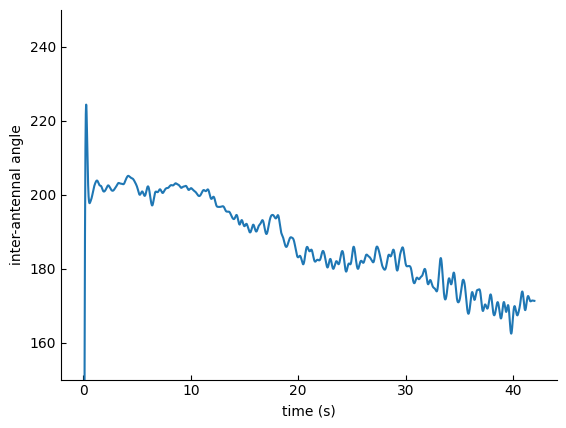

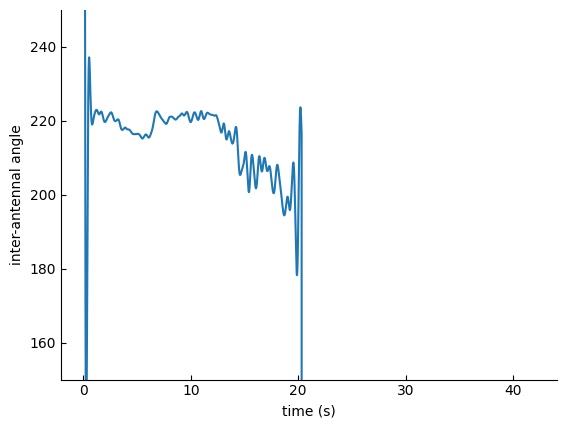

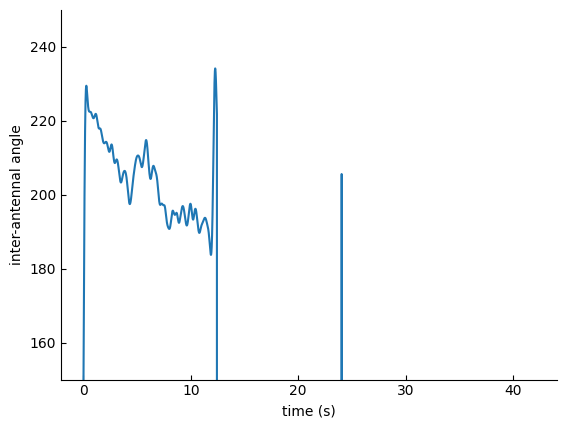

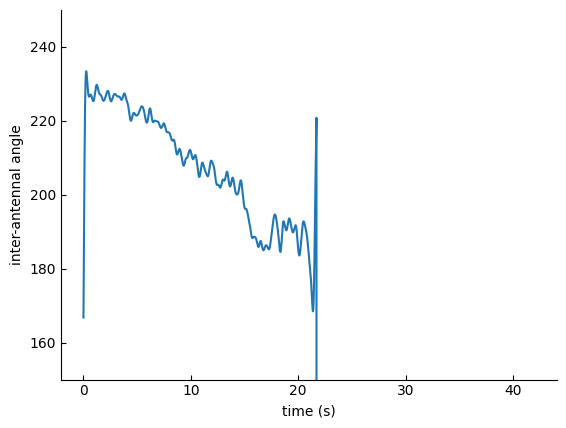

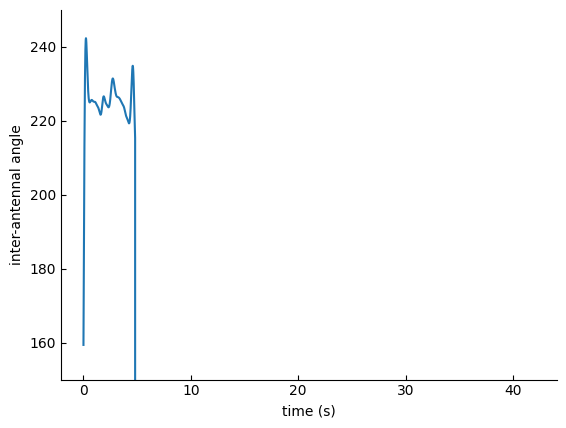

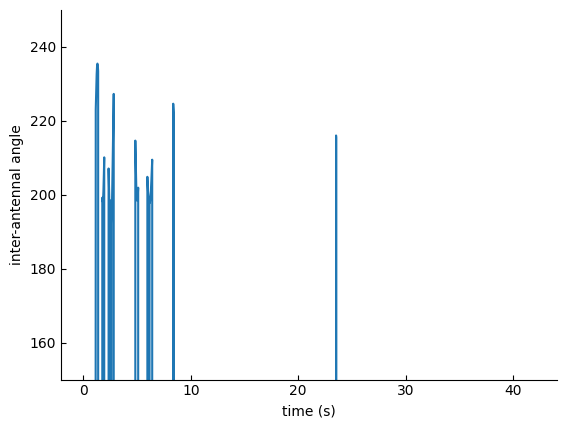

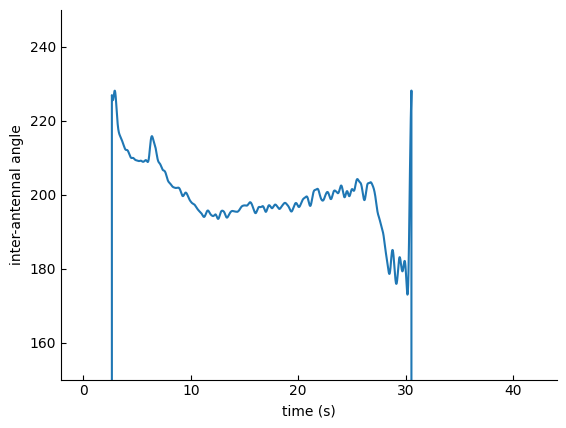

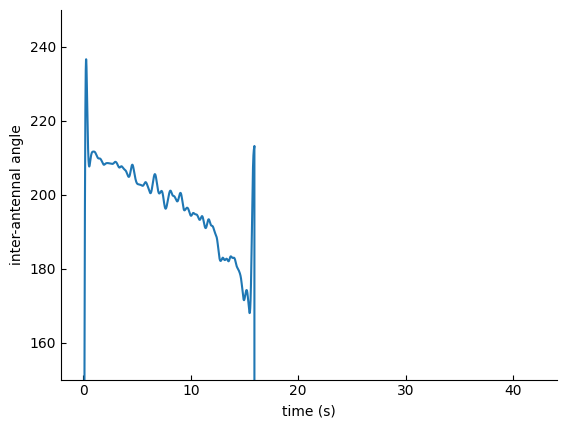

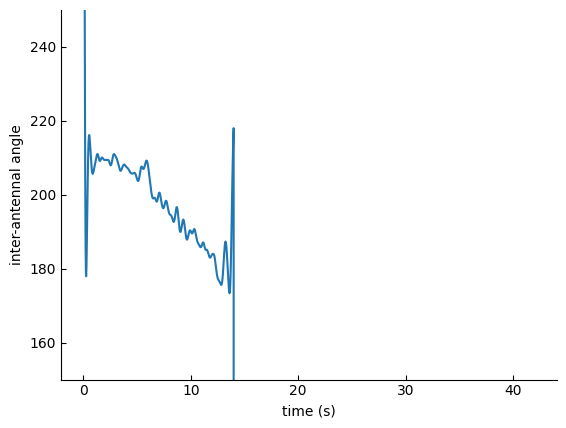

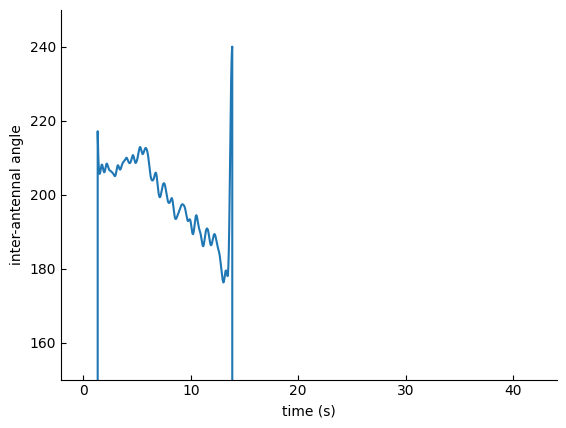

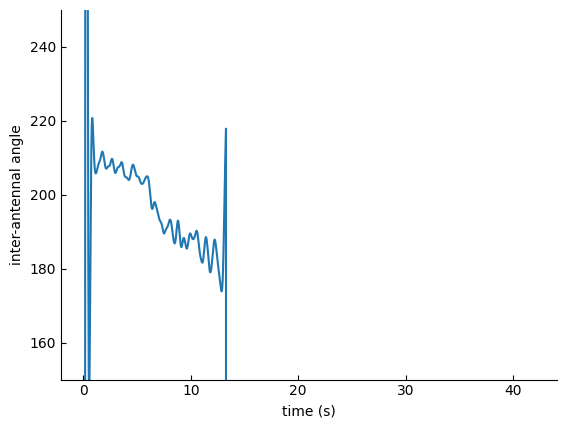

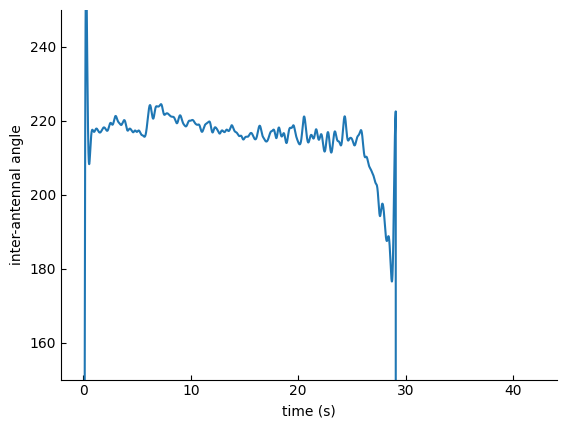

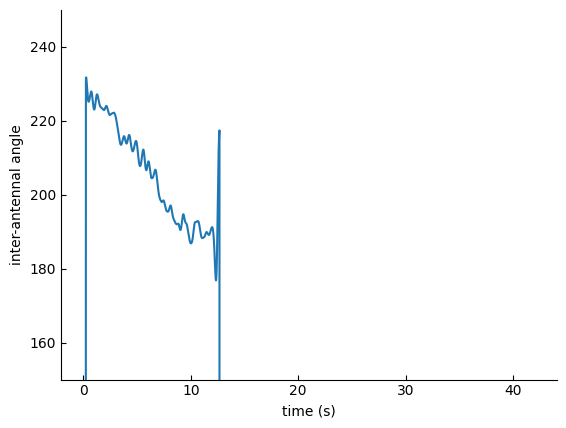

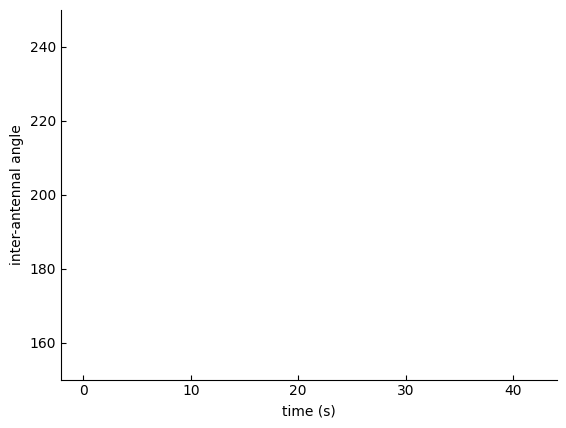

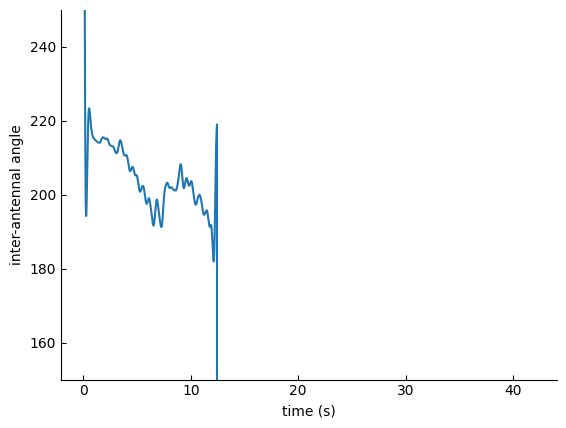

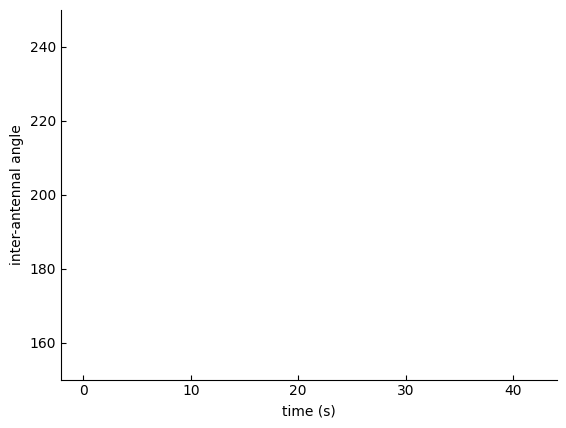

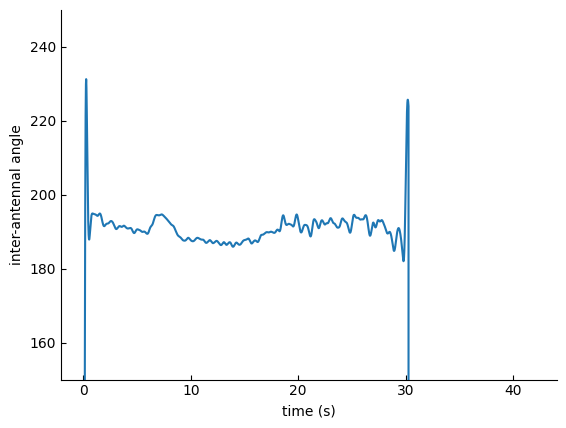

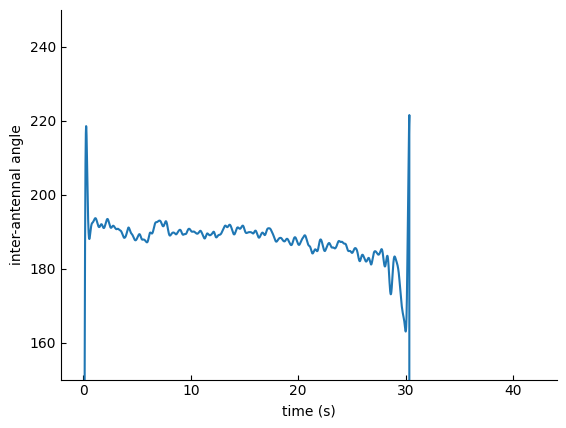

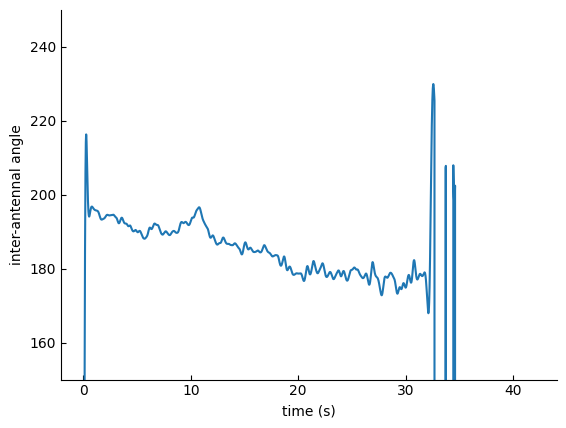

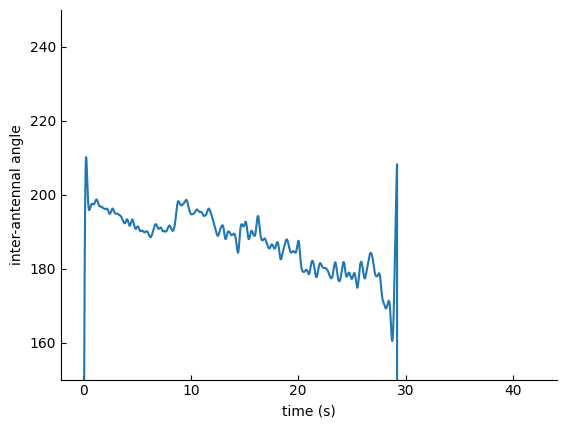

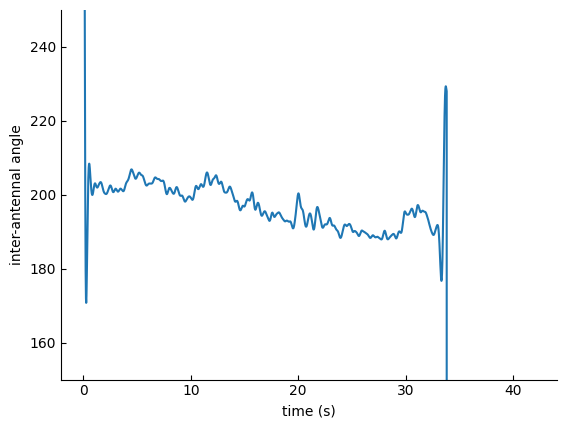

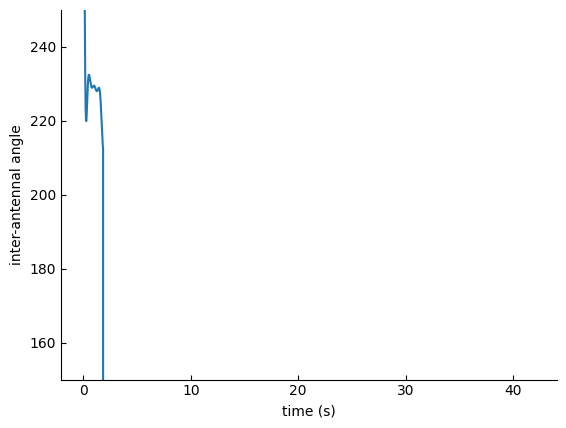

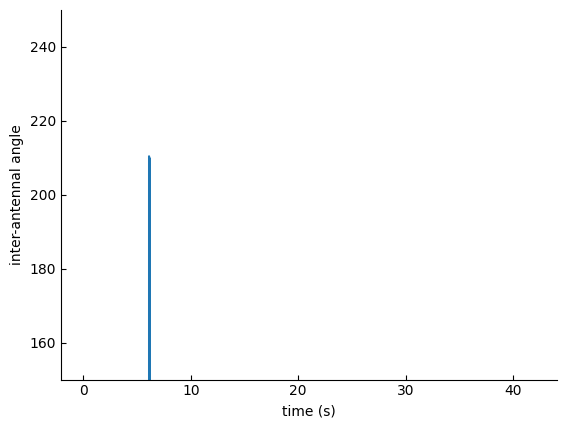

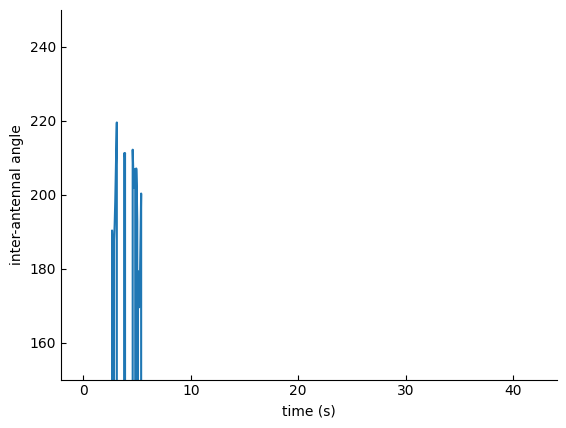

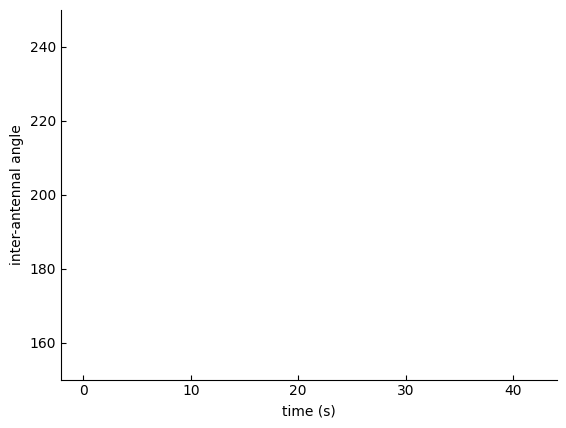

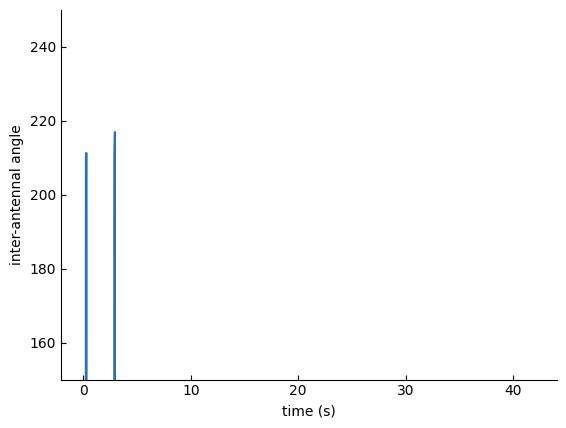

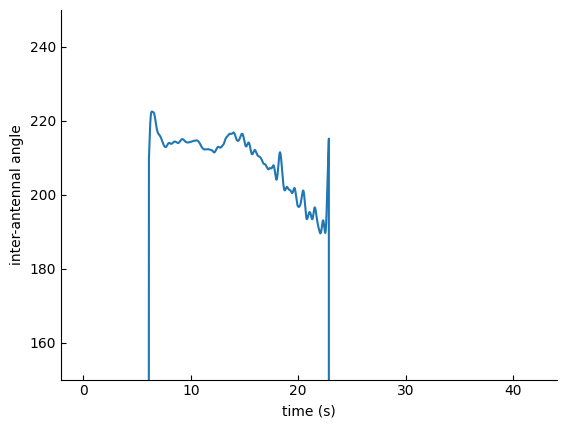

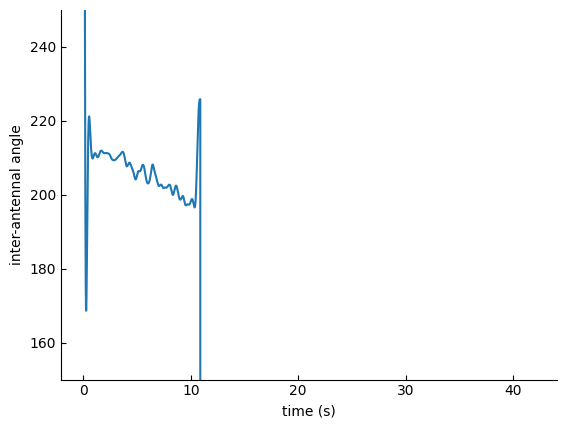

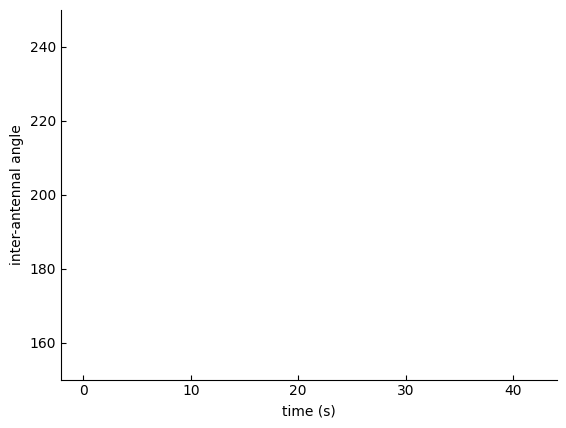

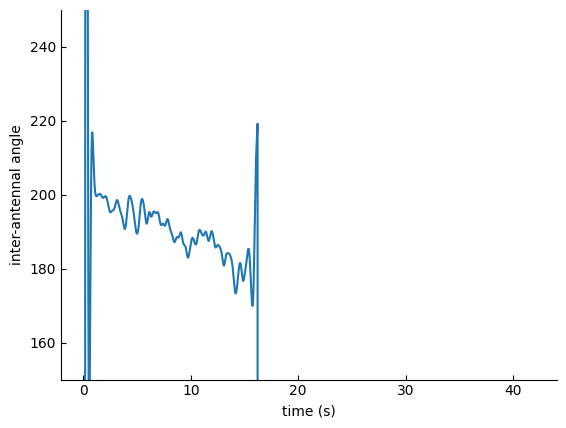

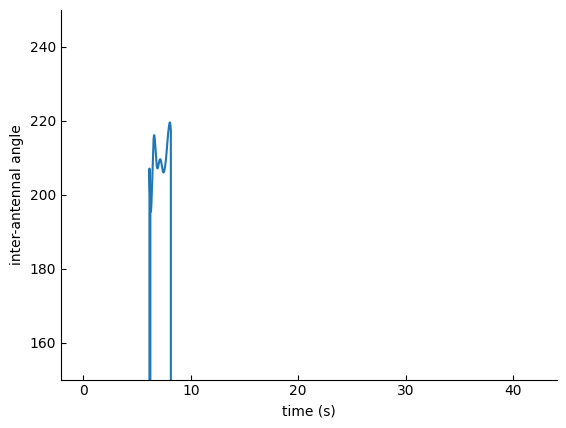

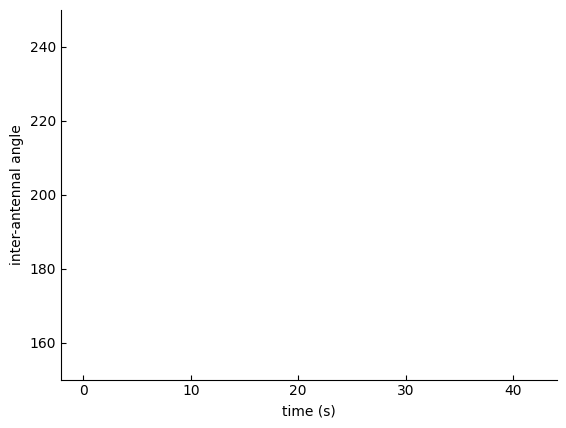

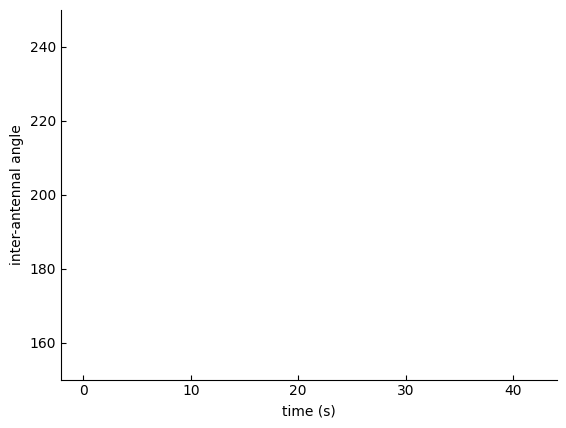

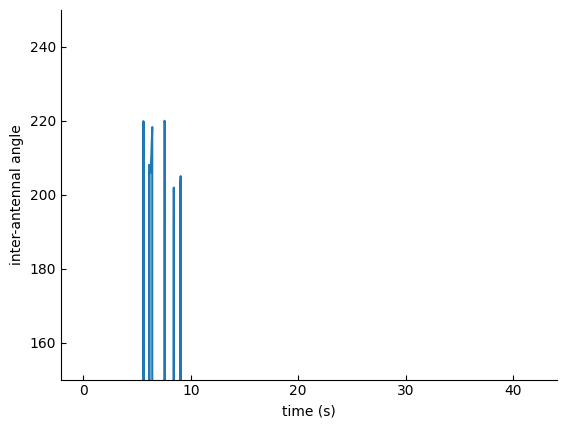

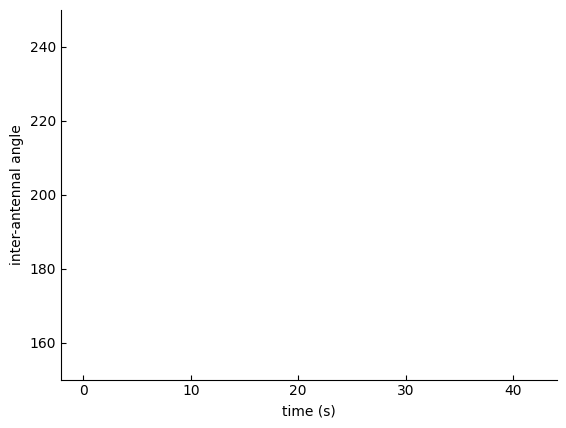

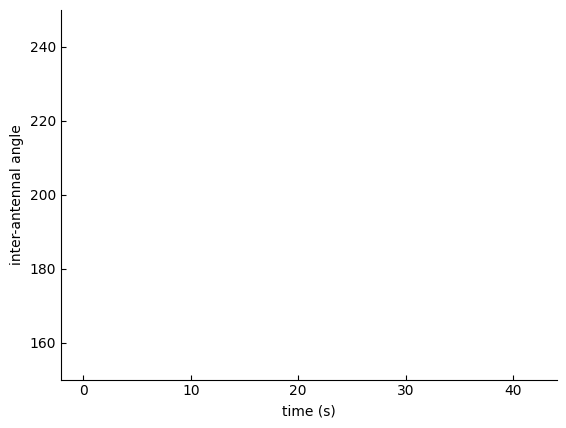

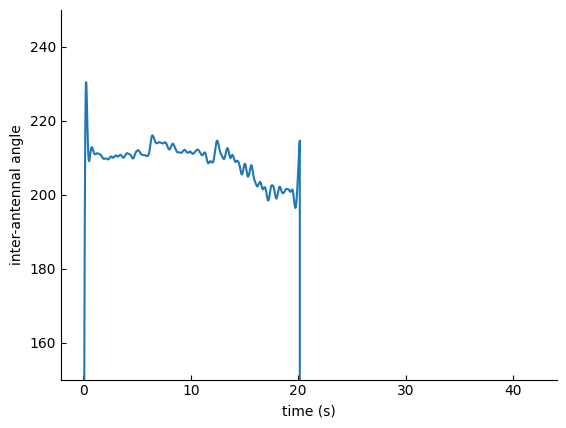

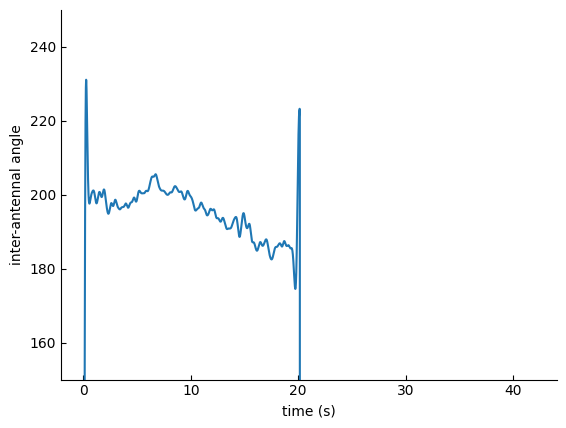

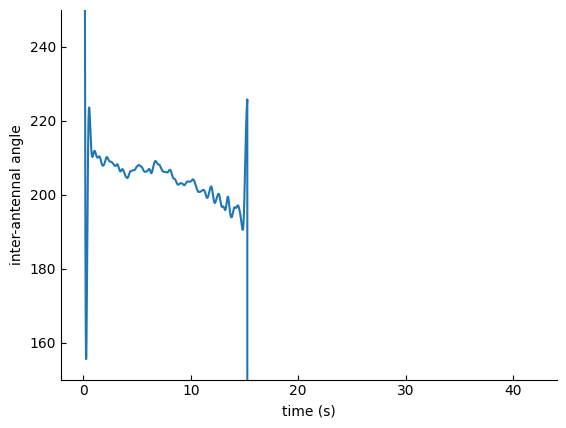

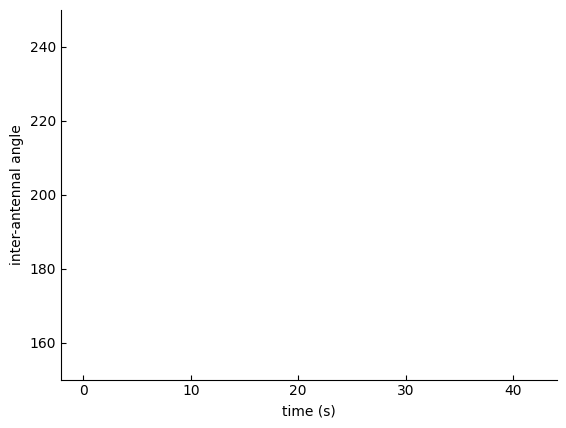

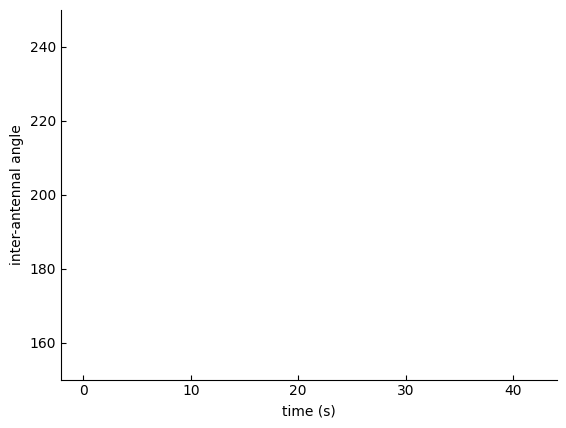

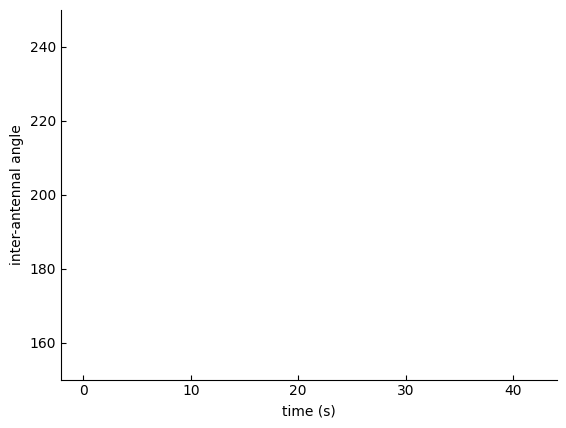

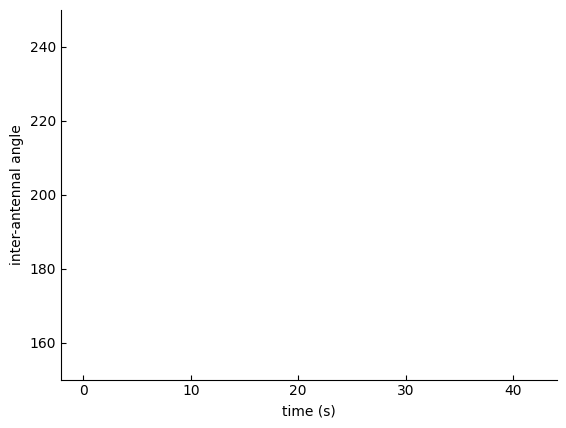

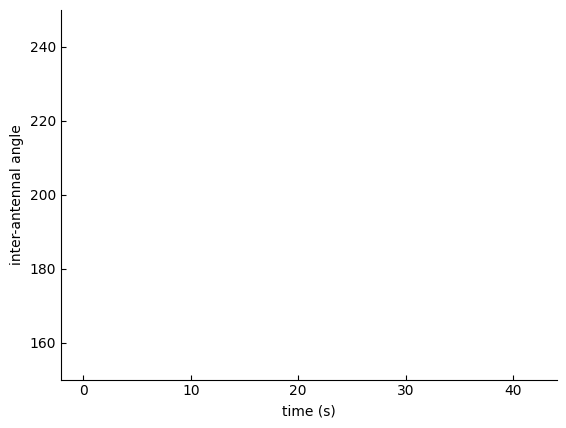

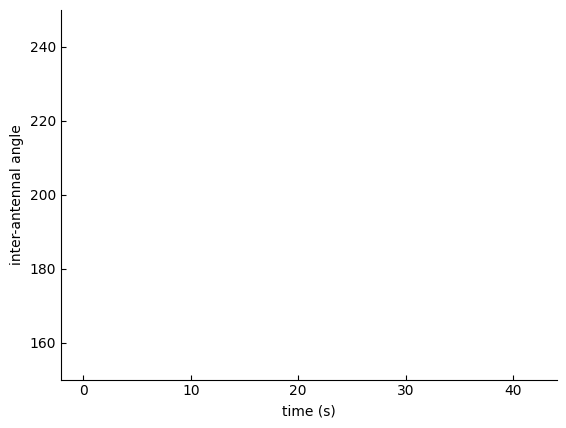

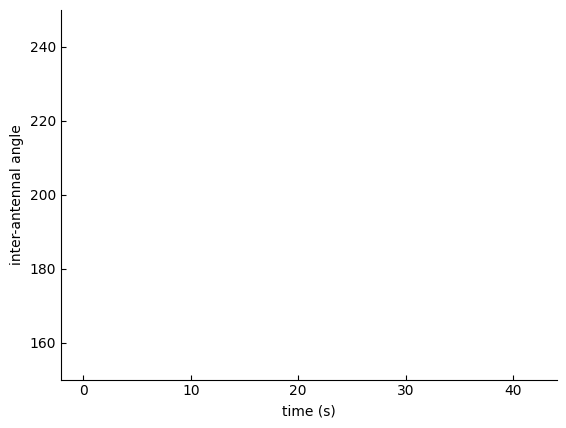

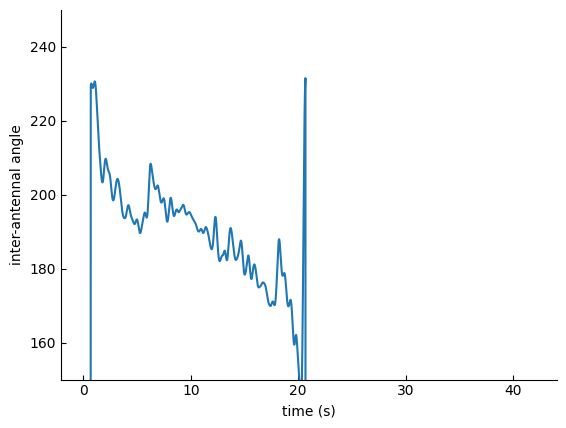

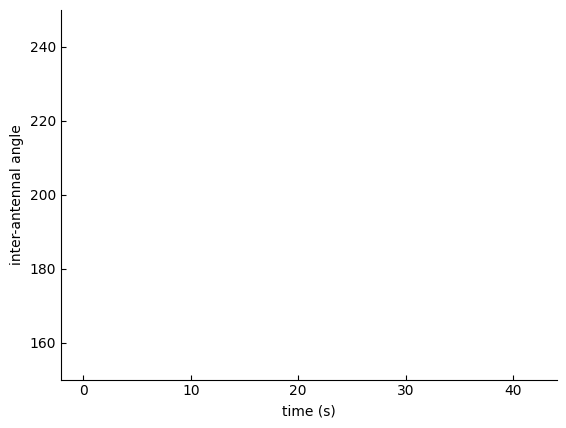

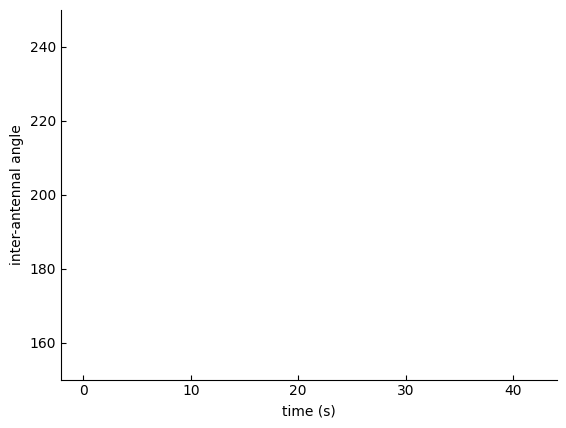

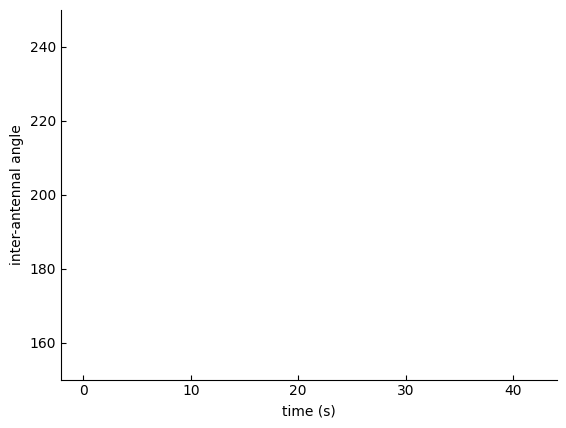

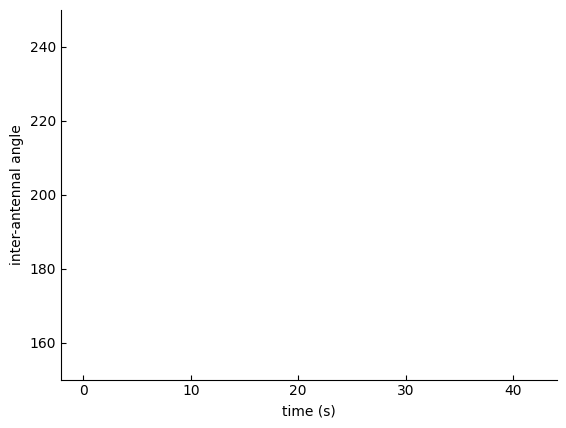

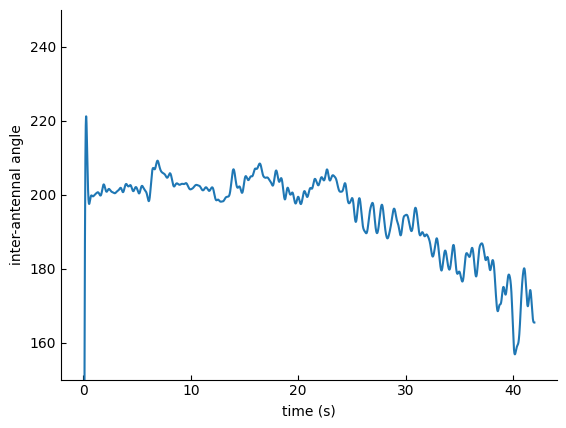

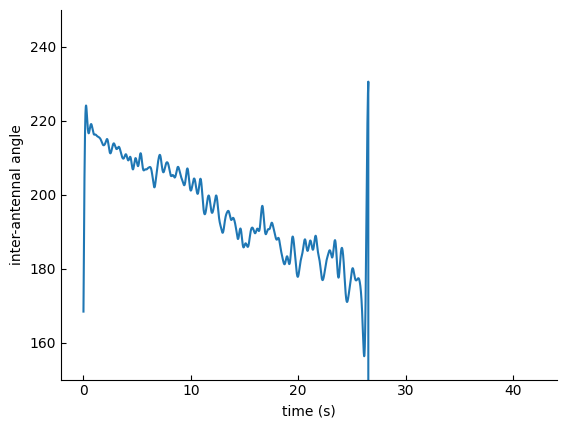

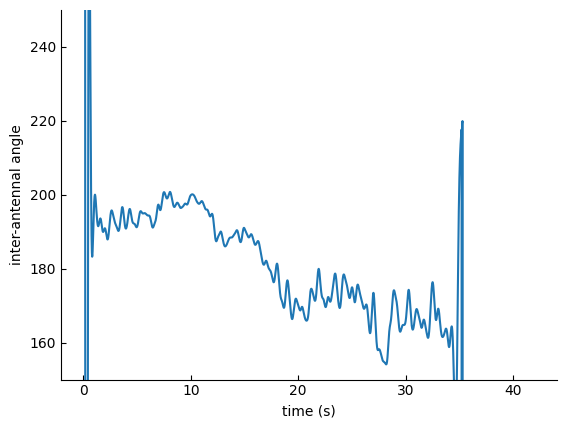

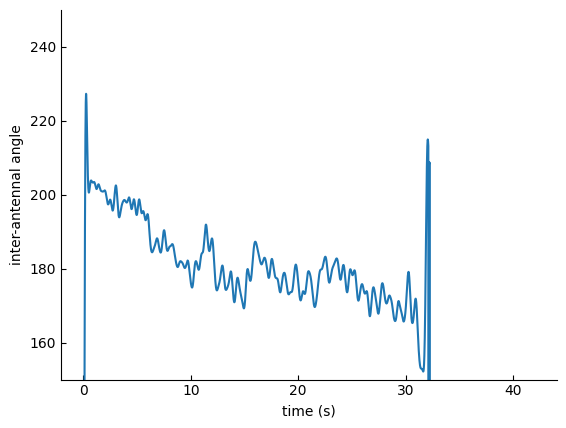

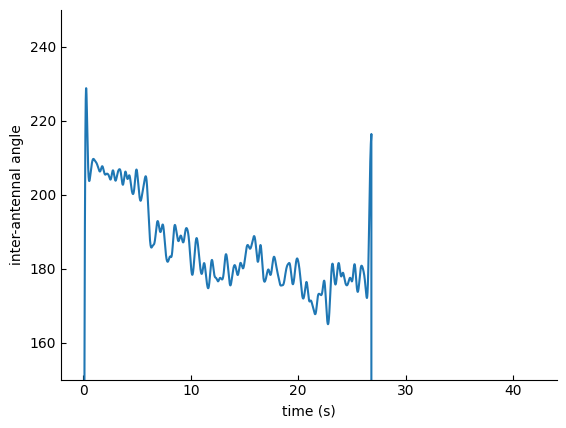

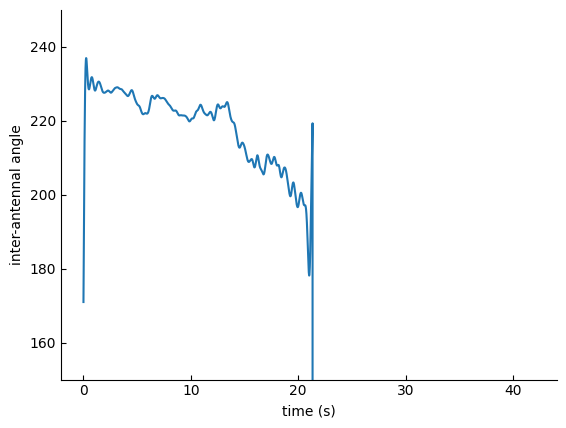

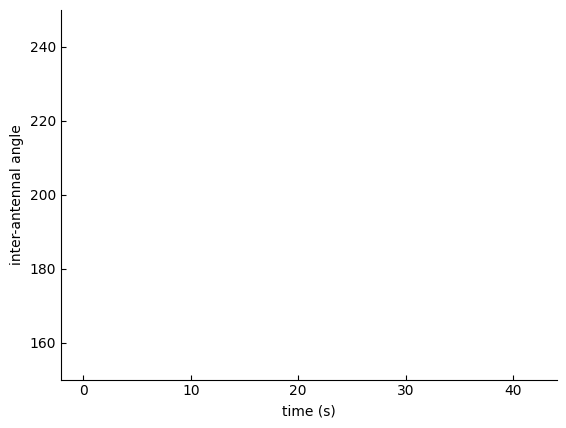

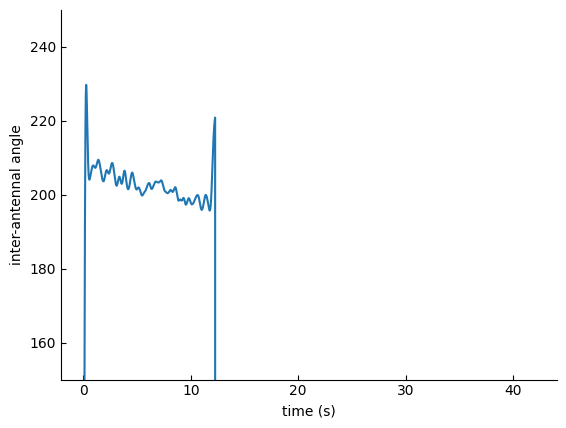

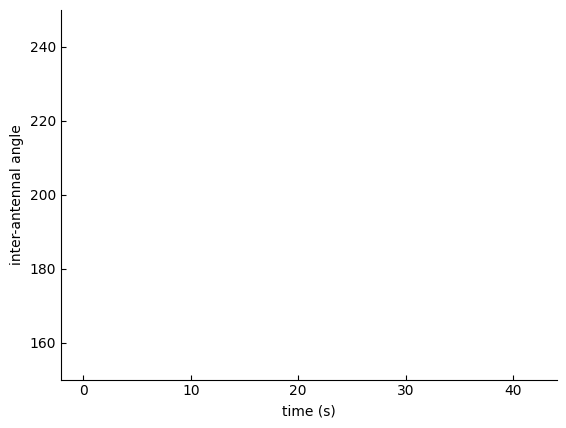

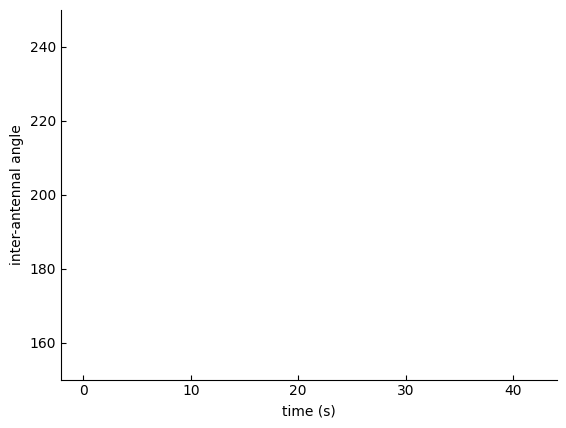

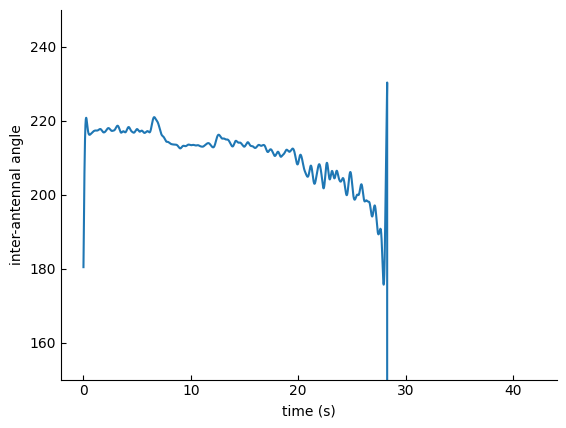

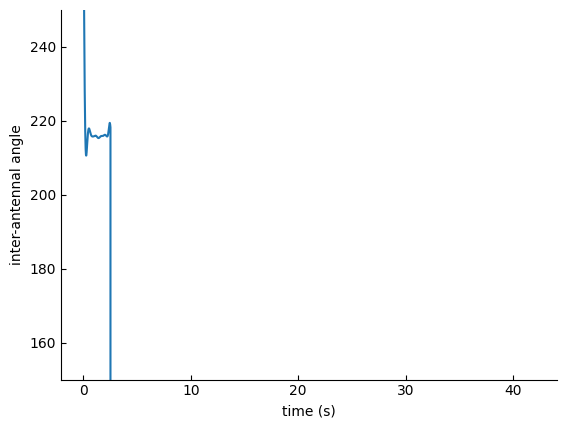

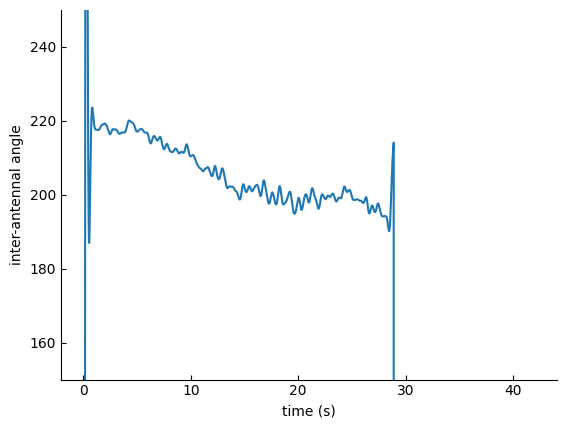

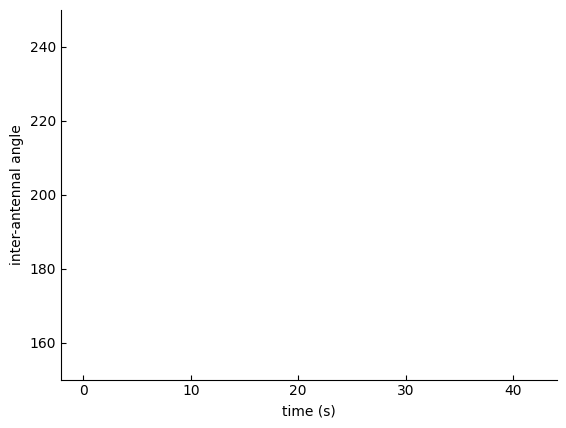

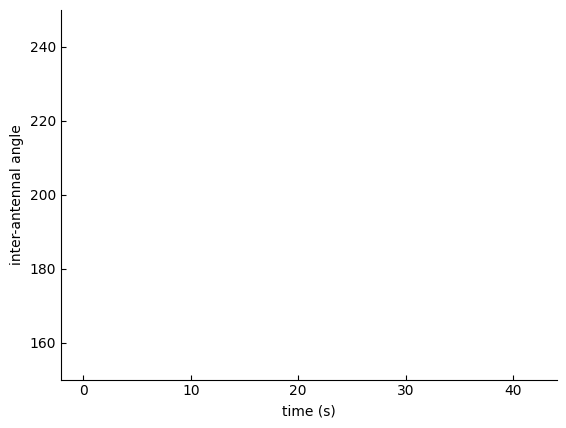

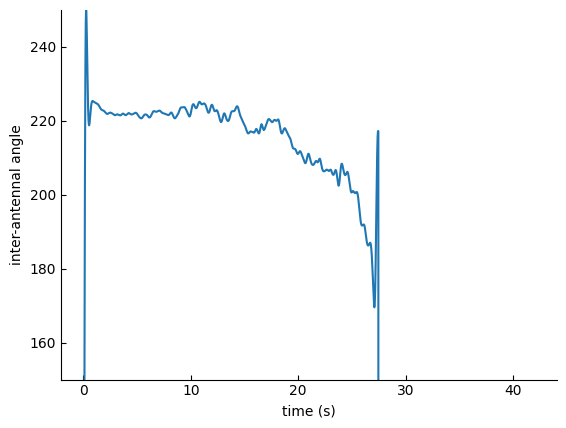

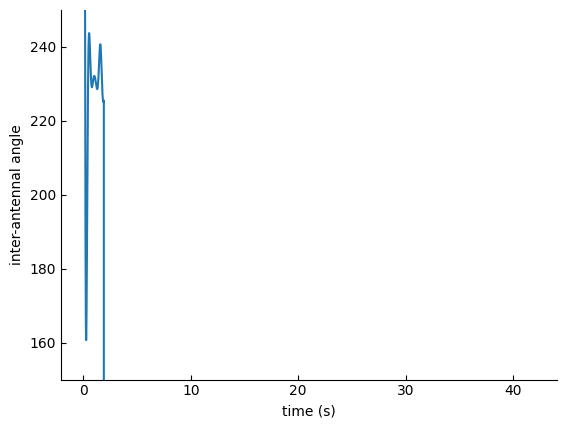

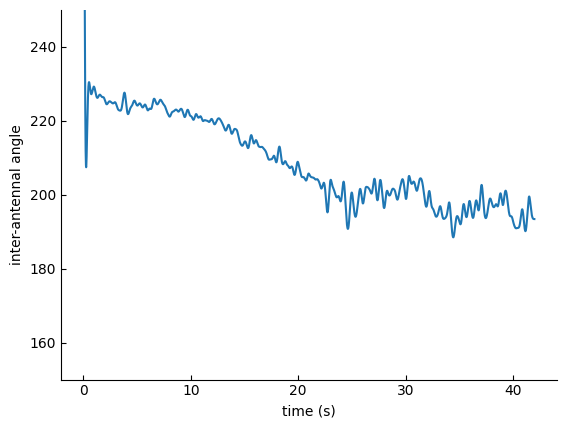

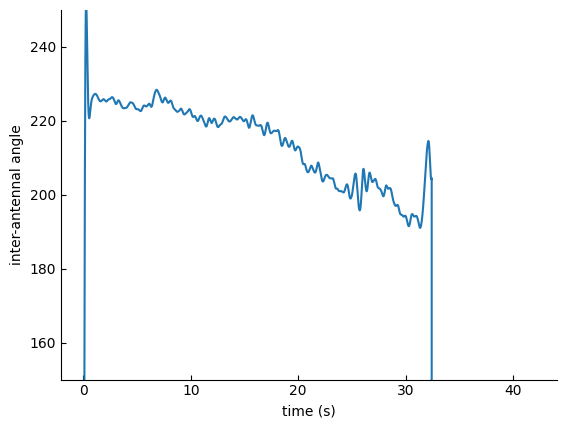

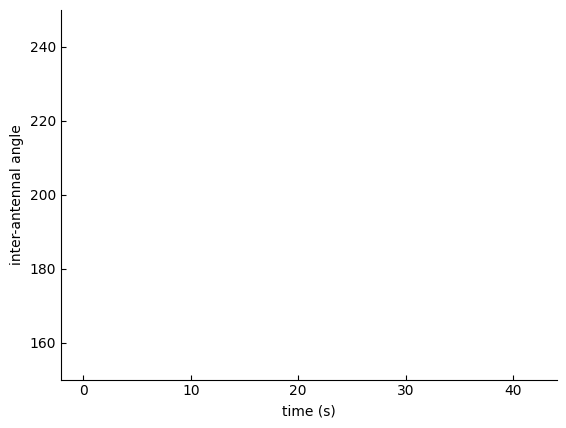

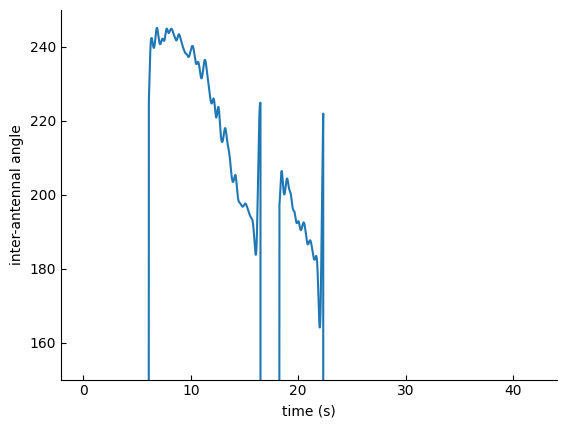

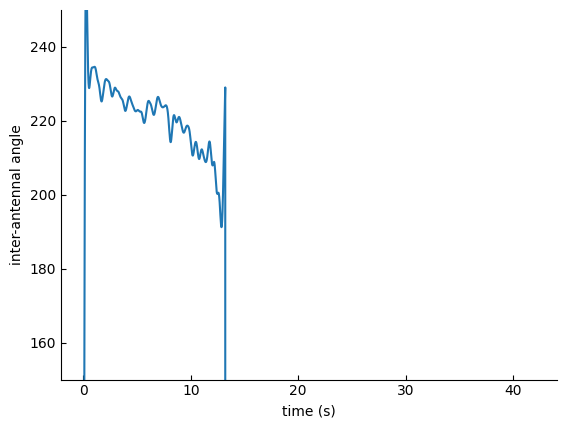

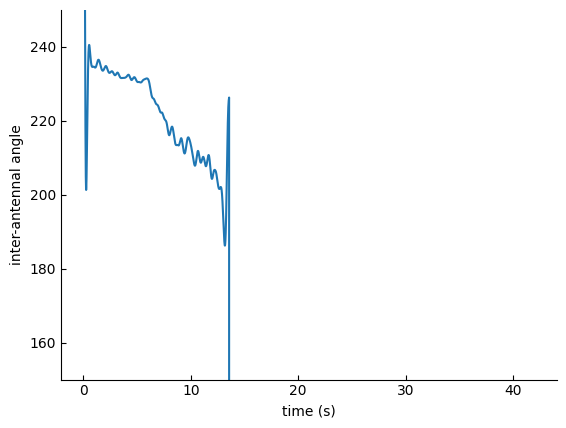

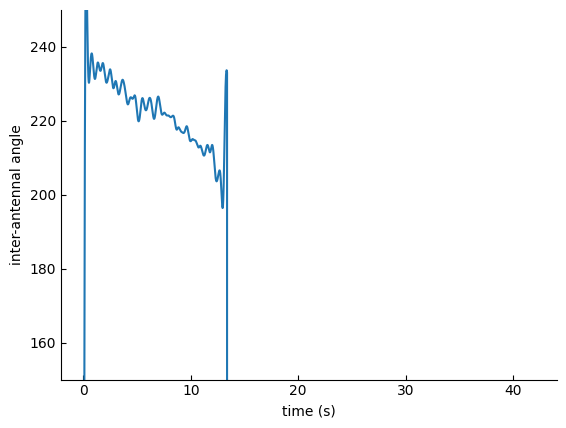

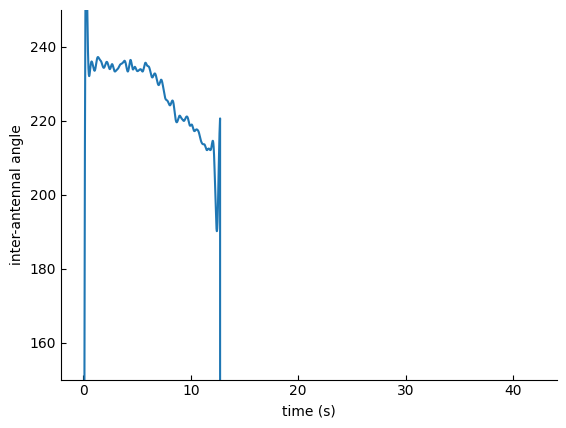

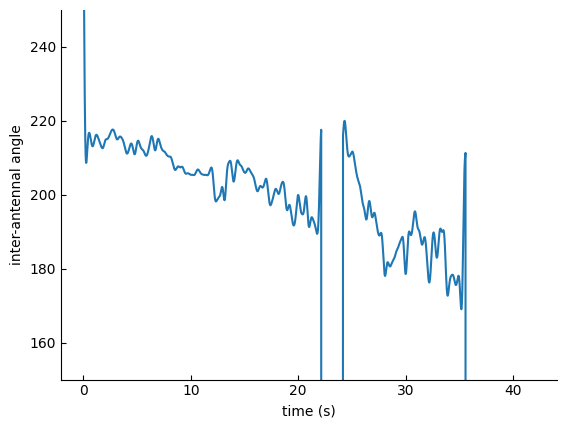

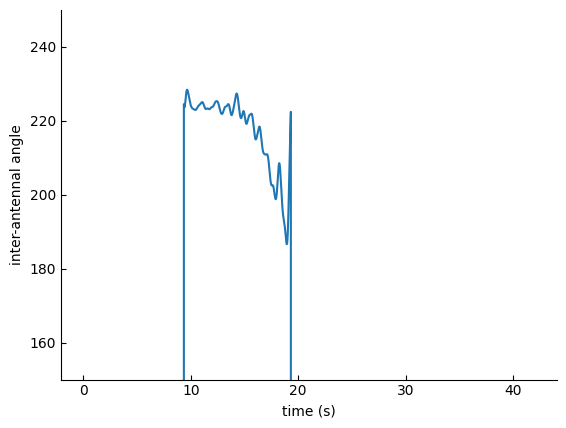

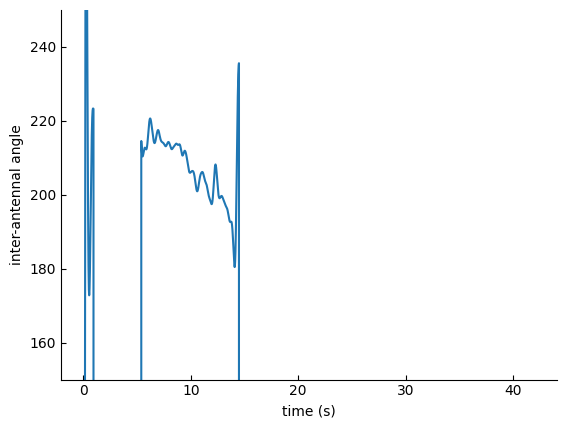

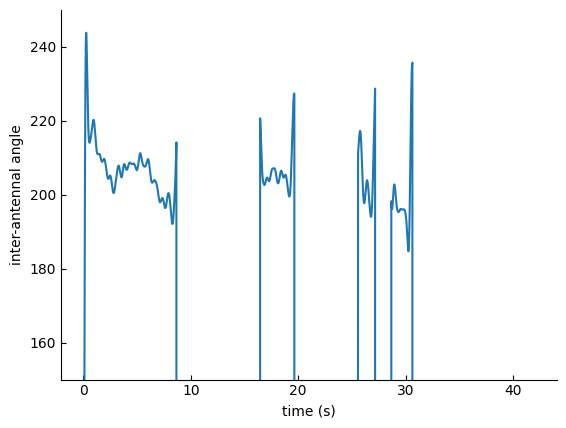

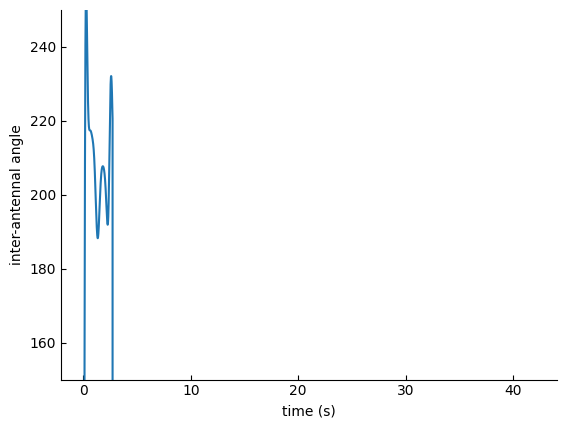

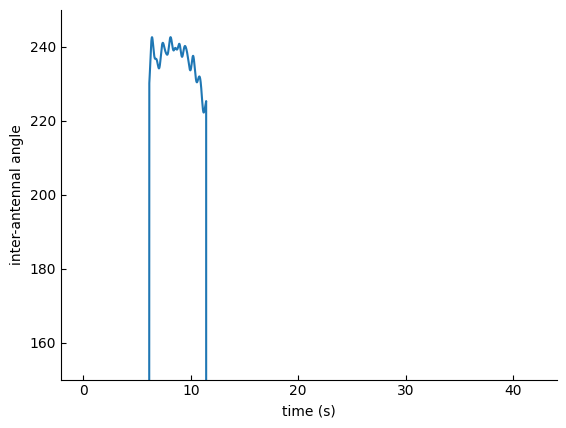

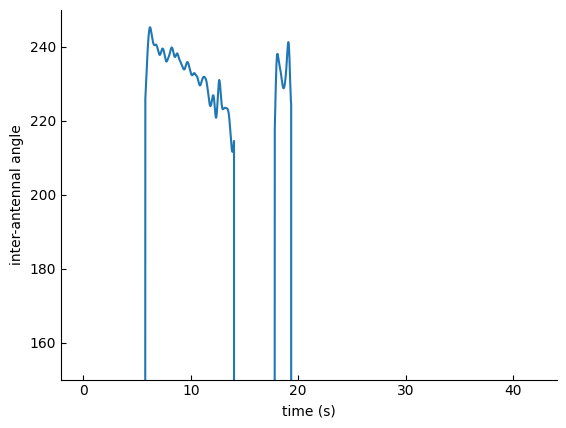

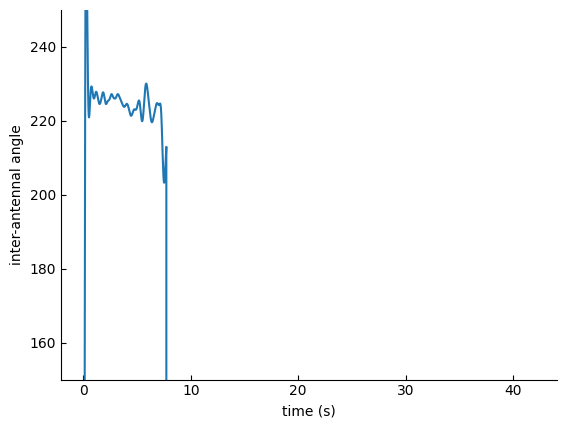

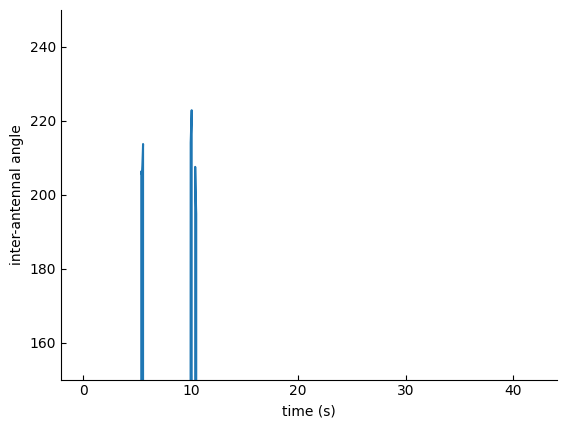

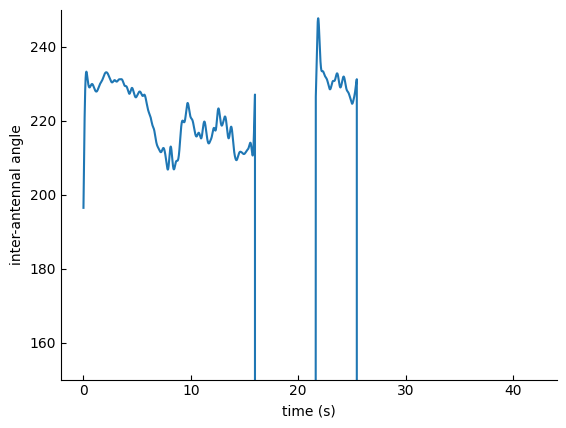

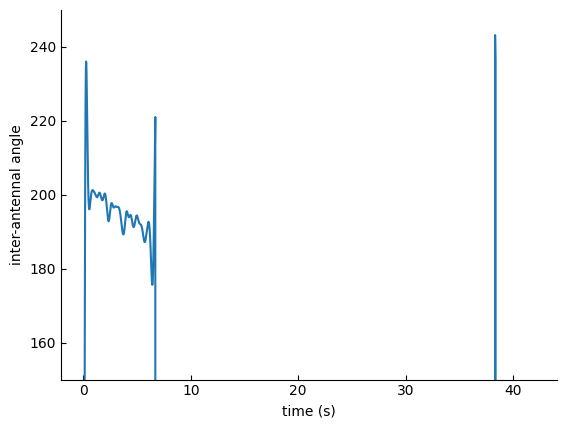

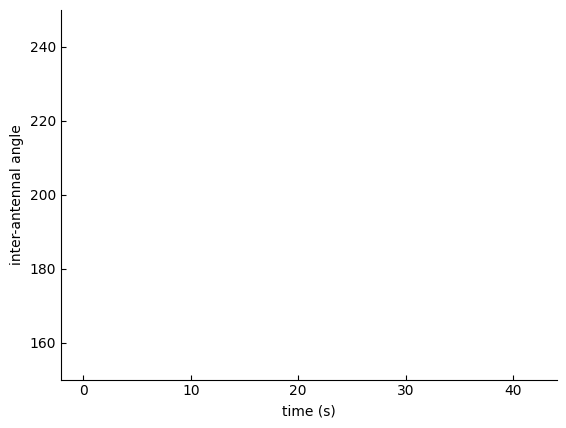

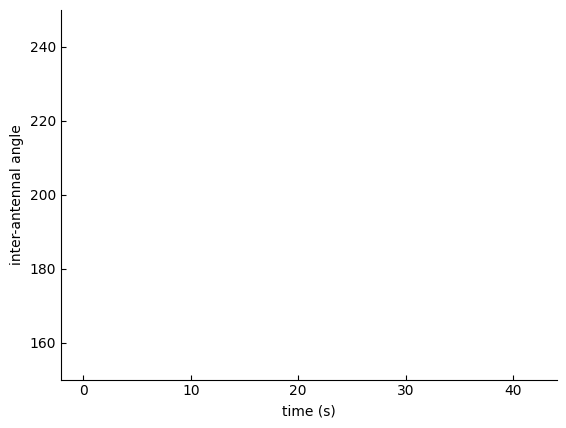

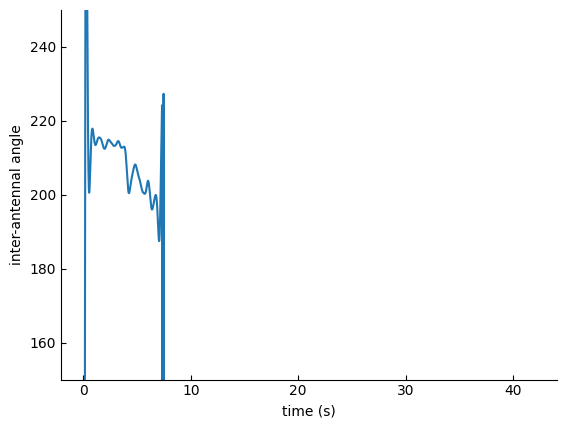

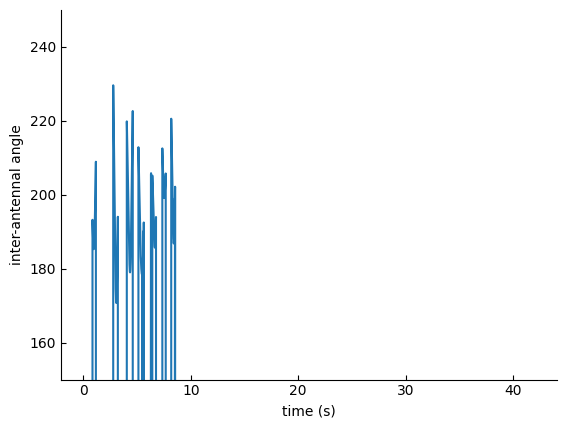

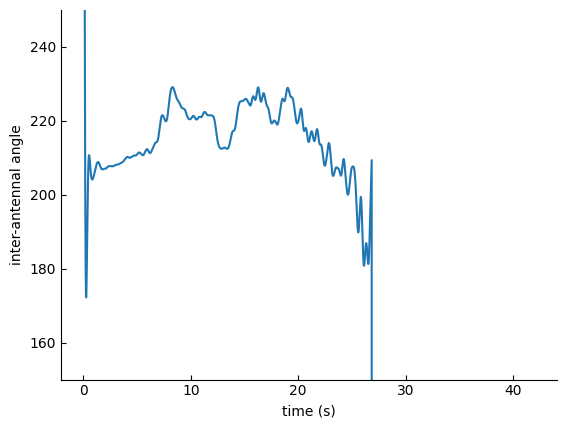

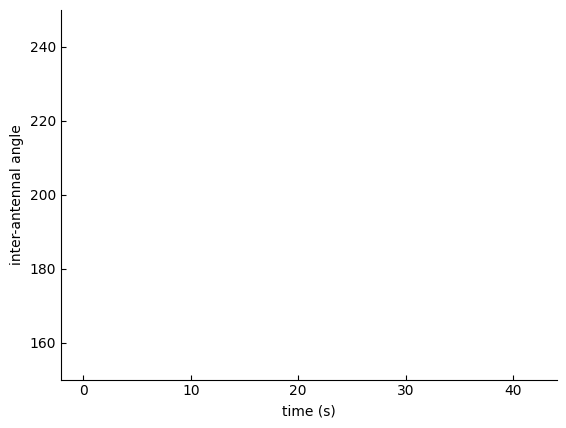

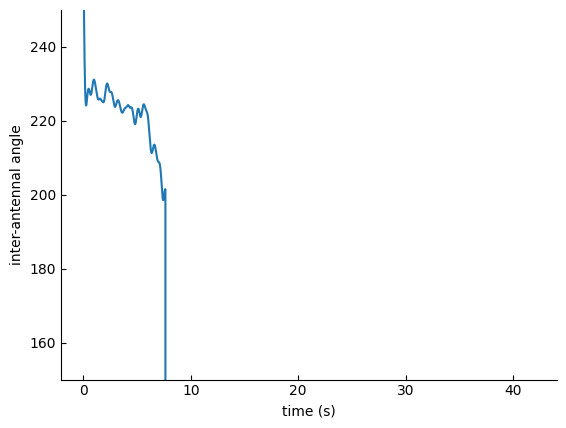

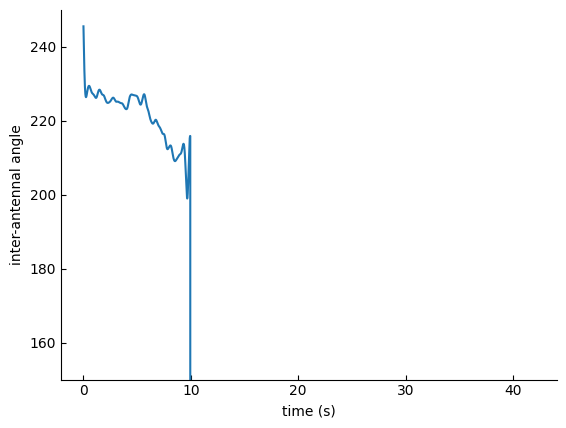

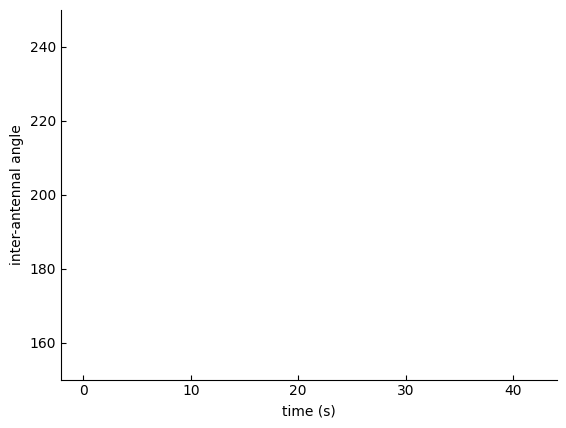

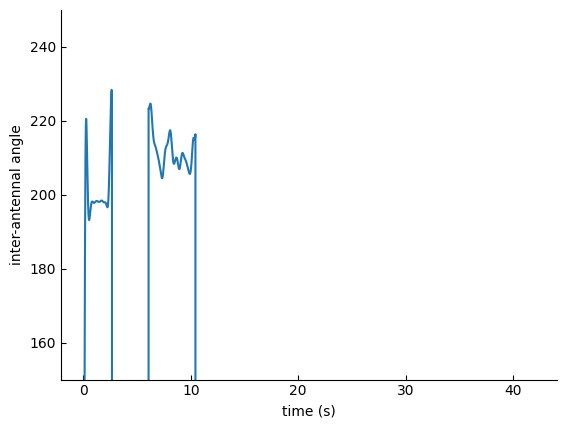

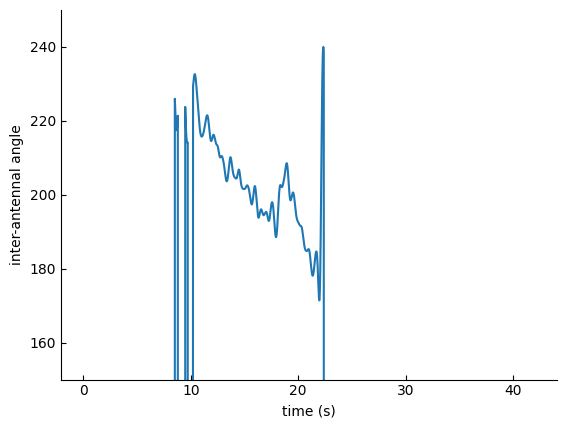

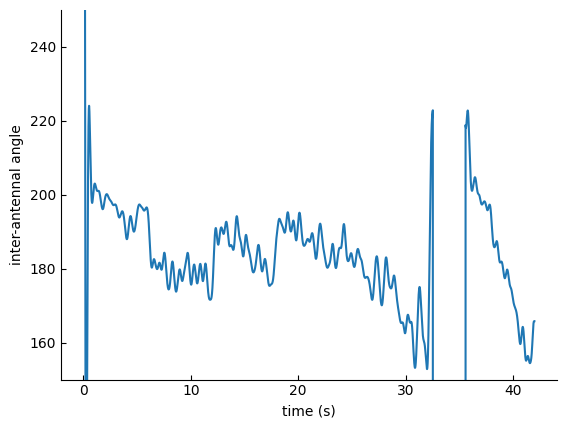

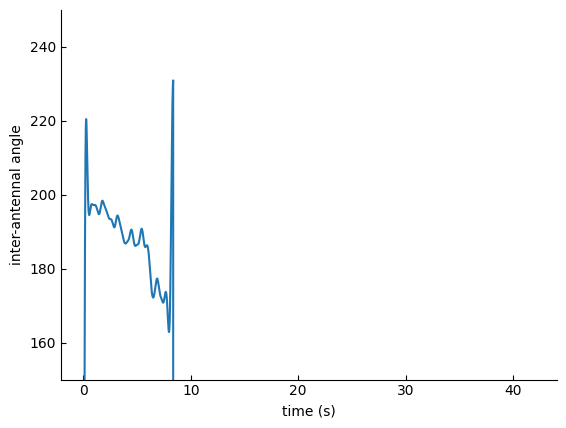

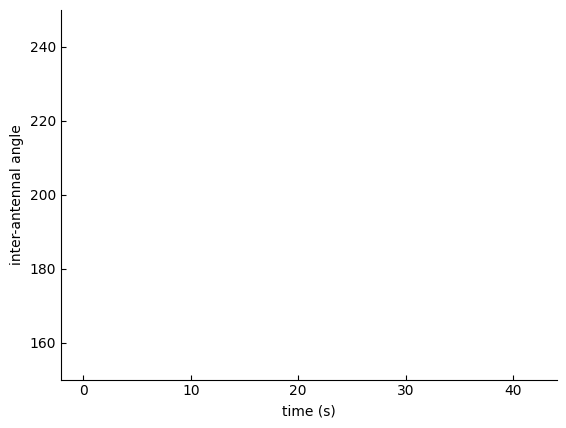

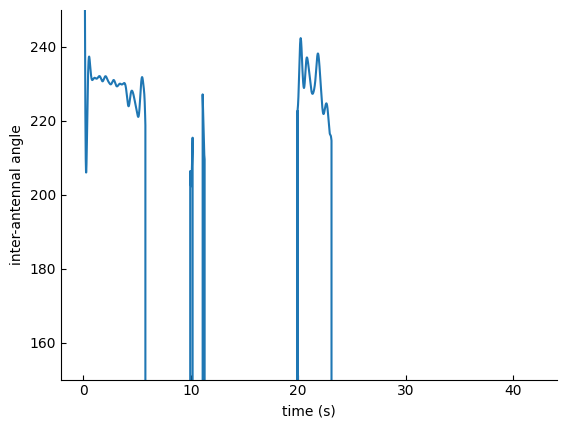

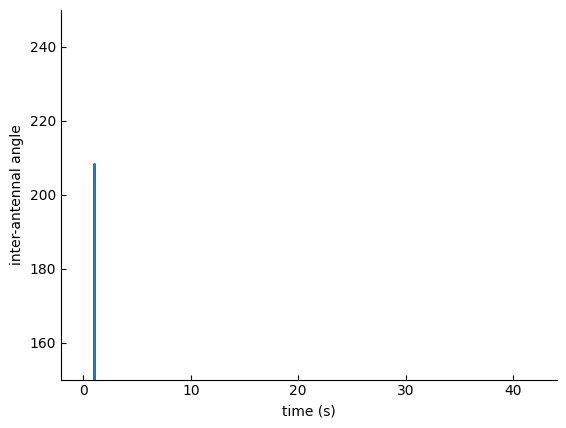

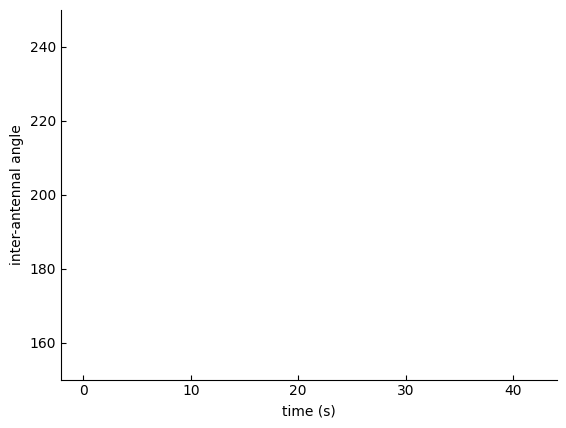

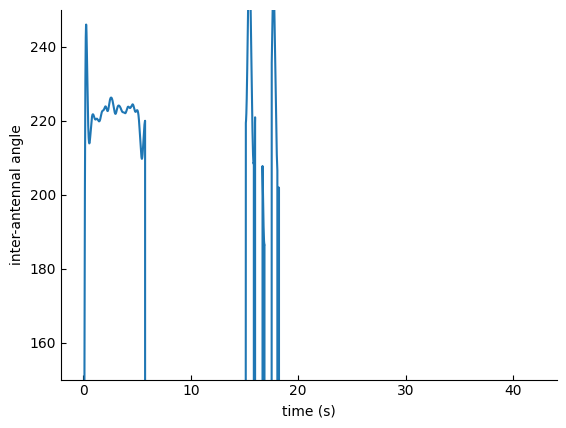

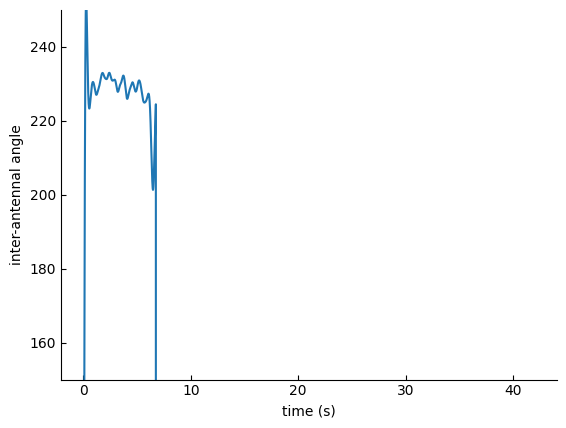

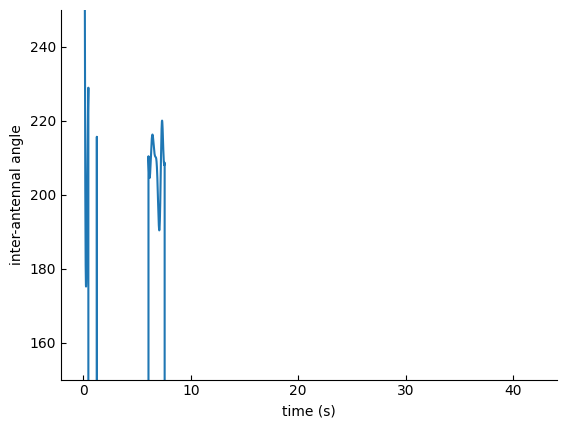

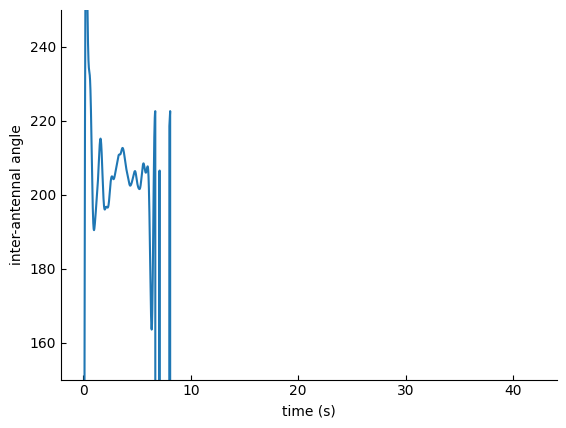

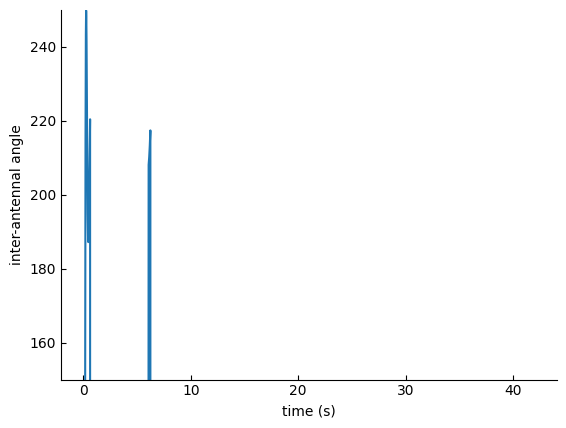

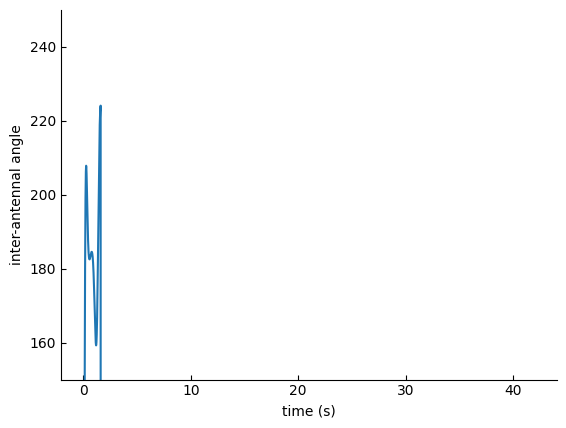

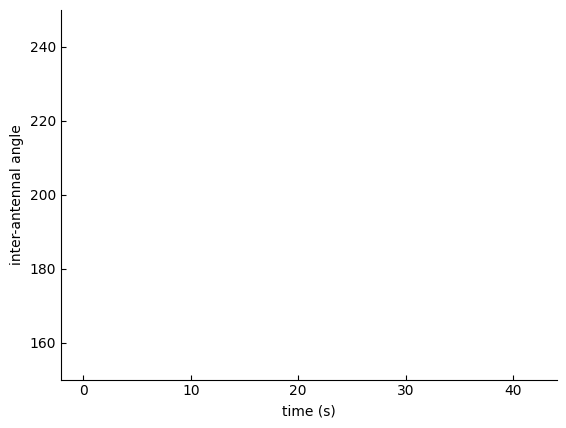

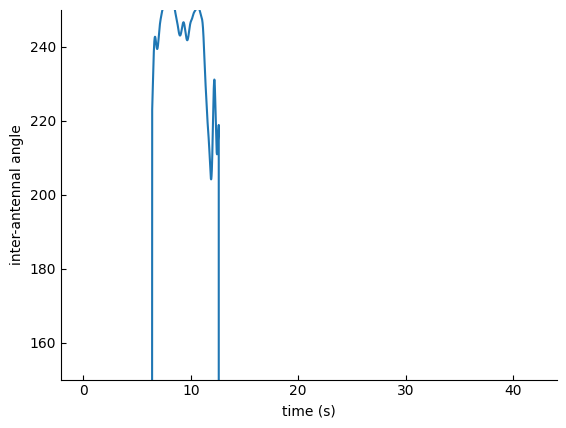

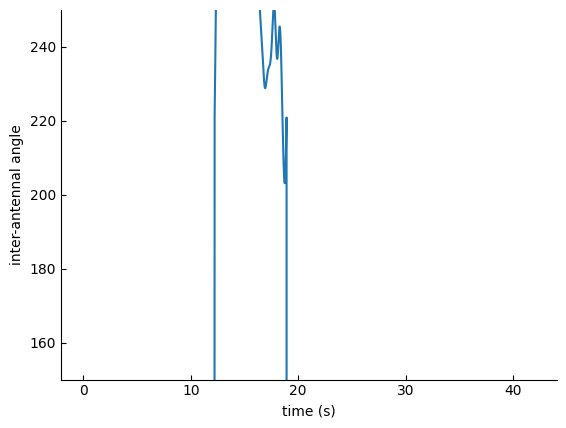

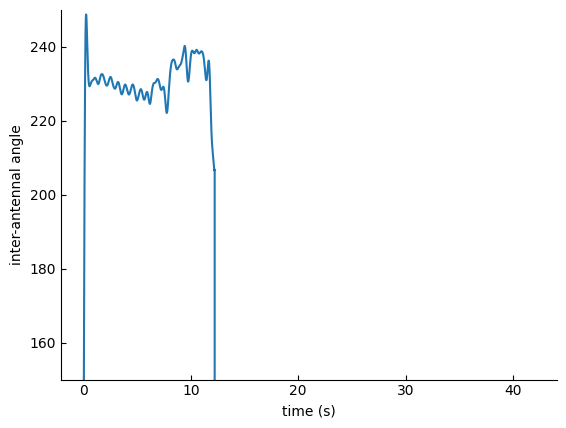

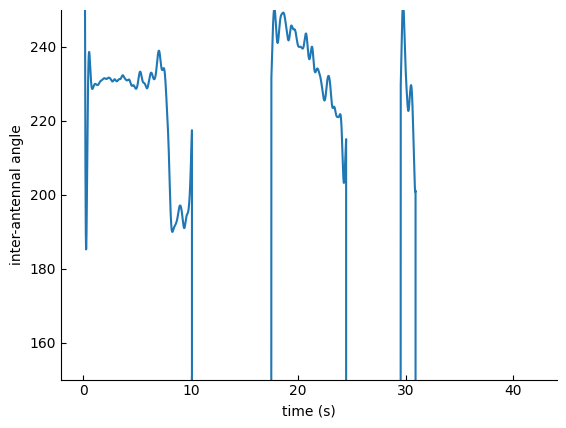

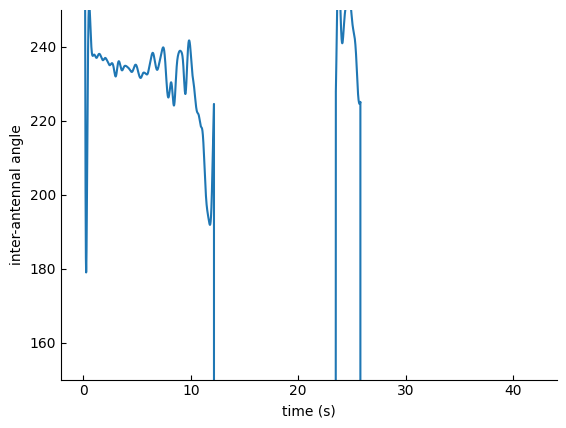

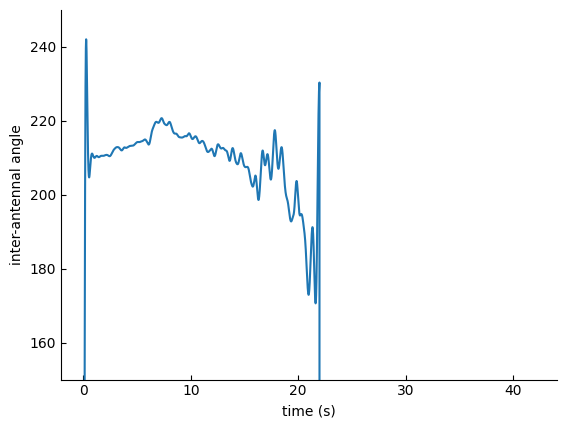

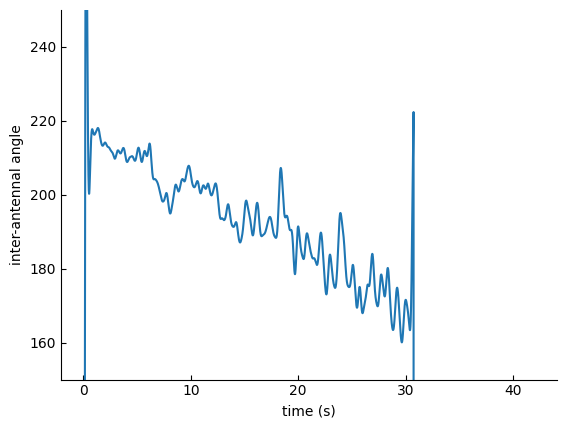

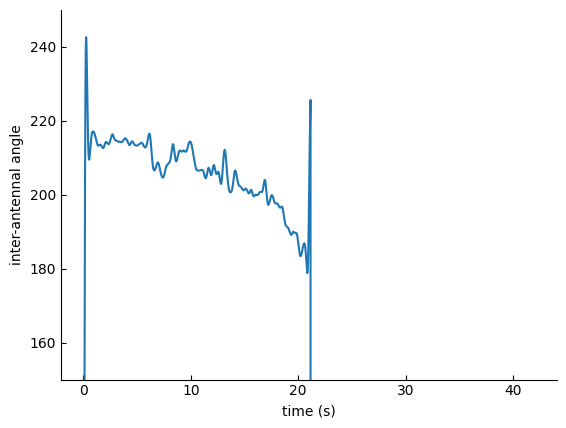

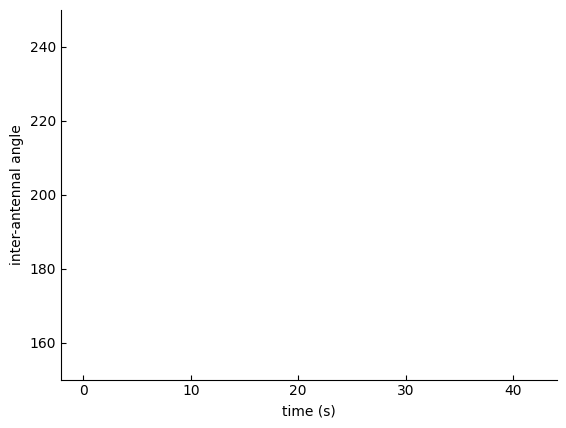

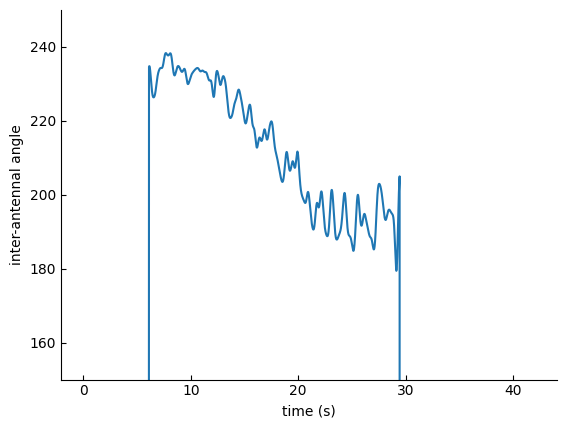

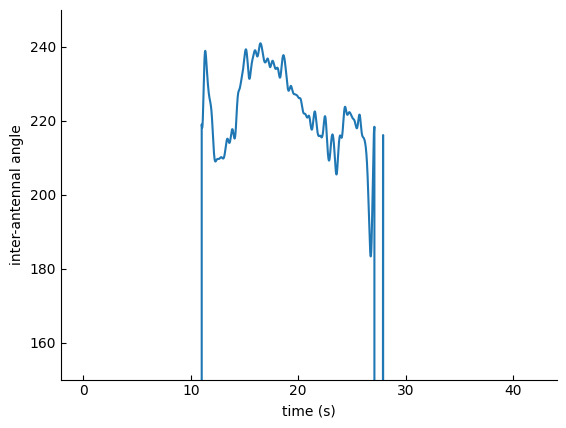

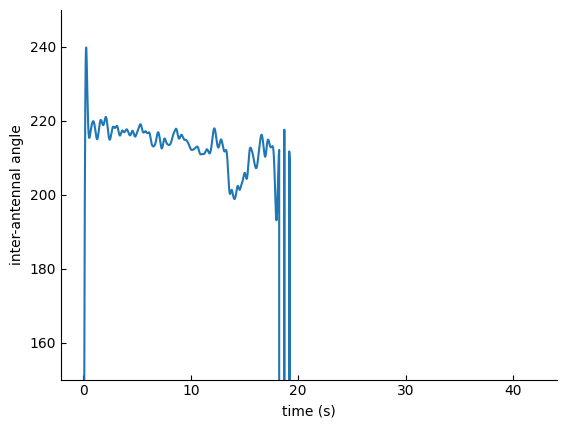

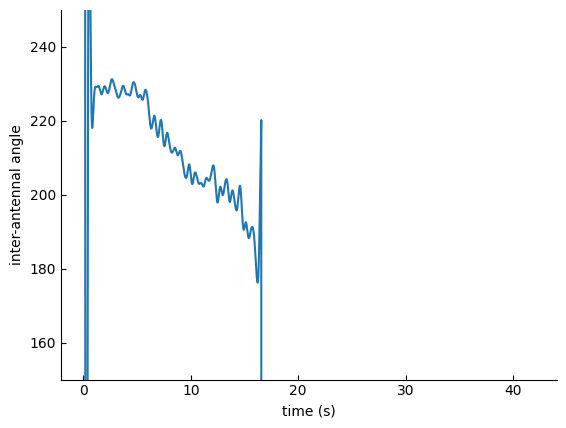

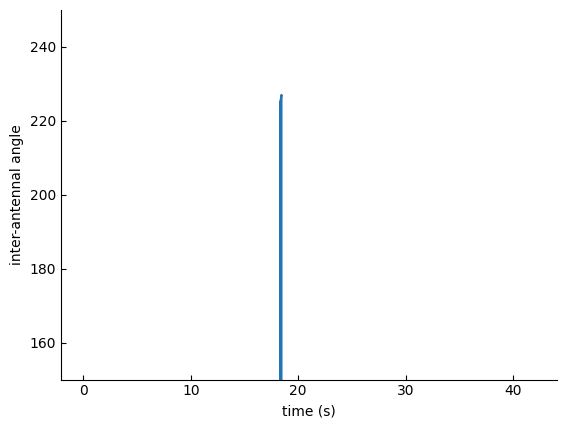

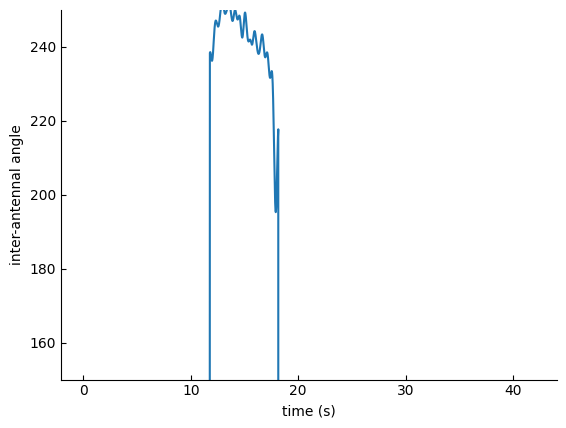

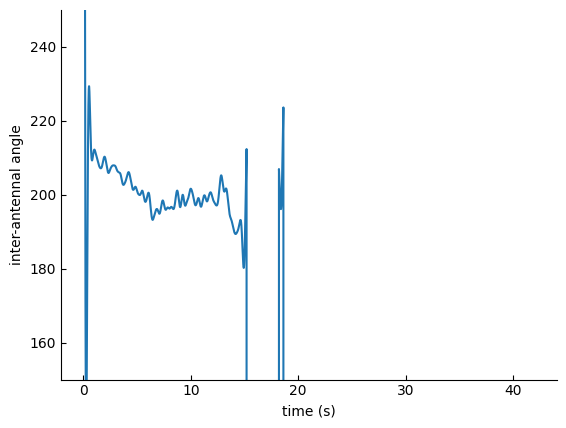

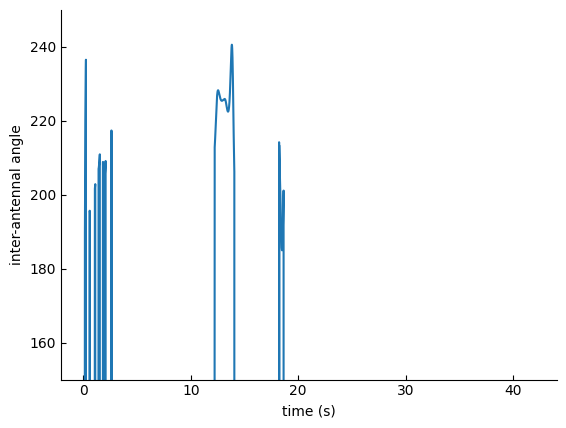

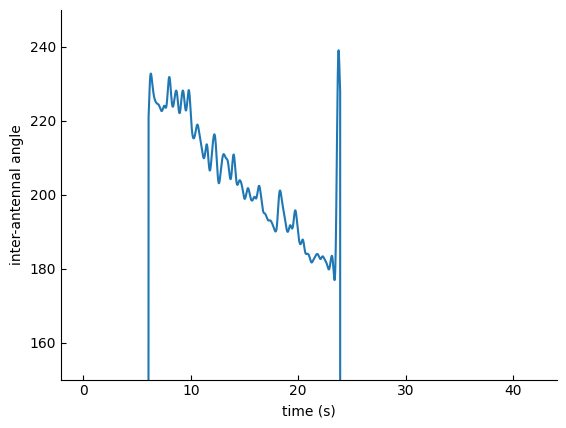

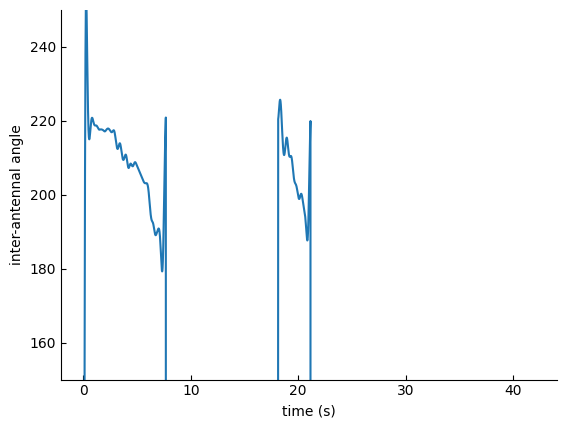

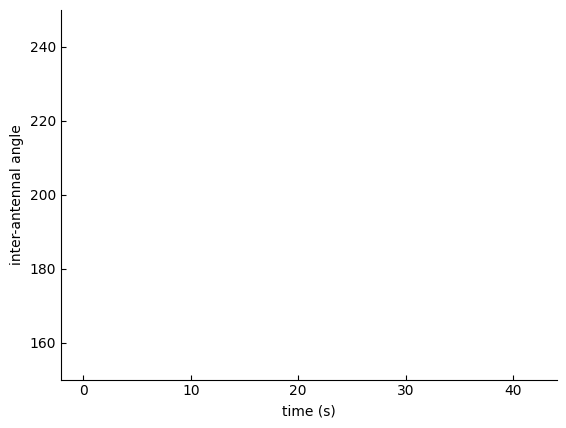

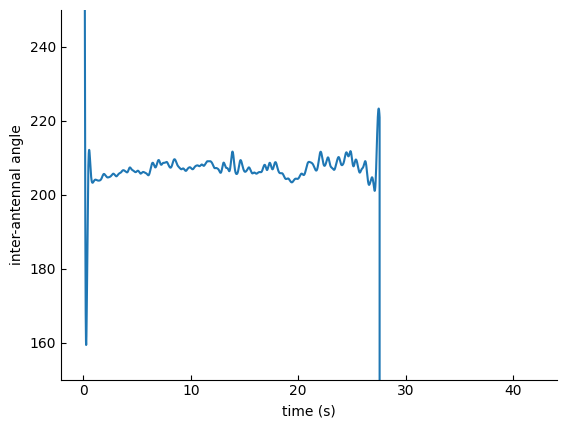

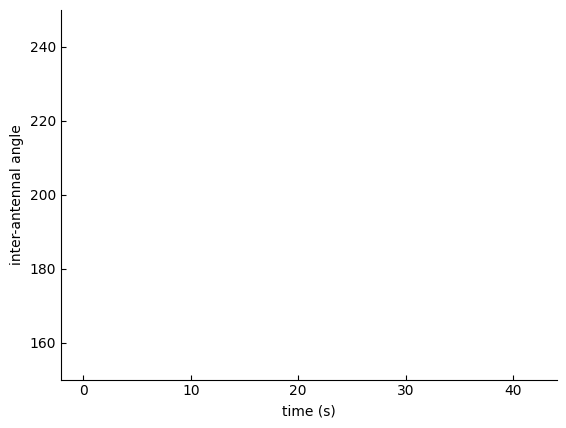

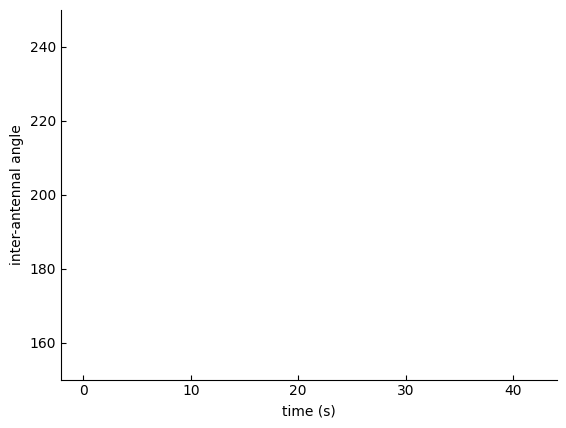

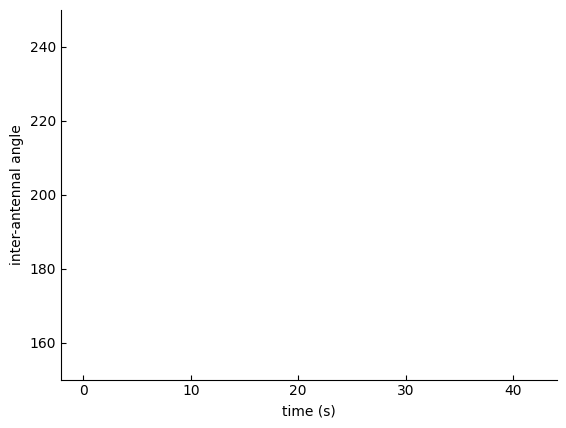

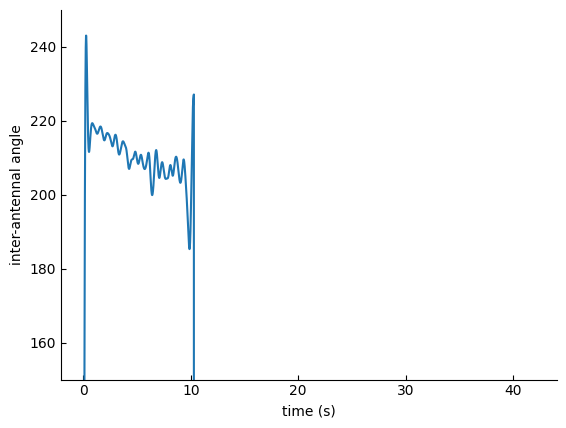

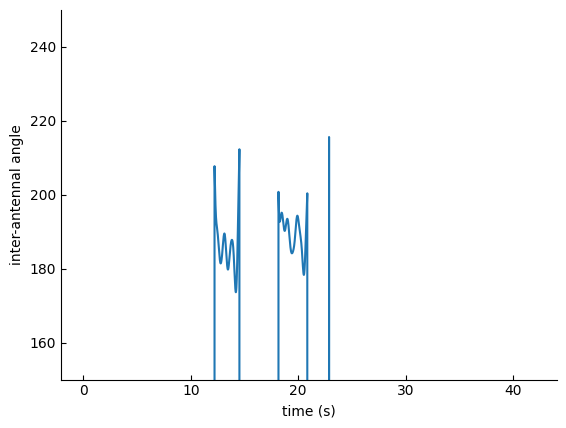

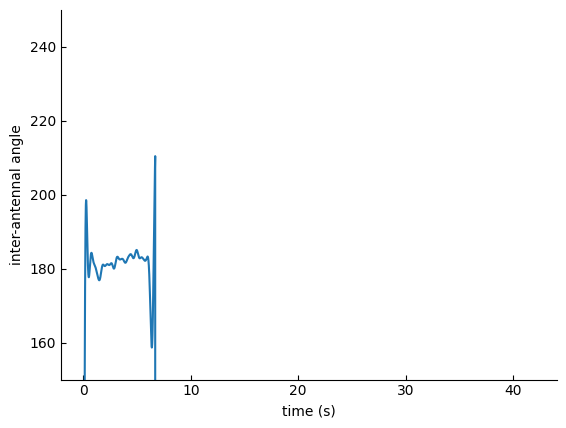

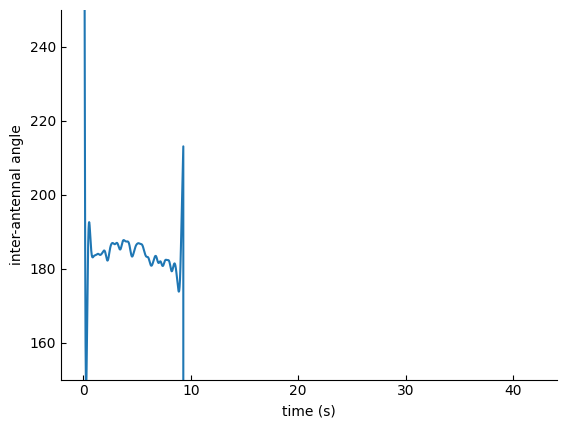

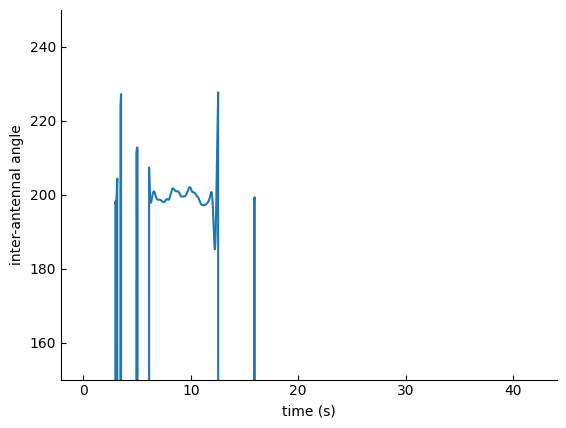

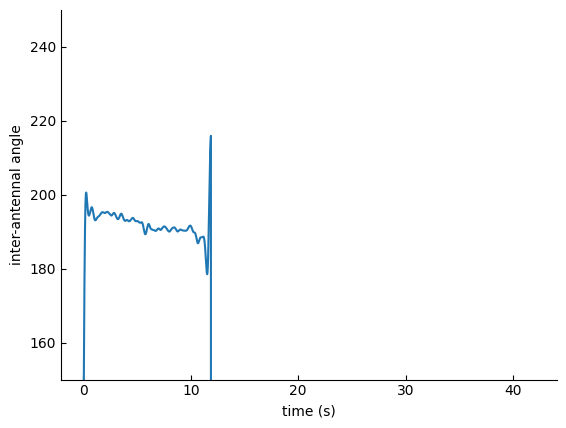

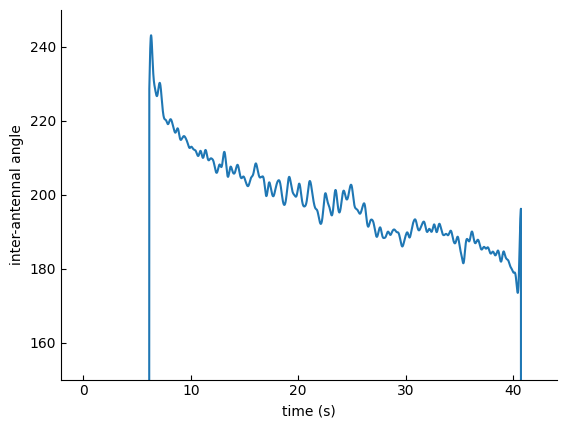

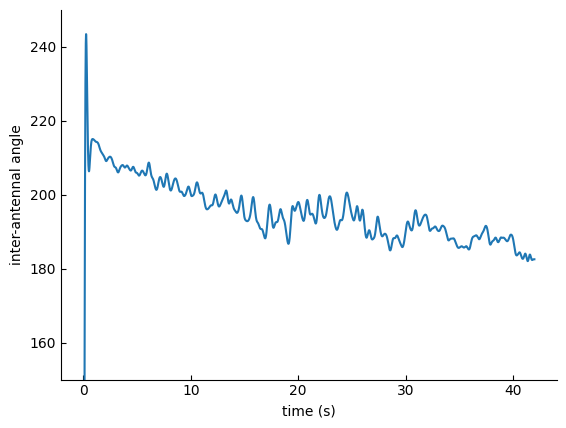

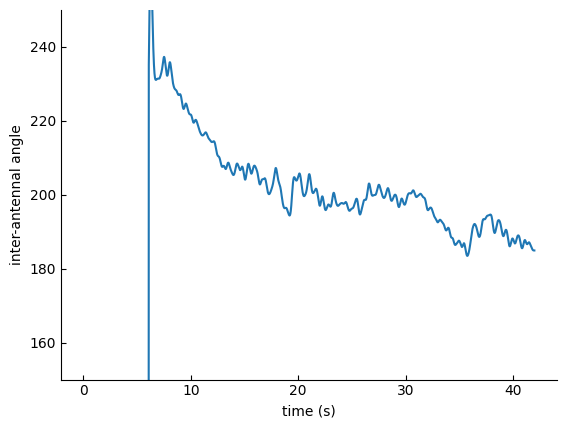

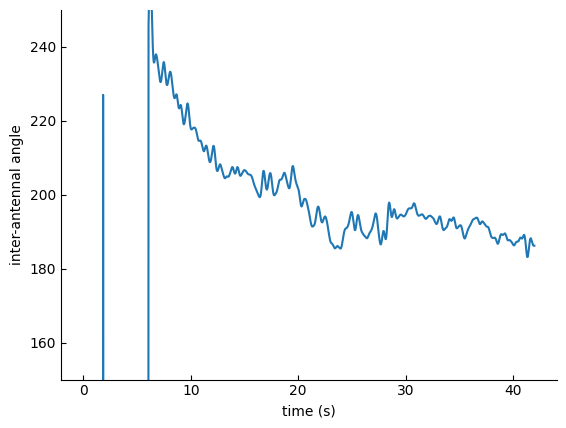

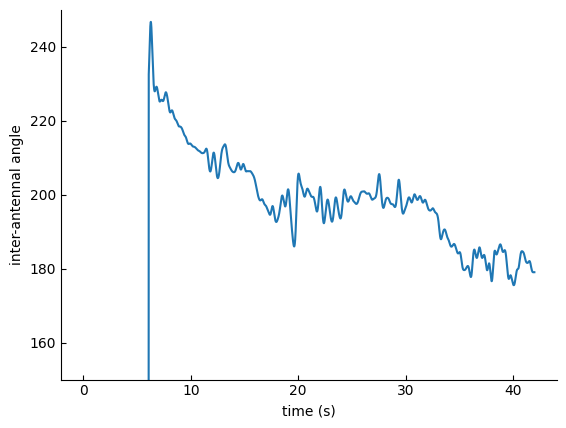

In [7]:
df_a = df[(df['stimType'] == 1) & (df['condition'] == 'dark')].reset_index()

for row in df_a['wbf']:
    fig,ax = plt.subplots()
    x = np.linspace(0,42,840000)
    #ax.plot(x,row[:,1])
    ax.plot(x,row)
    ax.set_ylim([150,250])
    ax.set_ylabel('inter-antennal angle')
    ax.tick_params(direction="in")
    ax.set_xlabel('time (s)')
    ax.spines[['right', 'top']].set_visible(False)
    #ax.set_yticks([120,130,140,150,160,170,180])
for row in df_a['trial']:
    print(row)
#fig.savefig('static_vid.pdf')

index


TypeError: string indices must be integers

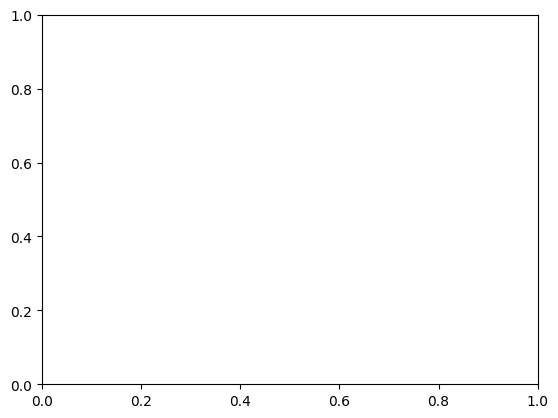

In [3]:
df_a = df[(df['stimType'] == 1) & (df['condition'] == 'static') & (df['fly'] == 3) & (df['trial']==9)].reset_index()

for row in df_a:
    print(row)
    fig,ax = plt.subplots()
    x = np.linspace(0,42,2520)
    ax.plot(x,row[:,1])
    ax.plot(x,row[:,0])
    ax.set_ylim([120,180])
    ax.set_ylabel('inter-antennal angle')
    ax.tick_params(direction="in")
    ax.set_xlabel('time (s)')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_yticks([120,130,140,150,160,170,180])
for row in df_a['trial']:
    print(row)
fig.savefig('static_vid.pdf')

In [4]:
df

date expnumber condition  \
0   [b'', b'MCOS', b'string', [[3707764736], [2], ...       [1]      dark   
1   [b'', b'MCOS', b'string', [[3707764736], [2], ...       [1]      dark   
2   [b'', b'MCOS', b'string', [[3707764736], [2], ...       [1]      dark   
3   [b'', b'MCOS', b'string', [[3707764736], [2], ...       [1]      dark   
4   [b'', b'MCOS', b'string', [[3707764736], [2], ...       [1]      dark   
..                                                ...       ...       ...   
5                                          2024_11_21       [5]     18D07   
6                                          2024_11_21       [5]     18D07   
7                                          2024_11_21       [5]     18D07   
8                                          2024_11_21       [5]     18D07   
9                                          2024_11_21       [5]     18D07   

   min_age max_age samplerate adjust_time record_time   fps nframes  ...  \
0      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   
1      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   
2      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   
3      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   
4      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   
..     ...     ...        ...         ...         ...   ...     ...  ...   
5      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   
6      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   
7      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   
8      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   
9      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   

                                  100_Flight  \
0    [119.19777777777769, 132.7244444444442]   
1   [123.16000000000001, 133.64611111111105]   
2   [116.94499999999991, 129.88999999999967]   
3    [122.23777777777781, 133.8311111111111]   
4   [115.78611111111115, 130.36888888888873]   
..                                       ...   
5   [113.35055555555557, 116.05999999999997]   
6   [111.19444444444444, 114.99666666666667]   
7                                 [nan, nan]   
8                                 [nan, nan]   
9    [119.2144444444444, 120.20777777777771]   

                                100_noFlight  \
0                                 [nan, nan]   
1                                 [nan, nan]   
2                                 [nan, nan]   
3                                 [nan, nan]   
4                                 [nan, nan]   
..                                       ...   
5                                 [nan, nan]   
6                                 [nan, nan]   
7   [107.81888888888896, 115.09277777777773]   
8   [114.27611111111109, 119.56277777777774]   
9                                 [nan, nan]   

                                  150_Flight  \
0    [121.71444444444441, 131.5366666666665]   
1   [125.70944444444447, 133.79166666666686]   
2    [123.21722222222219, 130.8627777777779]   
3    [126.3644444444444, 134.82833333333335]   
4   [124.65999999999998, 134.68999999999986]   
..                                       ...   
5   [115.90222222222219, 111.56000000000002]   
6   [117.23222222222222, 113.53111111111109]   
7                                 [nan, nan]   
8                                 [nan, nan]   
9              [124.84055555555557, 119.525]   

                                150_noFlight  \
0                                 [nan, nan]   
1                                 [nan, nan]   
2                                 [nan, nan]   
3                                 [nan, nan]   
4                                 [nan, nan]   
..                                       ...   
5                                 [nan, nan]   
6                                 [nan, nan]   
7   [114.37444444444445, 113.67777777777776]   


In [7]:
print(df.groupby('fly'))

840000

In [51]:
np.size(test_trace)

840000

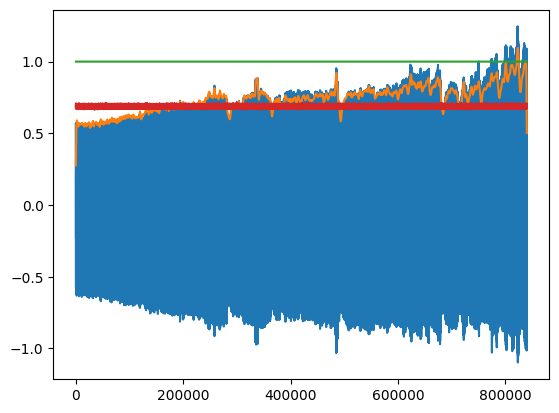

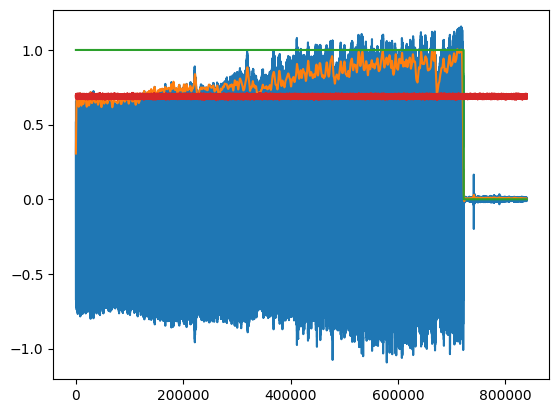

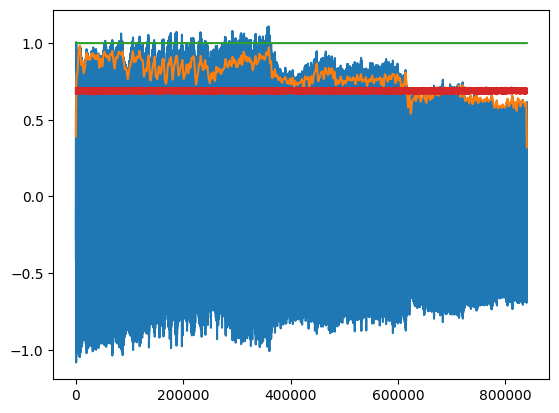

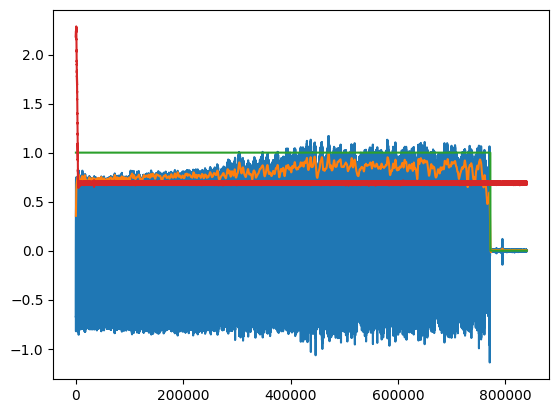

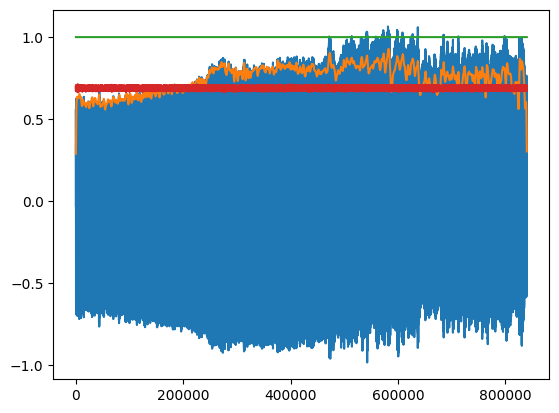

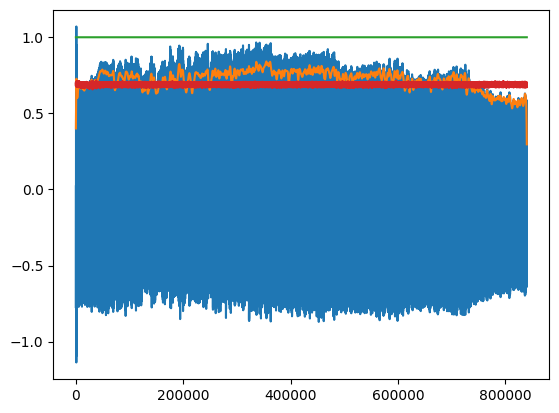

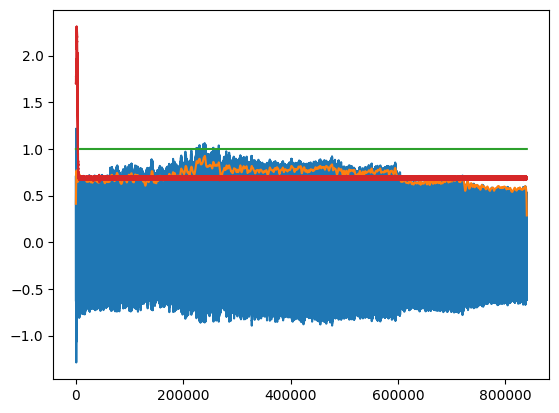

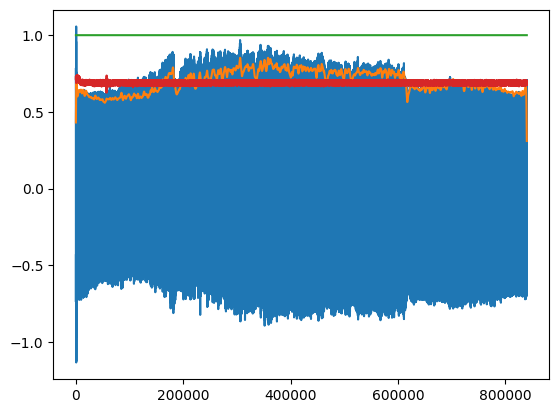

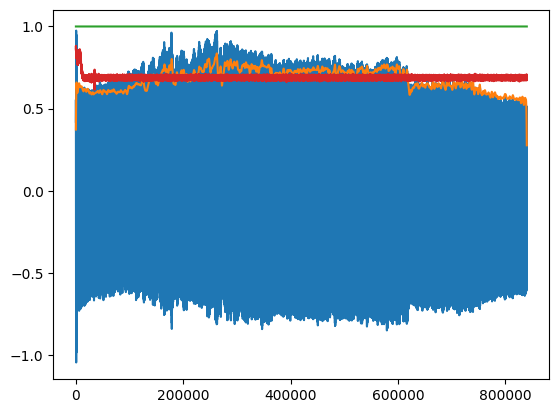

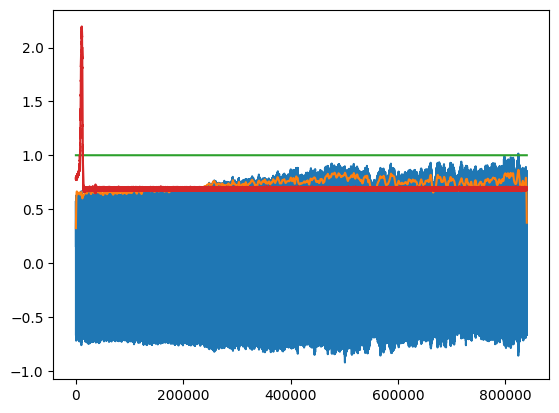

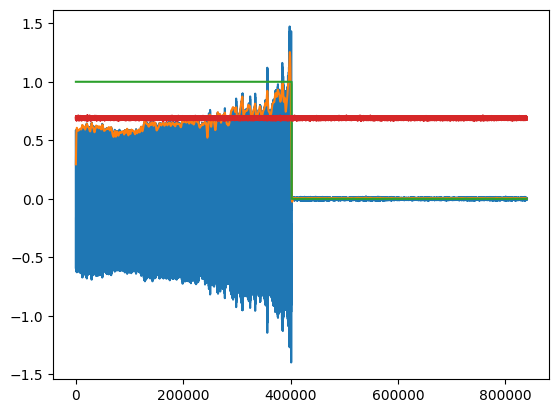

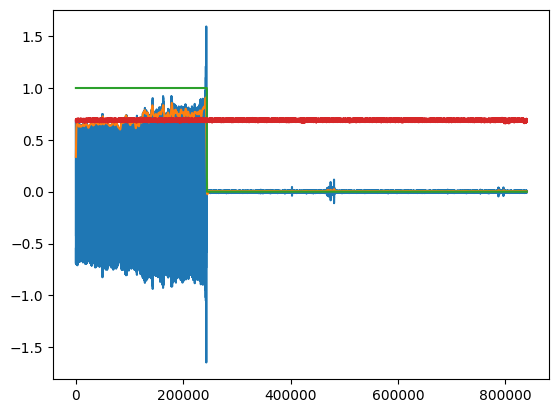

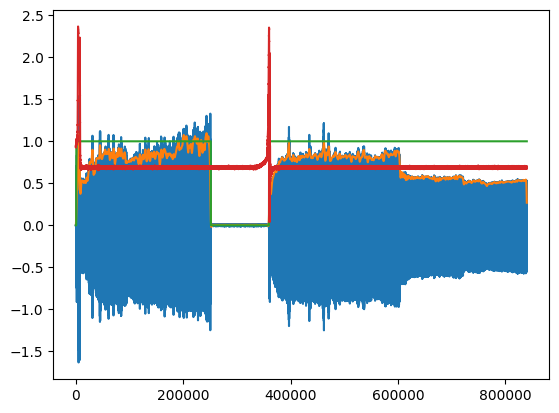

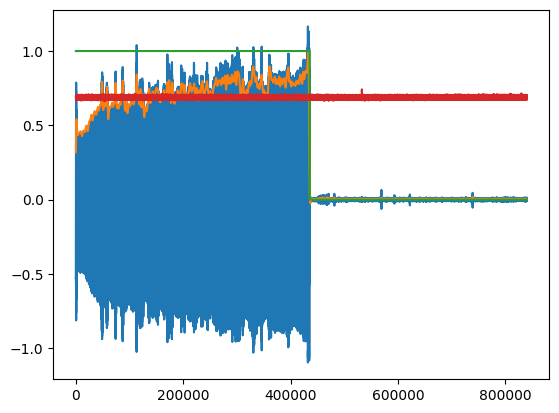

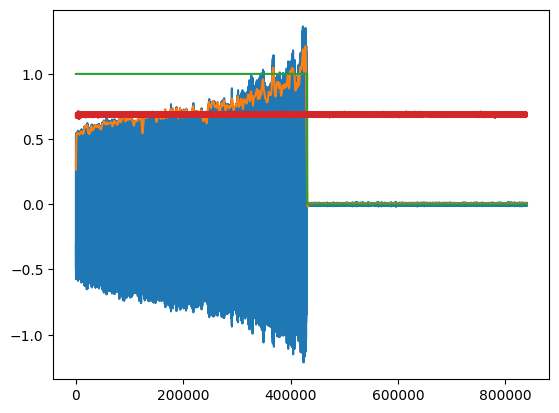

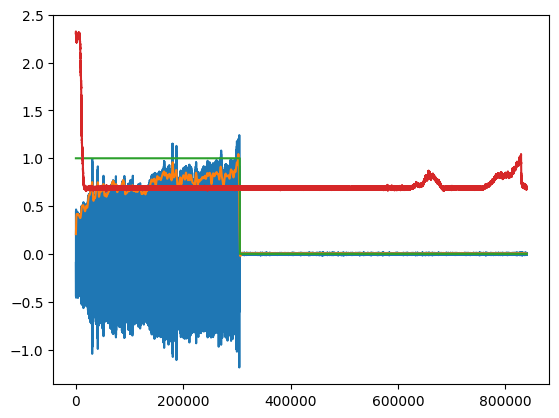

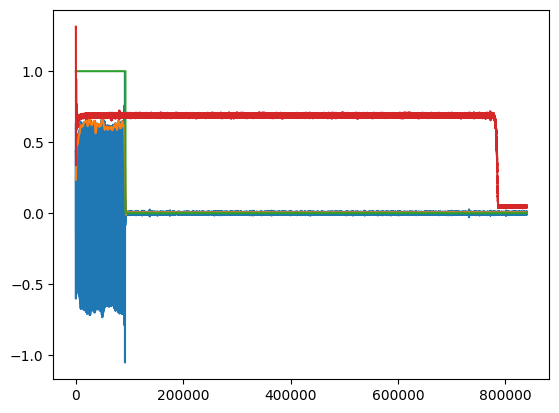

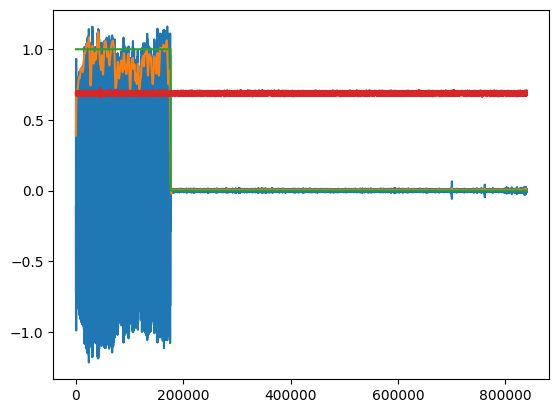

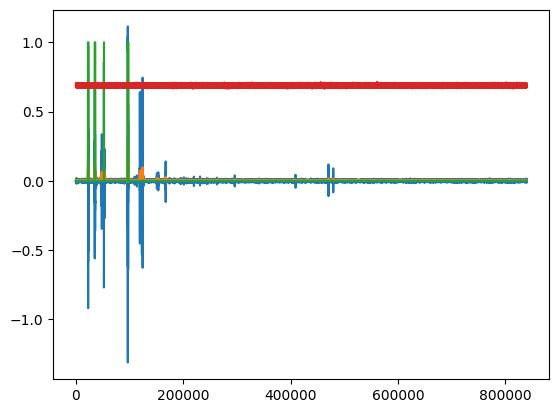

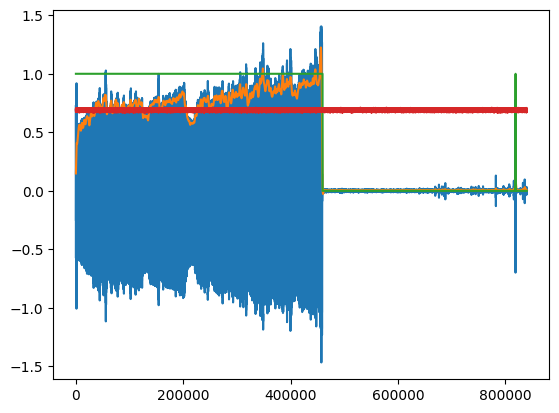

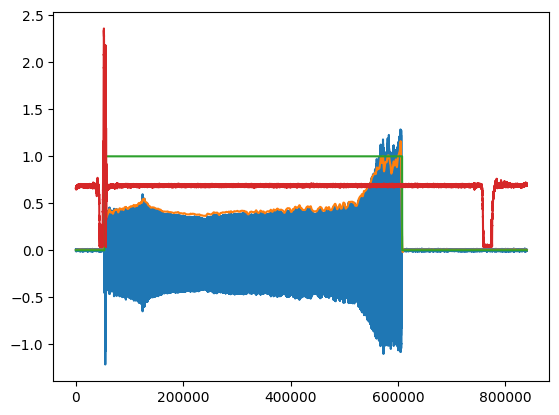

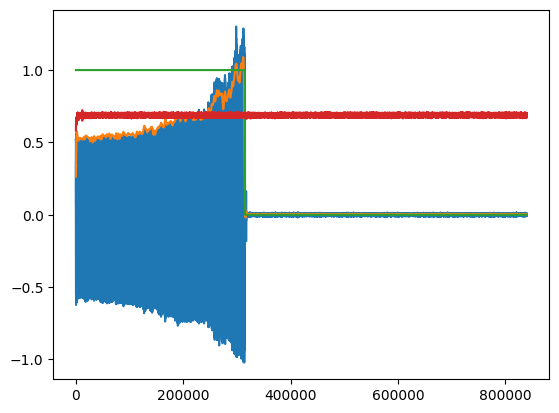

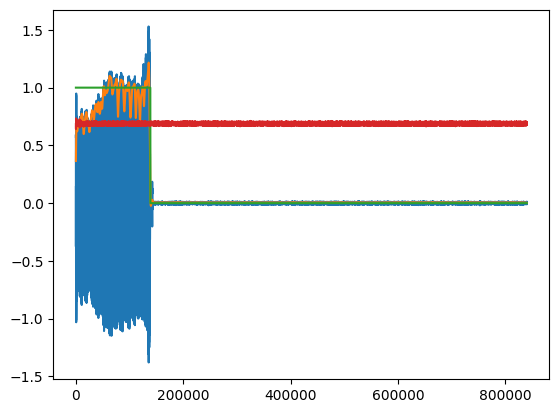

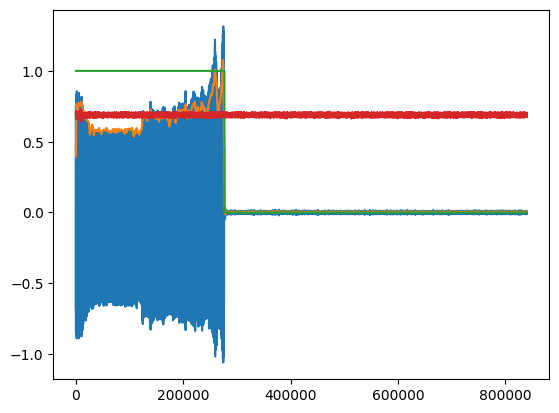

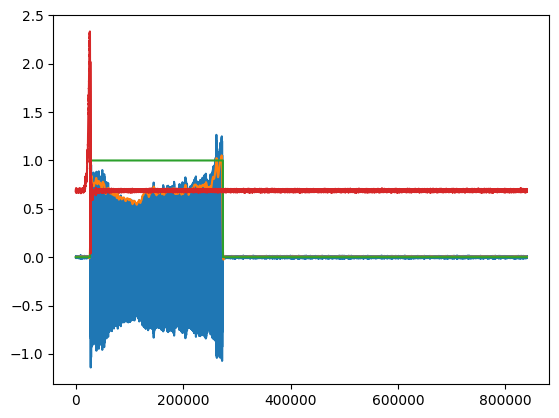

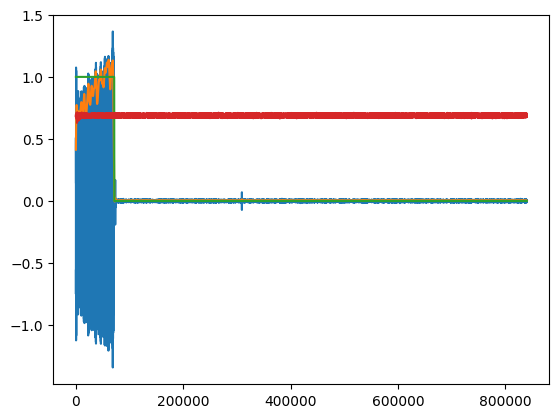

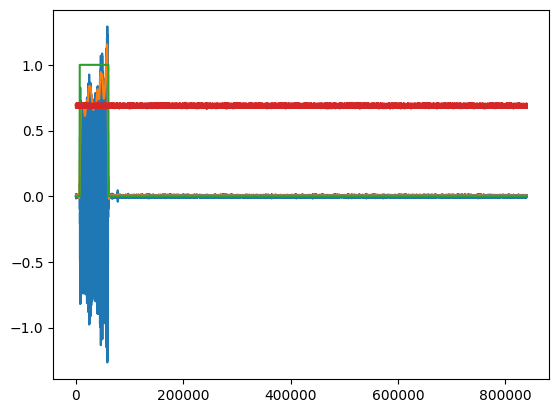

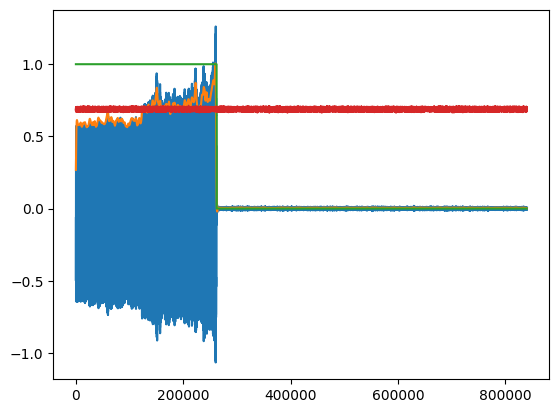

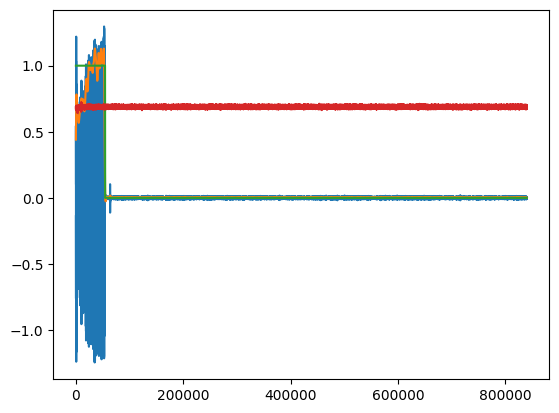

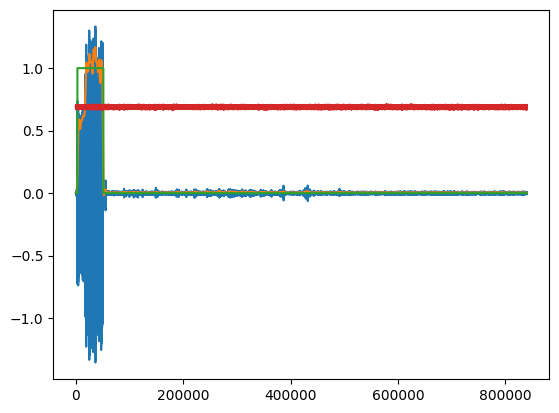

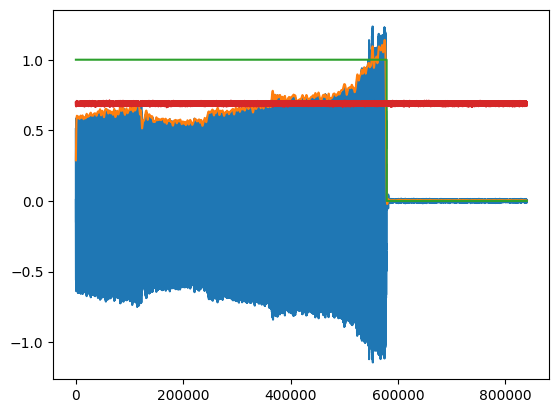

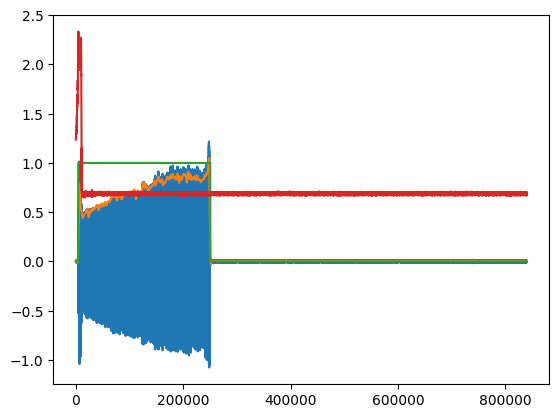

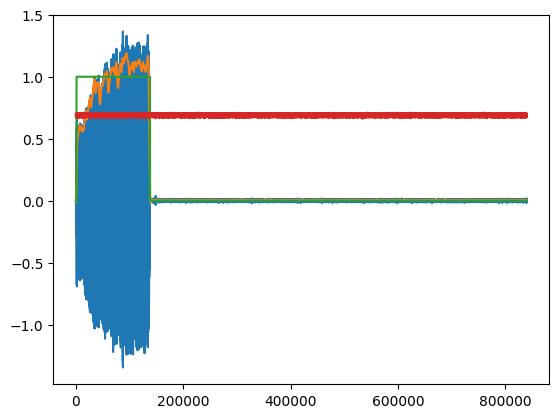

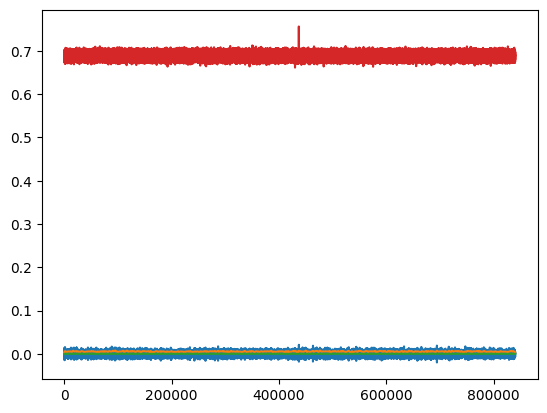

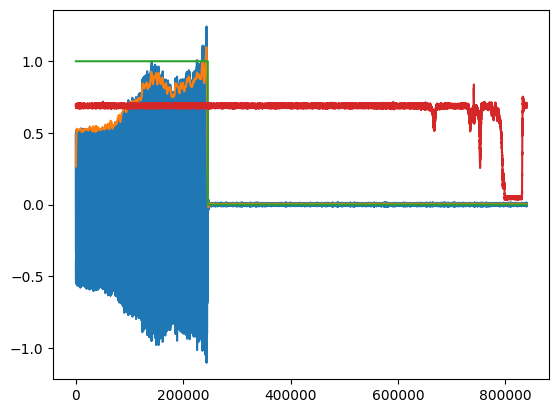

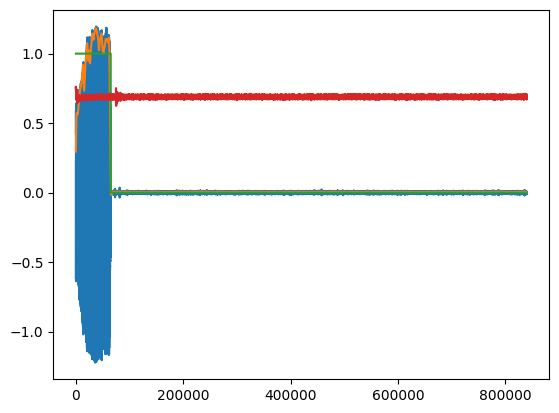

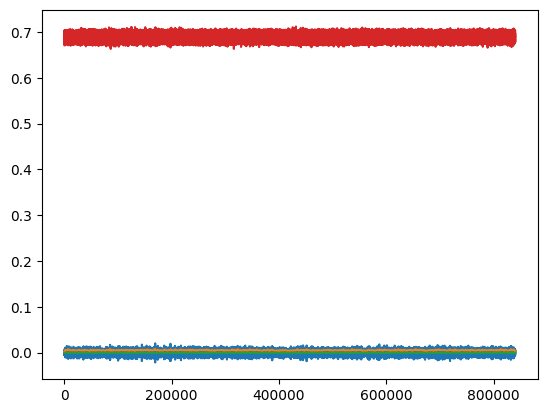

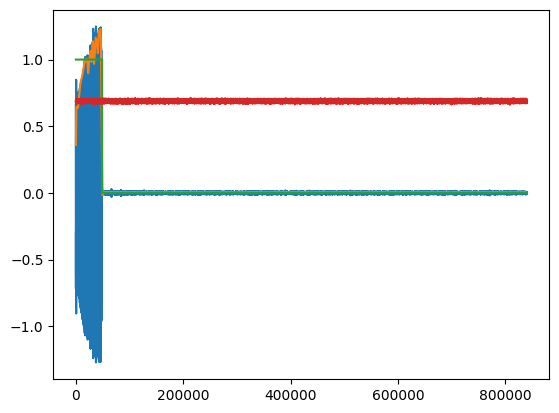

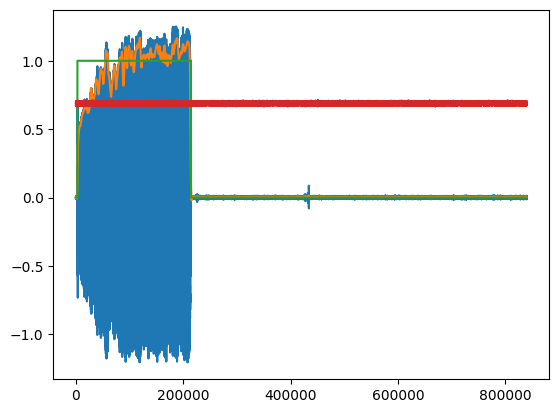

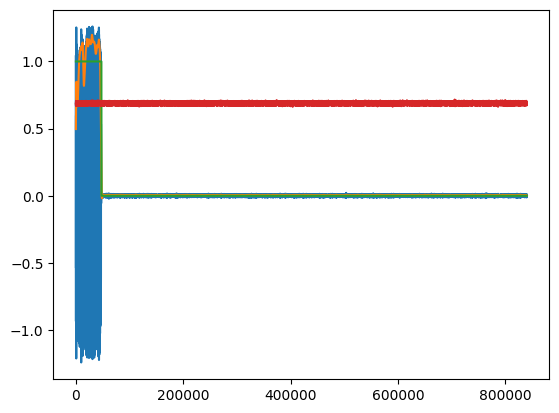

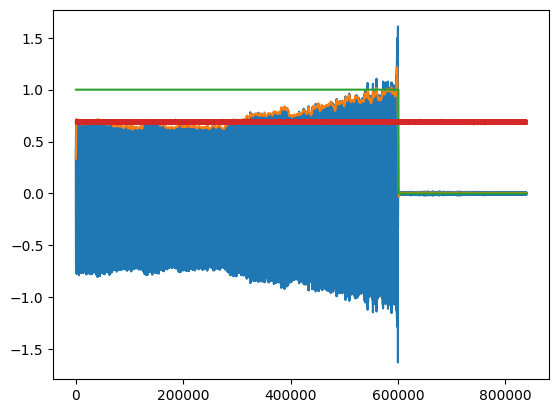

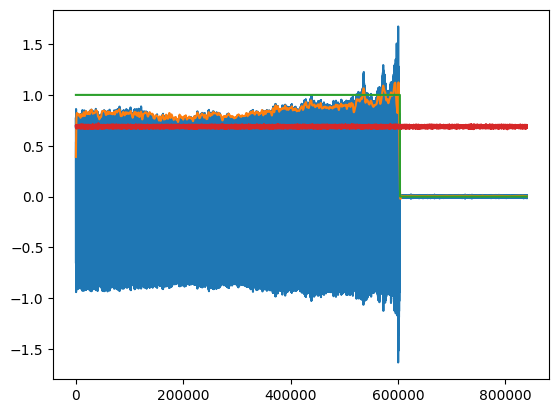

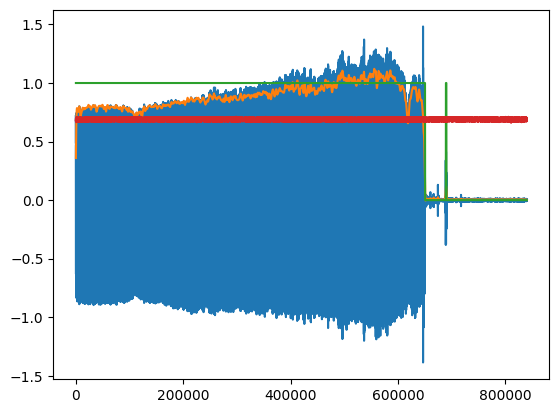

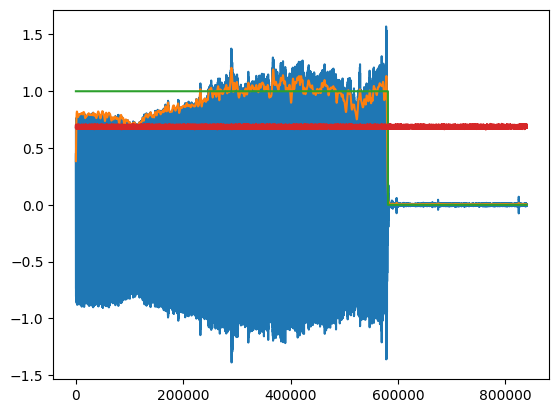

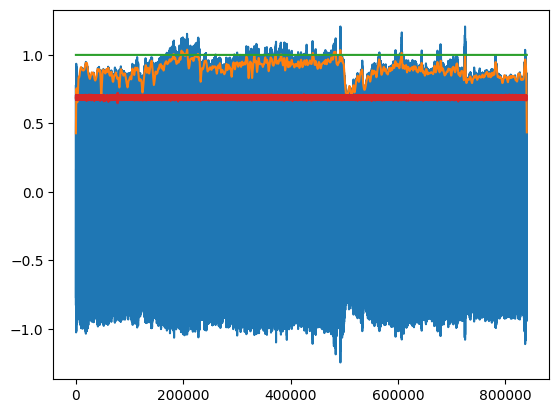

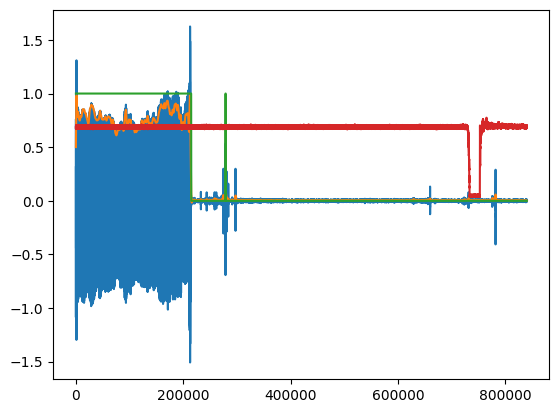

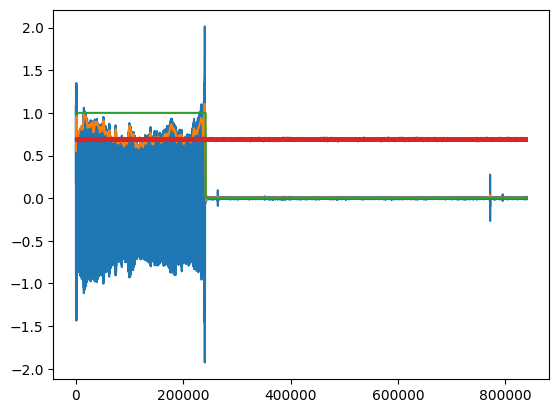

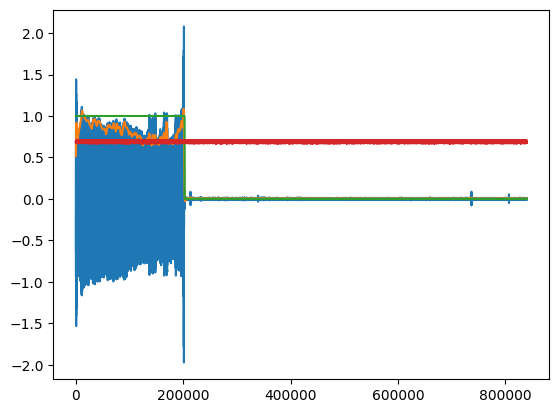

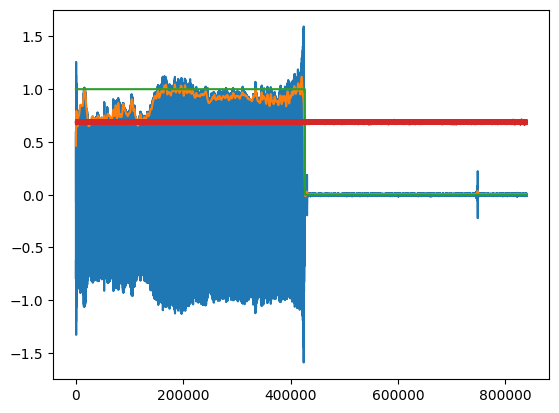

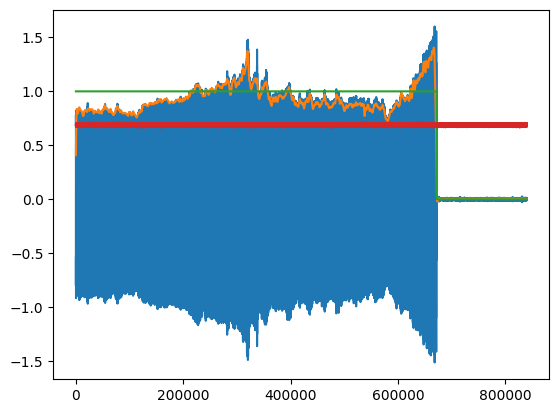

In [20]:
for i in range(50):
    fig,ax=plt.subplots()
    test_trace = df.reset_index()['tachometerSignal_smoothed'][i]
    pad_val=100000
    pad = np.zeros((1,pad_val))
    front_padded = np.append(pad,test_trace)
    trace_padded = np.append(front_padded,pad)
    amp = np.abs(hilbert(trace_padded))
    b,a = butter(2,6,fs=20000)
    fin = filtfilt(b,a,amp)
    out2 = fin[pad_val:-pad_val]
    value = 0.1
    flightBool = out2 > value
    ax.plot(test_trace) #tach signal
    #plt.plot(df.reset_index()['tachometerSignal_smoothed'][619]) #smoothed tach signal
    ##plotting the cut off value for flight detection
    value = 0.1 #const.smoothed_flight_cutoff_value #partial= -0.19 & full = -0.41
    length = 100000
    constant_array = np.full(length, value)
    time = np.arange(length)
    #ax.plot(time, constant_array) #orange
    ##plotting the out2 value
    ax.plot(out2) # to test out2 value add flightBool=out2 to adc code
    ax.plot(flightBool)
    ax.plot(df.reset_index()['pufferSignal'][i])
